# Parsing PDF documents for RAG applications

This notebook shows how to leverage GPT-4o to turn rich PDF documents such as slide decks or exports from web pages into usable content for your RAG application.

This technique can be used if you have a lot of unstructured data containing valuable information that you want to be able to retrieve as part of your RAG pipeline.

For example, you could build a Knowledge Assistant that could answer user queries about your company or product based on information contained in PDF documents. 

The example documents used in this notebook are located at [data/example_pdfs](data/example_pdfs). They are related to OpenAI's APIs and various techniques that can be used as part of LLM projects.

## Data preparation

In this section, we will process our input data to prepare it for retrieval.

We will do this in 2 ways:

1. Extracting text with pdfminer
2. Converting the PDF pages to images to analyze them with GPT-4o

You can skip the 1st method if you want to only use the content inferred from the image analysis.

### Setup

We need to install a few libraries to convert the PDF to images and extract the text (optional).

**Note: You need to install `poppler` on your machine for the `pdf2image` library to work. You can follow the instructions to install it [here](https://pypi.org/project/pdf2image/).**

In [79]:
%pip install pdf2image -q
%pip install pdfminer -q
%pip install pdfminer.six -q
%pip install openai -q
%pip install scikit-learn -q
%pip install rich -q
%pip install tqdm -q
%pip install pandas -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [80]:
# Imports
from pdf2image import convert_from_path
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)
from pdfminer.high_level import extract_text
import base64
import io
import os
import concurrent.futures
from tqdm import tqdm
from openai import OpenAI
import re
import pandas as pd 
from sklearn.metrics.pairwise import cosine_similarity
import json
import numpy as np
from rich import print
from ast import literal_eval

### File processing

In [3]:
def convert_doc_to_images(path):
    images = convert_from_path(path)
    return images

def extract_text_from_doc(path):
    text = extract_text(path)
    return text

#### Testing with an example

In [4]:
file_path = "data/example_pdfs/fine-tuning-deck.pdf"

images = convert_doc_to_images(file_path)

In [8]:
text = extract_text_from_doc(file_path)

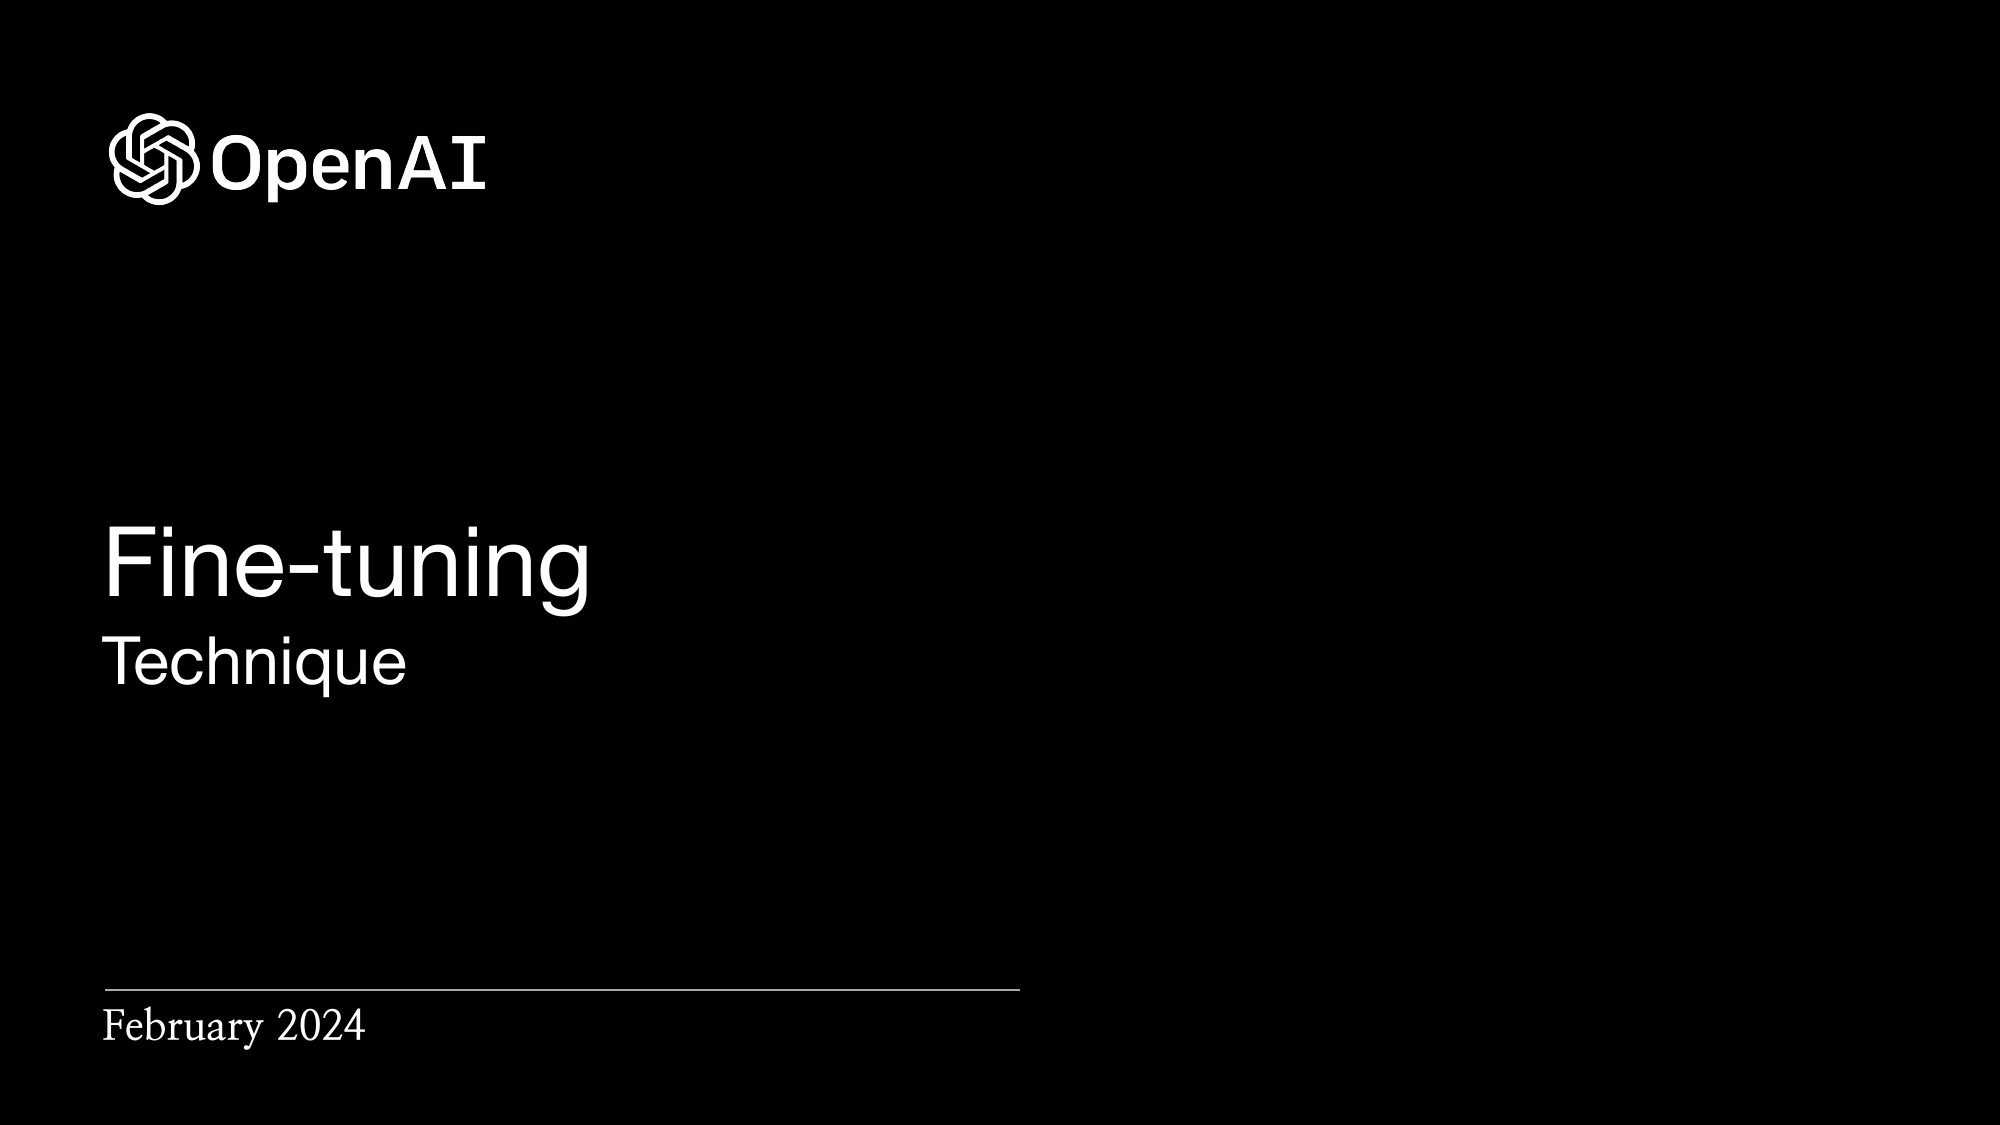

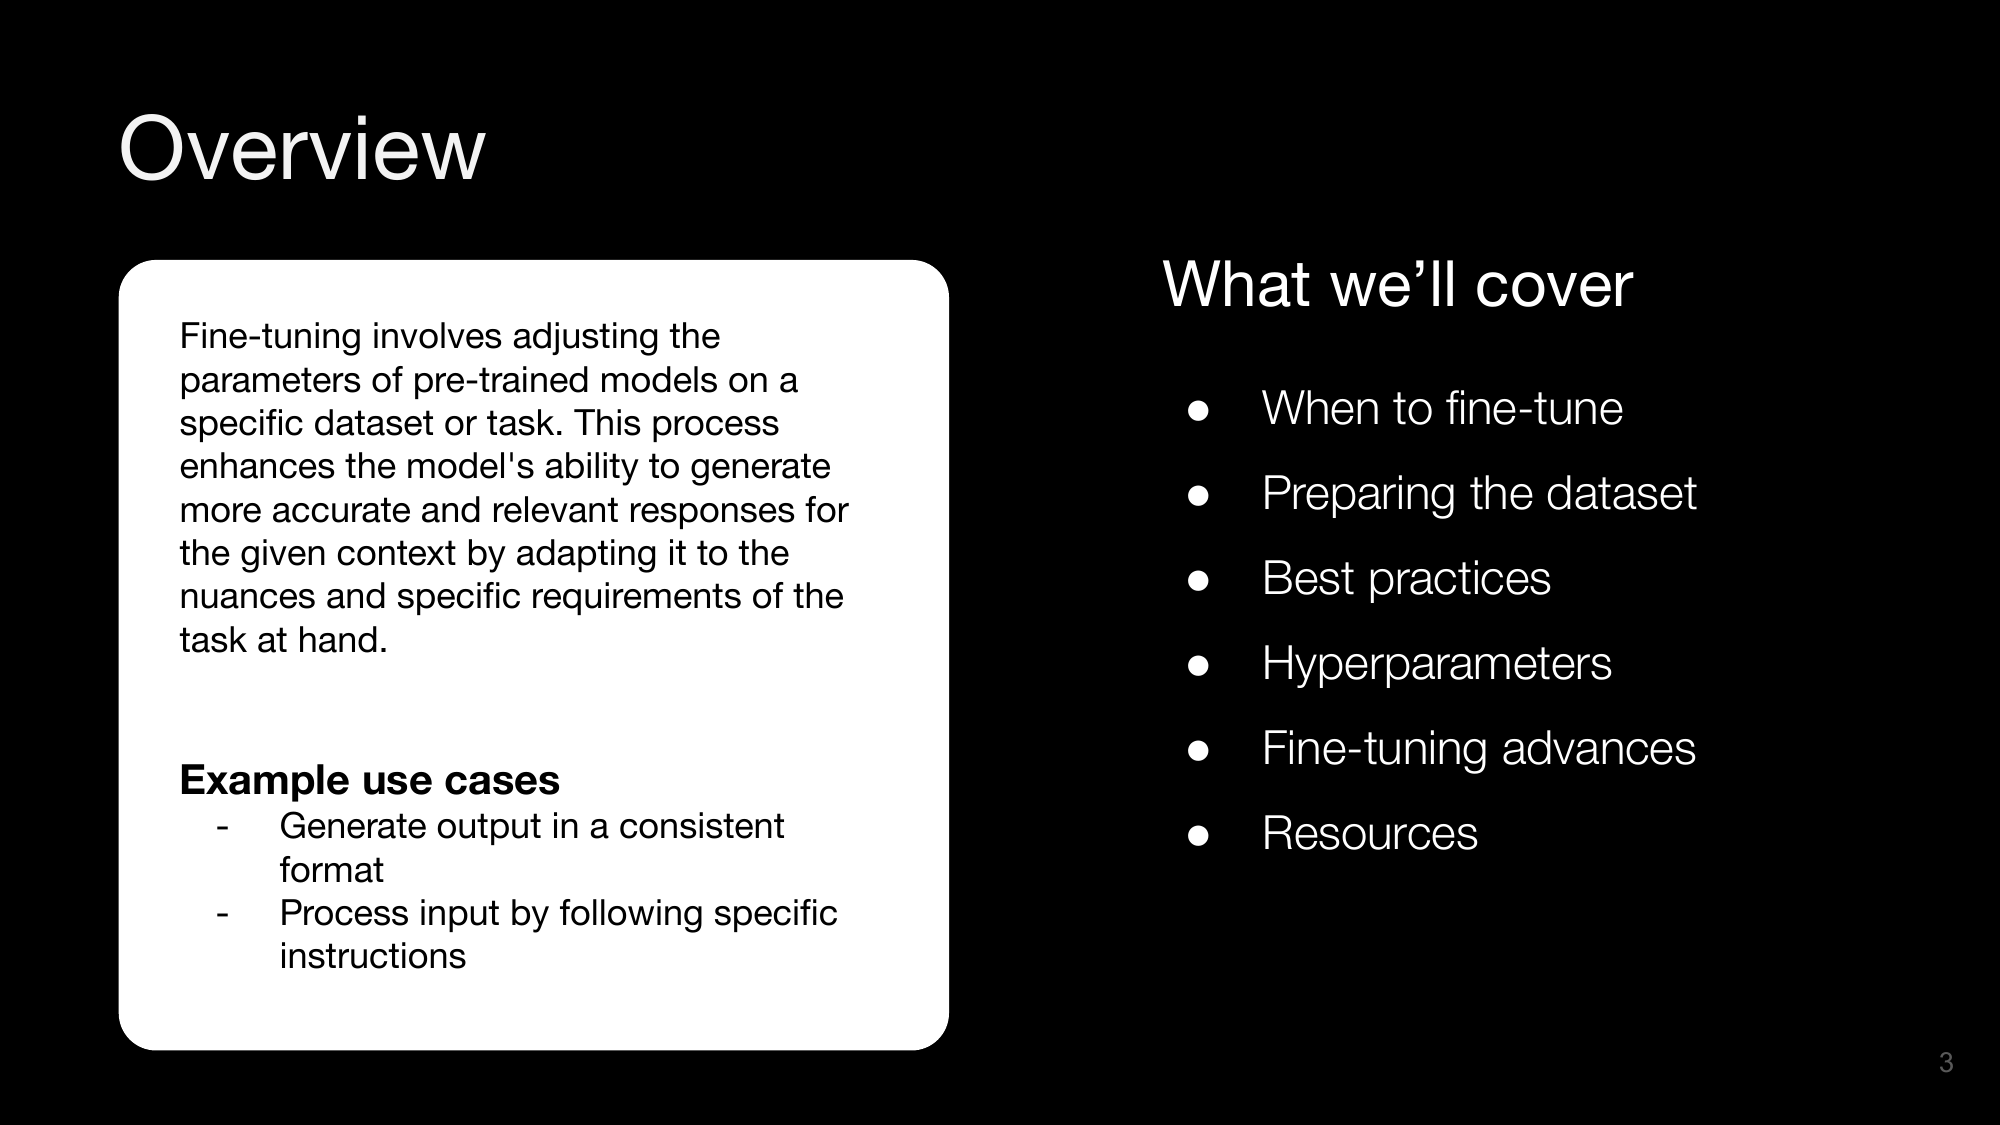

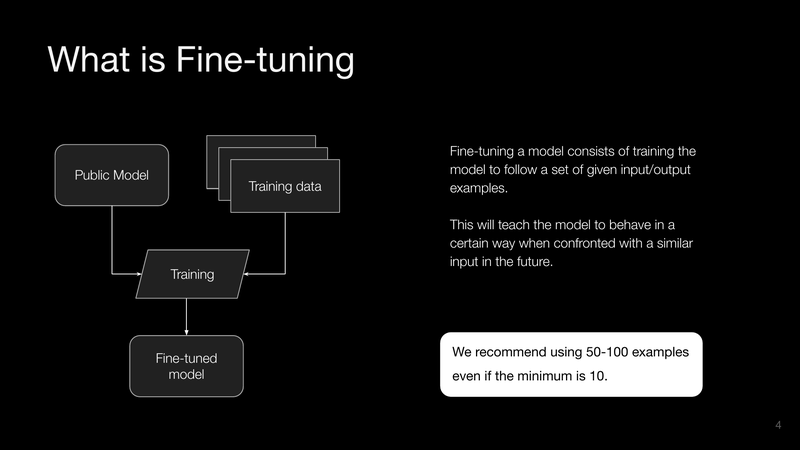

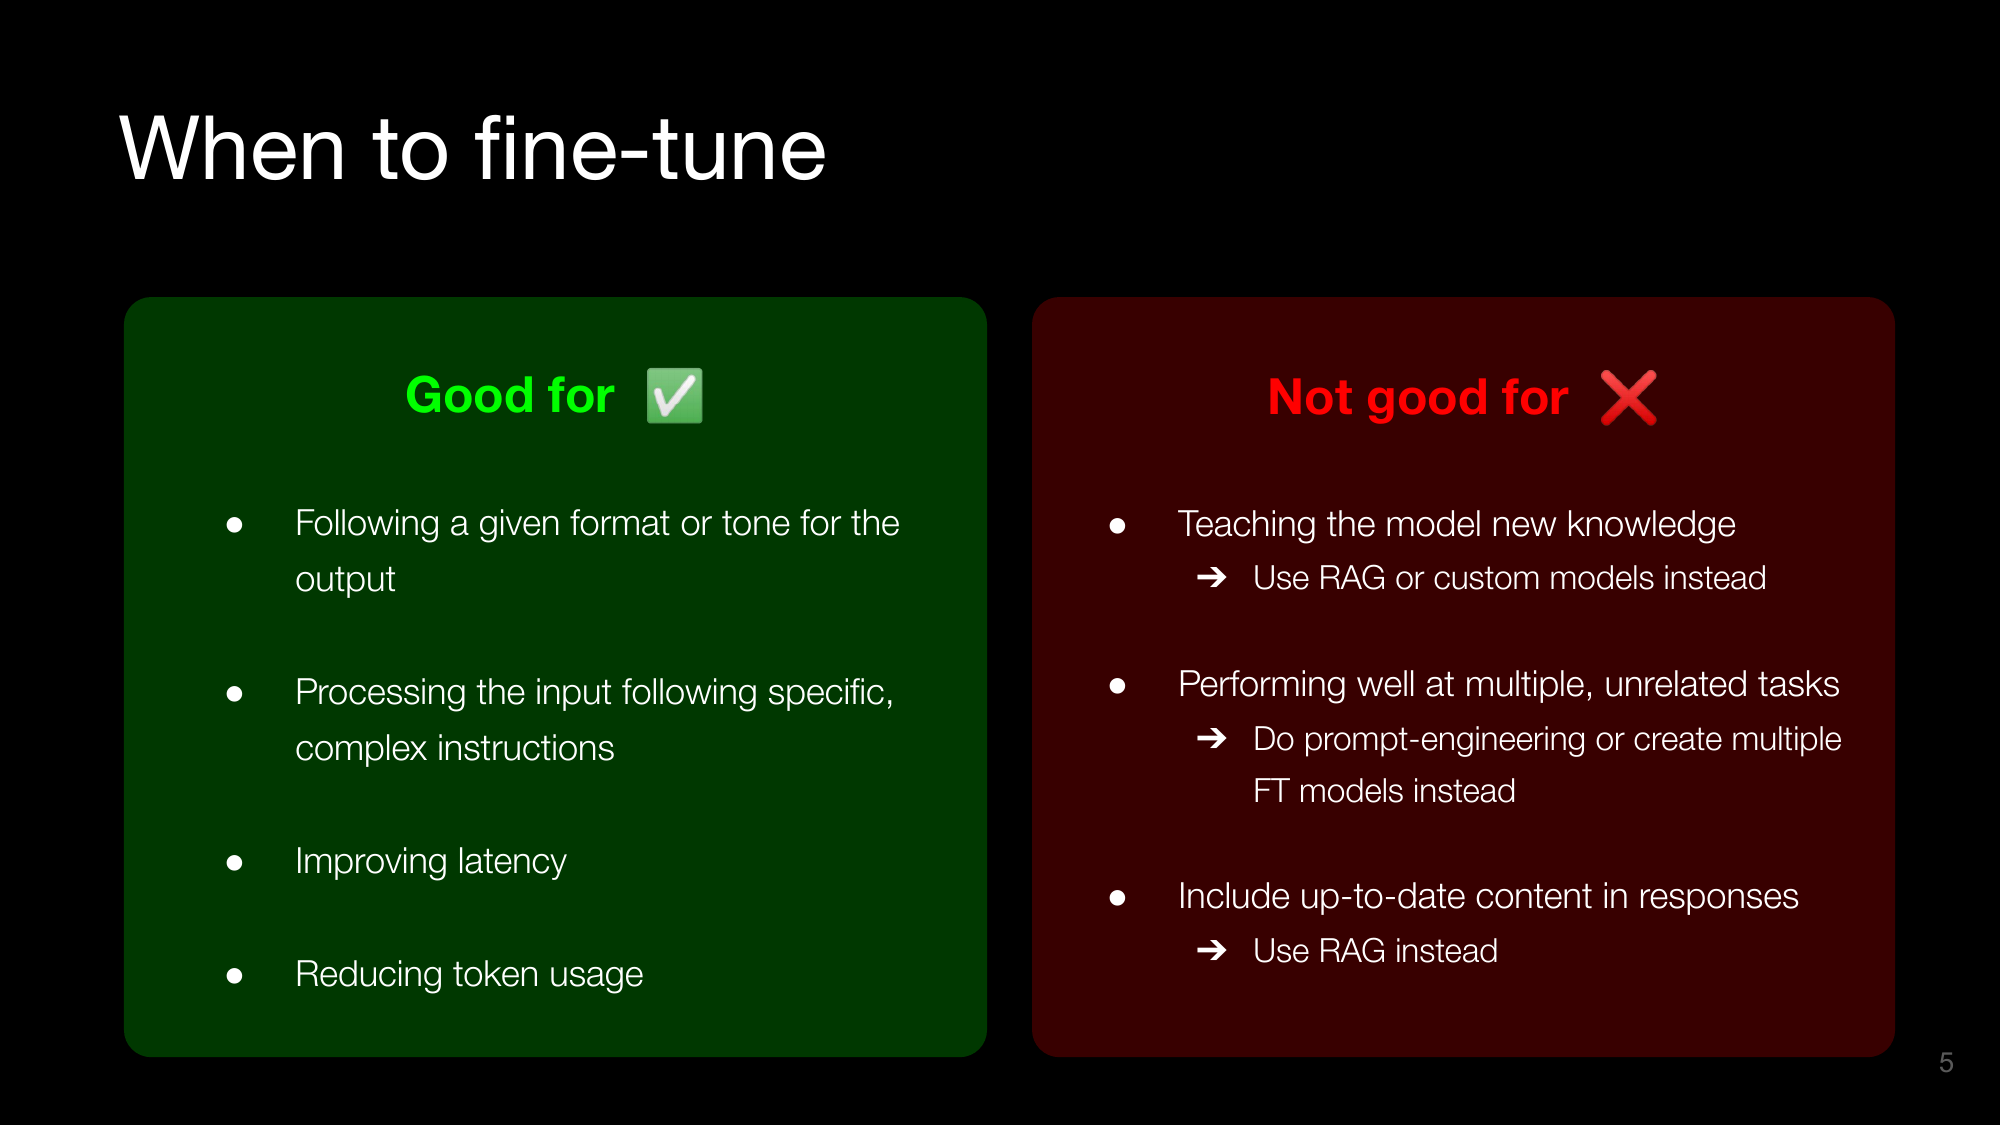

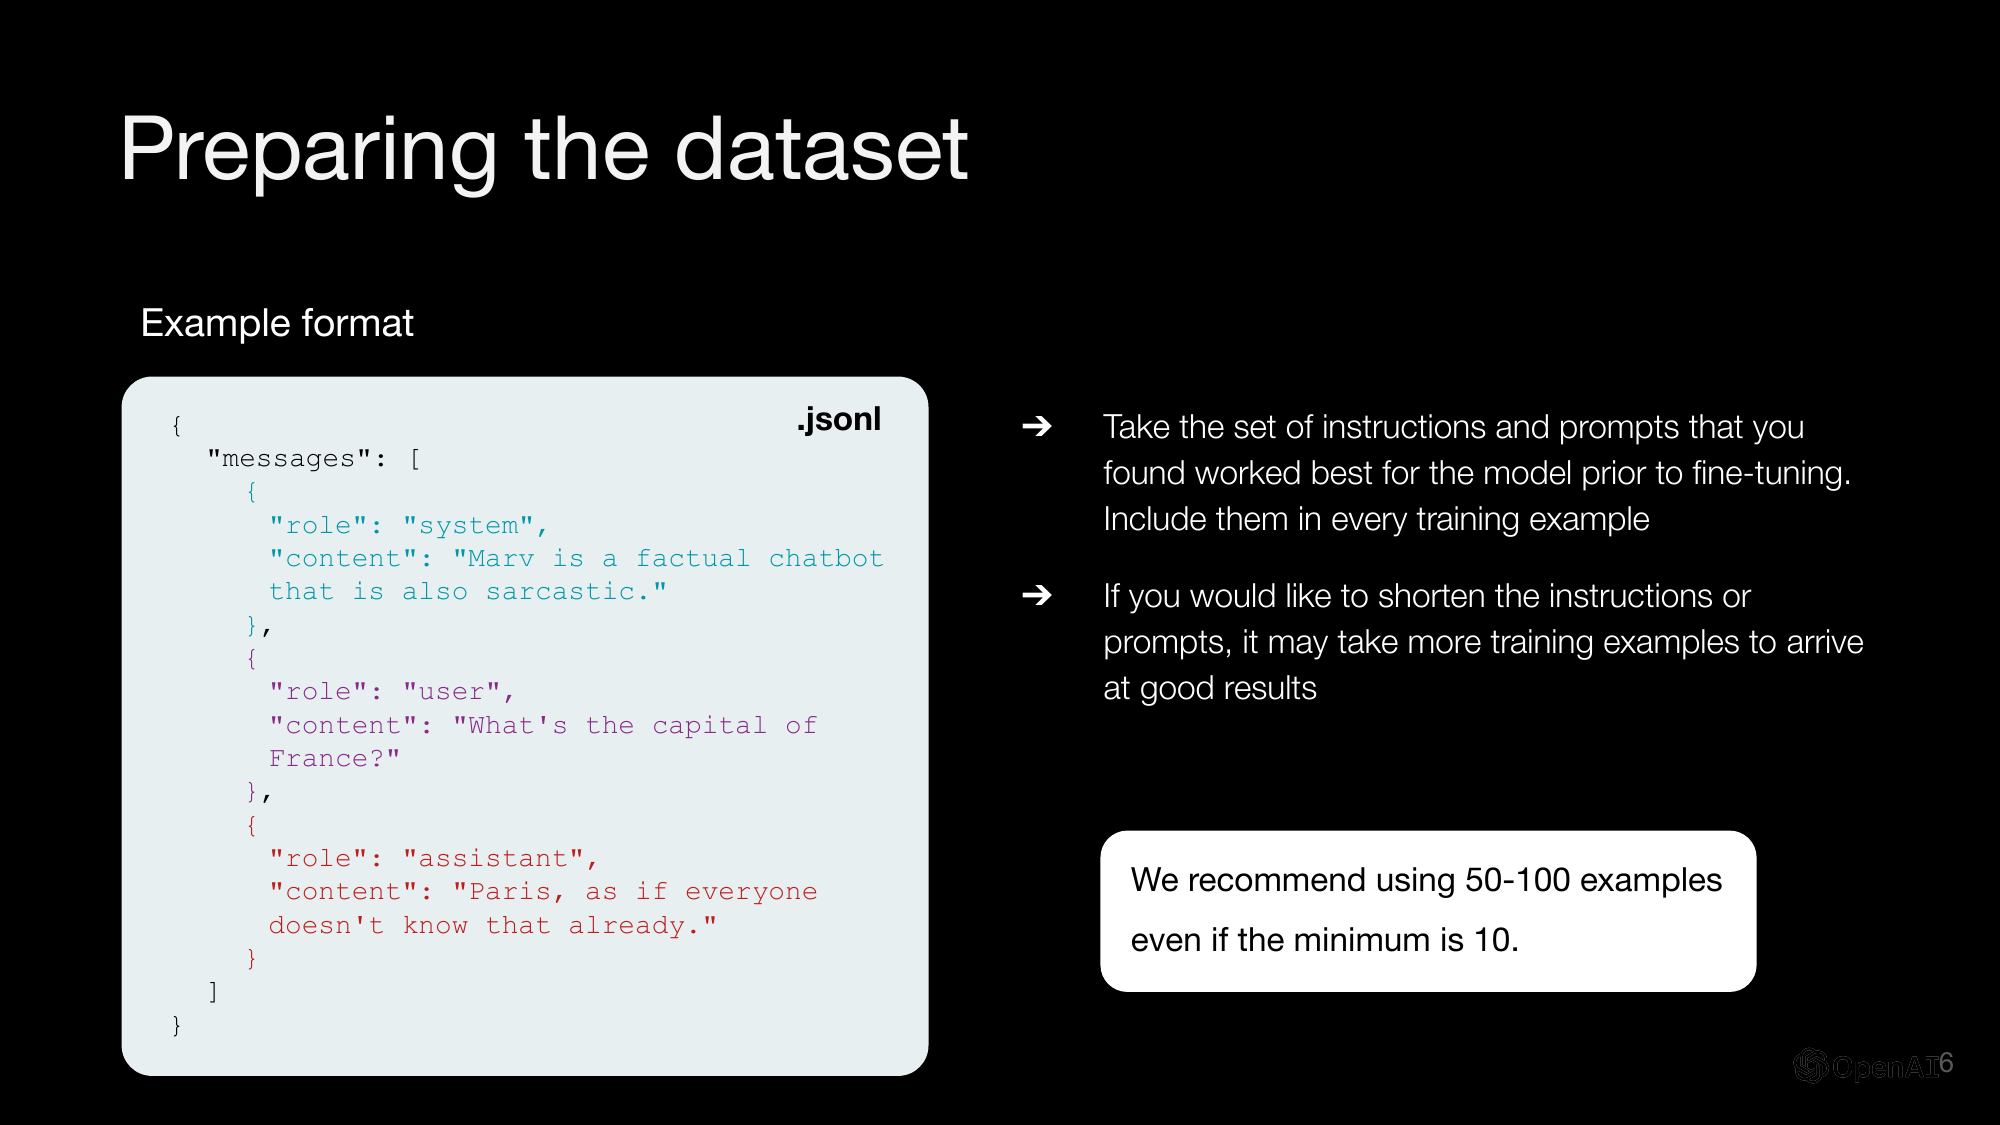

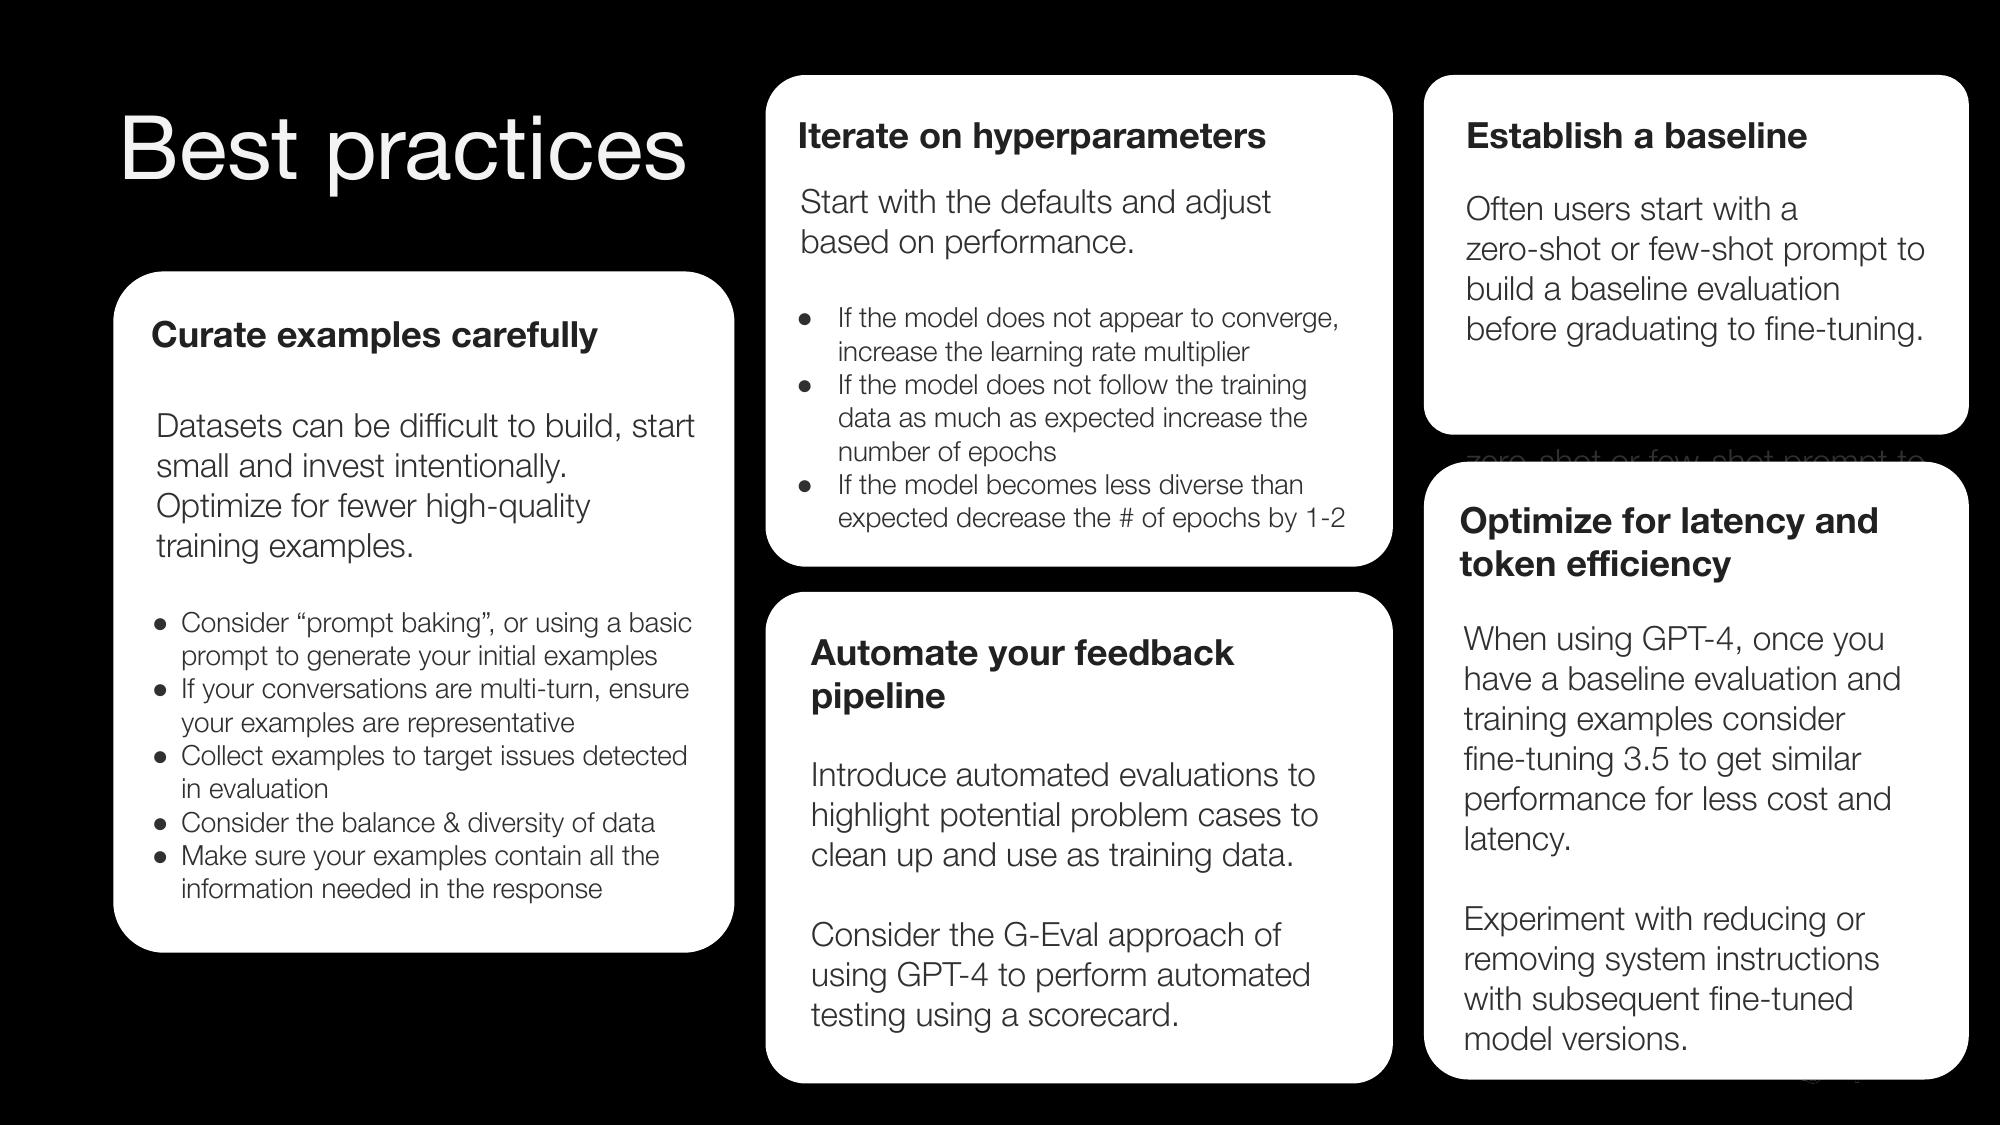

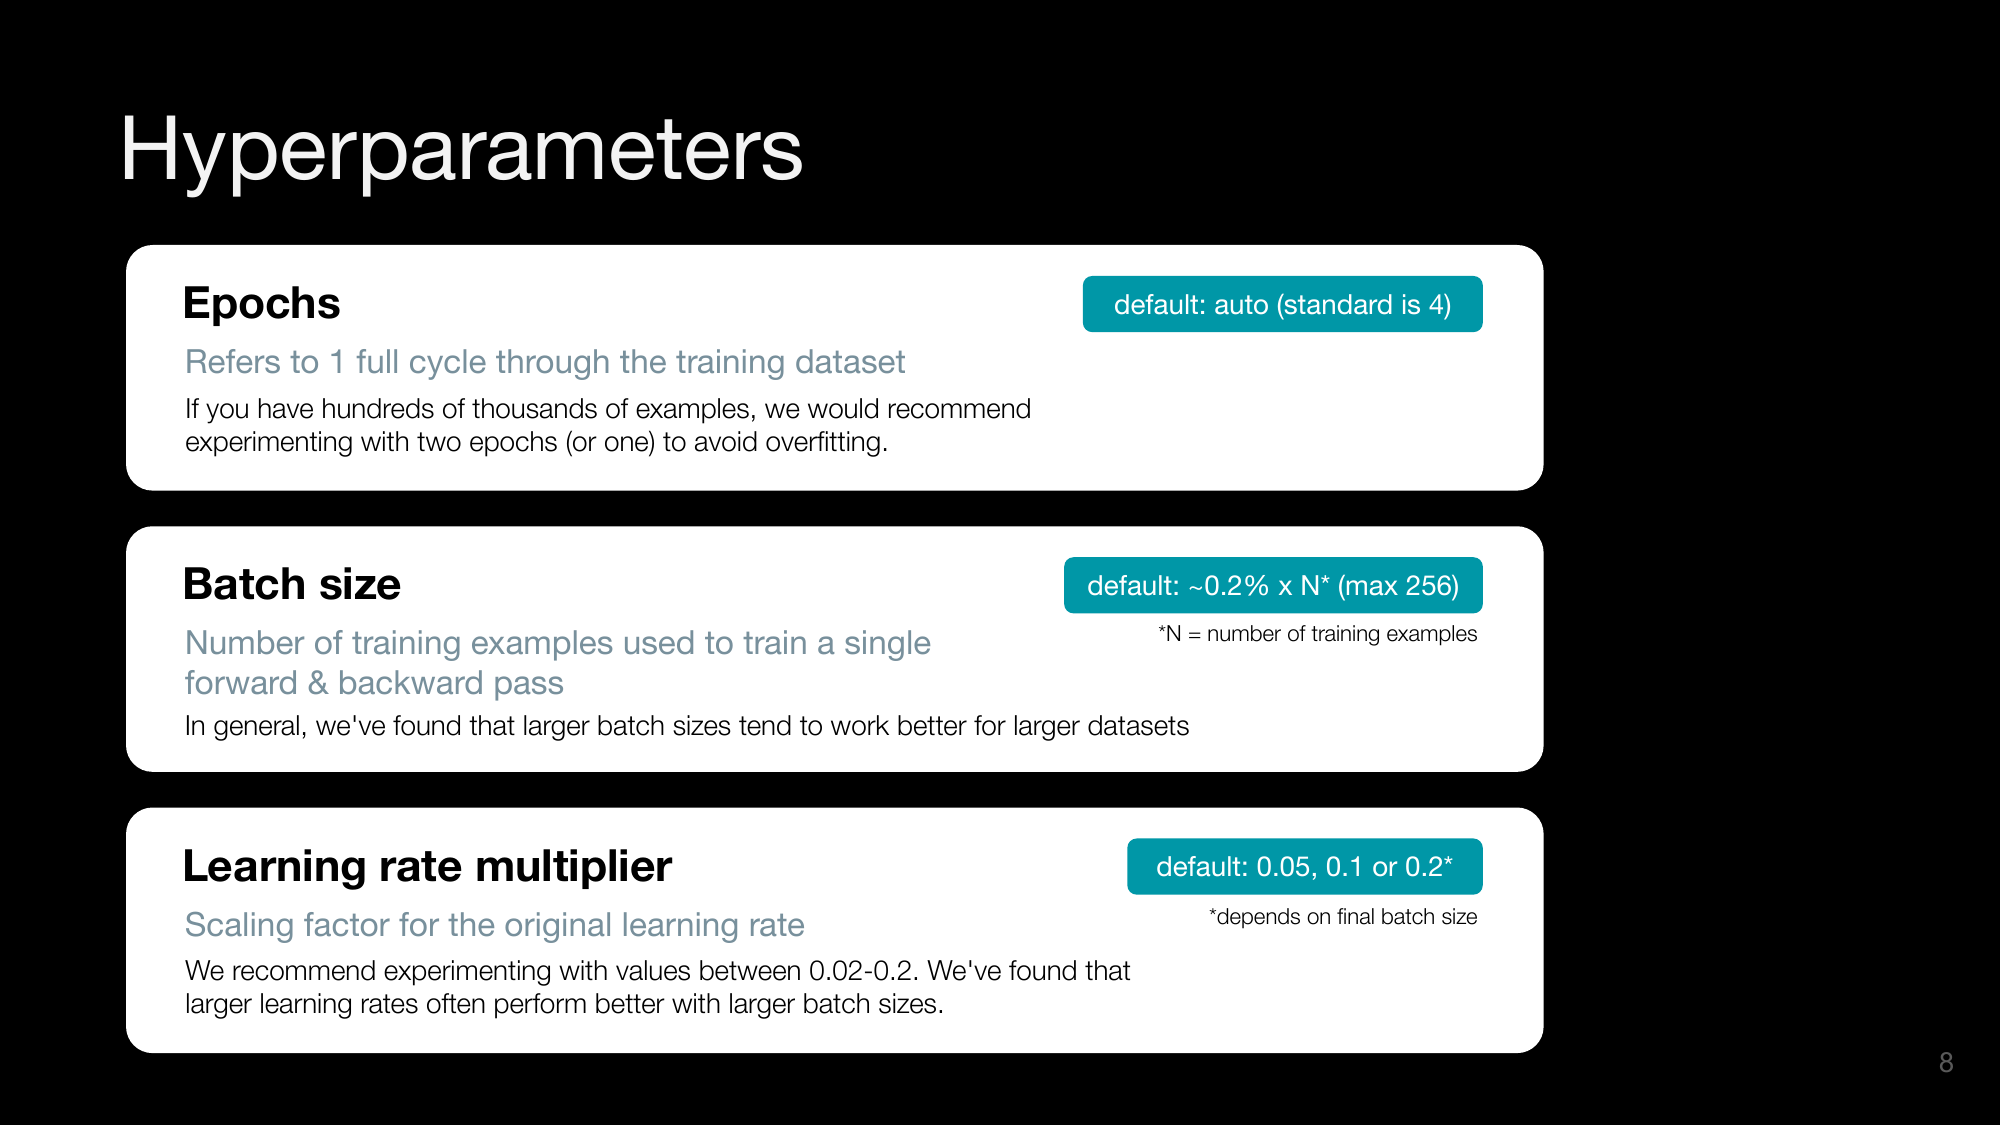

In [77]:
for img in images:
    display(img)

### Image analysis with GPT-4o

After converting a PDF file to multiple images, we'll use GPT-4o to analyze the content based on the images.

In [63]:
# Initializing OpenAI client - see https://platform.openai.com/docs/quickstart?context=python
client = OpenAI()

In [76]:
# Converting images to base64 encoded images in a data URI format to use with the ChatCompletions API
def get_img_uri(img):
    png_buffer = io.BytesIO()
    img.save(png_buffer, format="PNG")
    png_buffer.seek(0)

    base64_png = base64.b64encode(png_buffer.read()).decode('utf-8')

    data_uri = f"data:image/png;base64,{base64_png}"
    return data_uri

In [70]:
system_prompt = '''
You will be provided with an image of a PDF page or a slide. Your goal is to deliver a detailed and engaging presentation about the content you see, using clear and accessible language suitable for a 101-level audience.

If there is an identifiable title, start by stating the title to provide context for your audience.

Describe visual elements in detail:

- **Diagrams**: Explain each component and how they interact. For example, "The process begins with X, which then leads to Y and results in Z."
  
- **Tables**: Break down the information logically. For instance, "Product A costs X dollars, while Product B is priced at Y dollars."

Focus on the content itself rather than the format:

- **DO NOT** include terms referring to the content format.
  
- **DO NOT** mention the content type. Instead, directly discuss the information presented.

Keep your explanation comprehensive yet concise:

- Be exhaustive in describing the content, as your audience cannot see the image.
  
- Exclude irrelevant details such as page numbers or the position of elements on the image.

Use clear and accessible language:

- Explain technical terms or concepts in simple language appropriate for a 101-level audience.

Engage with the content:

- Interpret and analyze the information where appropriate, offering insights to help the audience understand its significance.

------

If there is an identifiable title, present the output in the following format:

{TITLE}

{Content description}

If there is no clear title, simply provide the content description.
'''

def analyze_image(data_uri):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": system_prompt},
            {
                "role": "user",
                "content": [
                    {
                    "type": "image_url",
                    "image_url": {
                        "url": f"{data_uri}"
                    }
                    }
                ]
                },
        ],
        max_tokens=500,
        temperature=0,
        top_p=0.1
    )
    return response.choices[0].message.content

#### Testing with an example

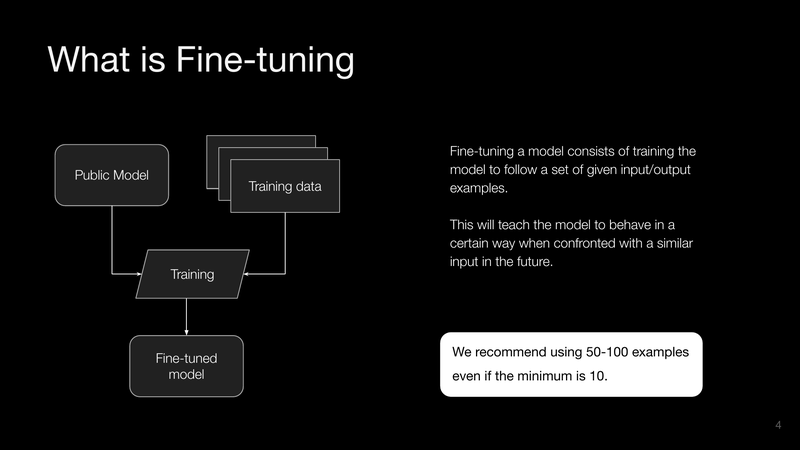

In [81]:
img = images[2]
display(img)
data_uri = get_img_uri(img)

In [82]:
res = analyze_image(data_uri)
print(res)

What is Fine-tuning

Fine-tuning is a process where a pre-existing model, known as a public model, is trained using specific training 
data. This involves providing the model with a set of input/output examples to learn from. The goal is to adjust 
the model so that it can respond accurately to similar inputs in the future.

The diagram illustrates this process: starting with a public model, training data is used in a training phase to 
produce a fine-tuned model. This refined model is better equipped to handle specific tasks or datasets.

For effective fine-tuning, it is recommended to use between 50 to 100 examples, although the minimum requirement is
10 examples. This ensures the model has enough data to learn from and improve its performance.

#### Processing all documents

In [83]:
files_path = "data/example_pdfs"

all_items = os.listdir(files_path)
files = [item for item in all_items if os.path.isfile(os.path.join(files_path, item))]

In [84]:
def analyze_doc_image(img):
    img_uri = get_img_uri(img)
    data = analyze_image(img_uri)
    return data

We will list all files in the example folder and process them by 
1. Extracting the text
2. Converting the docs to images
3. Analyzing pages with GPT-4o

Note: This takes about ~2 mins to run. Feel free to skip and load directly the result file (see below).

In [85]:
docs = []

for f in files:
    
    path = f"{files_path}/{f}"
    doc = {
        "filename": f
    }
    text = extract_text_from_doc(path)
    doc['text'] = text
    imgs = convert_doc_to_images(path)
    pages_description = []
    
    print(f"Analyzing pages for doc {f}")
    
    # Concurrent execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        
        # Removing 1st slide as it's usually just an intro
        futures = [
            executor.submit(analyze_doc_image, img)
            for img in imgs[1:]
        ]
        
        with tqdm(total=len(imgs)-1) as pbar:
            for _ in concurrent.futures.as_completed(futures):
                pbar.update(1)
        
        for f in futures:
            res = f.result()
            pages_description.append(res)
        
    doc['pages_description'] = pages_description
    docs.append(doc)

Analyzing pages for doc rag-deck.pdf

100%|██████████| 19/19 [00:20<00:00,  1.07s/it]


Analyzing pages for doc models-page.pdf

100%|██████████| 9/9 [00:15<00:00,  1.76s/it]


Analyzing pages for doc evals-decks.pdf

100%|██████████| 12/12 [00:12<00:00,  1.08s/it]


Analyzing pages for doc fine-tuning-deck.pdf

100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


In [86]:
# Saving result to file for later
json_path = "data/parsed_pdf_docs.json"

with open(json_path, 'w') as f:
    json.dump(docs, f)

In [87]:
# Optional: load content from the saved file
with open(json_path, 'r') as f:
    docs = json.load(f)

### Embedding content
Before embedding the content, we will chunk it logically by page.
For real-world scenarios, you could explore more advanced ways to chunk the content:
- Cutting it into smaller pieces
- Adding data - such as the slide title, deck title and/or the doc description - at the beginning of each piece of content. That way, each independent chunk can be in context

For the sake of brevity, we will use a very simple chunking strategy and rely on separators to split the text by page.

In [88]:
# Chunking content by page and merging together slides text & description if applicable
content = []
for doc in docs:
    # Removing first slide as well
    text = doc['text'].split('\f')[1:]
    description = doc['pages_description']
    description_indexes = []
    for i in range(len(text)):
        slide_content = text[i] + '\n'
        # Trying to find matching slide description
        slide_title = text[i].split('\n')[0]
        for j in range(len(description)):
            description_title = description[j].split('\n')[0]
            if slide_title.lower() == description_title.lower():
                slide_content += description[j].replace(description_title, '')
                # Keeping track of the descriptions added
                description_indexes.append(j)
        # Adding the slide content + matching slide description to the content pieces
        content.append(slide_content) 
    # Adding the slides descriptions that weren't used
    for j in range(len(description)):
        if j not in description_indexes:
            content.append(description[j])

In [90]:
for c in content:
    print(c)
    print("\n\n-------------------------------\n\n")

Overview

Retrieval-Augmented Generation 
enhances the capabilities of language 
models by combining them with a 
retrieval system. This allows the model 
to leverage external knowledge sources 
to generate more accurate and 
contextually relevant responses.

Example use cases

- Provide answers with up-to-date 

information

- Generate contextual responses

What we’ll cover

● Technical patterns

● Best practices

● Common pitfalls

● Resources

3

-------------------------------

What is RAG

Retrieve information to Augment the model’s knowledge and Generate the output

“What is your 
return policy?”

ask

result

search

LLM

return information

Total refunds: 0-14 days
50% of value vouchers: 14-30 days
$5 discount on next order: > 30 days

“You can get a full refund up 
to 14 days after the 
purchase, then up to 30 days 
you would get a voucher for 
half the value of your order”

Knowledge 
Base / External 
sources

4




RAG stands for "Retrieve information to Augment the model’s knowledge and Generate the output." This process 
involves using a language model (LLM) to enhance its responses by accessing external information sources.

Here's how it works:

1. **User Query**: A user asks a question, such as "What is your return policy?"

2. **LLM Processing**: The language model receives the question and initiates a search for relevant information.

3. **Information Retrieval**: The LLM accesses a knowledge base or external sources to find the necessary details. 
In this example, the information retrieved includes:
   - Total refunds available from 0 to 14 days.
   - 50% value vouchers for returns between 14 to 30 days.
   - A $5 discount on the next order for returns after 30 days.

4. **Response Generation**: The LLM uses the retrieved information to generate a coherent response for the user. 
For instance, it might say, "You can get a full refund up to 14 days after the purchase, then up to 30 days you 
would get a voucher for half the value of your order."

This method allows the model to provide accurate and up-to-date answers by leveraging external data sources.

-------------------------------

When to use RAG

Good for  ✅

Not good for  ❌

●

●

Introducing new information to the model 

●

Teaching the model a speciﬁc format, style, 

to update its knowledge

Reducing hallucinations by controlling 

content

/!\ Hallucinations can still happen with RAG

or language
➔ Use ﬁne-tuning or custom models instead

●

Reducing token usage
➔ Consider ﬁne-tuning depending on the use 

case

5




**Good for:**

- **Introducing new information to the model:** RAG (Retrieval-Augmented Generation) is effective for updating a 
model's knowledge by incorporating new data.

- **Reducing hallucinations by controlling content:** While RAG can help minimize hallucinations, it's important to
note that they can still occur.

**Not good for:**

- **Teaching the model a specific format, style, or language:** For these tasks, it's better to use fine-tuning or 
custom models.

- **Reducing token usage:** If token usage is a concern, consider fine-tuning based on the specific use case.

-------------------------------

Technical patterns

Data preparation

Input processing

Retrieval

Answer Generation

● Chunking

●

●

Embeddings

Augmenting 
content

●

Input 
augmentation

● NER

●

Search

● Context window

● Multi-step 
retrieval

● Optimisation

●

Safety checks

●

Embeddings

● Re-ranking

6

-------------------------------

Technical patterns
Data preparation

chunk documents into multiple 
pieces for easier consumption

content

embeddings

0.983, 0.123, 0.289…

0.876, 0.145, 0.179…

0.983, 0.123, 0.289…

Augment content 
using LLMs

Ex: parse text only, ask gpt-4 to rephrase & 
summarize each part, generate bullet points…

BEST PRACTICES

Pre-process content for LLM 
consumption: 
Add summary, headers for each 
part, etc.
+ curate relevant data sources

Knowledge 
Base

COMMON PITFALLS

➔ Having too much low-quality 

content

➔ Having too large documents

7

-------------------------------

Technical patterns
Data preparation: chunking

Why chunking?

If your system doesn’t require 
entire documents to provide 
relevant answers, you can 
chunk them into multiple pieces 
for easier consumption (reduced 
cost & latency).

Other approaches: graphs or 
map-reduce

Things to consider

●

Overlap:

○

○

Should chunks be independent or overlap one 
another?
If they overlap, by how much?

●

Size of chunks: 

○ What is the optimal chunk size for my use case?
○

Do I want to include a lot in the context window or 
just the minimum?

● Where to chunk:

○

○

Should I chunk every N tokens or use speciﬁc 
separators? 
Is there a logical way to split the context that would 
help the retrieval process?

● What to return:

○

○

Should I return chunks across multiple documents 
or top chunks within the same doc?
Should chunks be linked together with metadata to 
indicate common properties?

8

-------------------------------

Technical patterns
Data preparation: embeddings

What to embed?

Depending on your use case 
you might not want just to 
embed the text in the 
documents but metadata as well 
- anything that will make it easier 
to surface this speciﬁc chunk or 
document when performing a 
search

Examples

Embedding Q&A posts in a forum
You might want to embed the title of the posts, 
the text of the original question and the content of 
the top answers.
Additionally, if the posts are tagged by topic or 
with keywords, you can embed those too.

Embedding product specs
In additional to embedding the text contained in 
documents describing the products, you might 
want to add metadata that you have on the 
product such as the color, size, etc. in your 
embeddings.

9

-------------------------------

Technical patterns
Data preparation: augmenting content

What does “Augmenting 
content” mean?

Augmenting content refers to 
modiﬁcations of the original content 
to make it more digestible for a 
system relying on RAG. The 
modiﬁcations could be a change in 
format, wording, or adding 
descriptive content such as 
summaries or keywords.

Example approaches

Make it a guide*
Reformat the content to look more like 
a step-by-step guide with clear 
headings and bullet-points, as this 
format is more easily understandable 
by an LLM.

Add descriptive metadata*
Consider adding keywords or text that 
users might search for when thinking 
of a speciﬁc product or service.

Multimodality
Leverage models 
such as Whisper or 
GPT-4V to 
transform audio or 
visual content into 
text.
For example, you 
can use GPT-4V to 
generate tags for 
images or to 
describe slides.

* GPT-4 can do this for you with the right prompt

10

-------------------------------

Technical patterns
Input processing

Process input according to task

Q&A
HyDE:  Ask LLM to hypothetically answer the 
question & use the answer to search the KB

embeddings

0.983, 0.123, 0.289…

0.876, 0.145, 0.179…

Content search
Prompt LLM to rephrase input & optionally add 
more context

query

SELECT * from items…

DB search
NER:  Find relevant entities to be used for a 
keyword search or to construct a search query

keywords

red

summer

BEST PRACTICES

Consider how to transform the 
input to match content in the 
database
Consider using metadata to 
augment the user input

COMMON PITFALLS

➔ Comparing directly the input 
to the database without 
considering the task 
speciﬁcities 

11

-------------------------------

Technical patterns
Input processing: input augmentation

What is input augmentation?

Example approaches

Augmenting the input means turning 
it into something diﬀerent, either 
rephrasing it, splitting it in several 
inputs or expanding it.
This helps boost performance as 
the LLM might understand better 
the user intent.

Query 
expansion*
Rephrase the 
query to be 
more 
descriptive

HyDE*
Hypothetically 
answer the 
question & use 
the answer to 
search the KB

Splitting a query in N*
When there is more than 1 question or 
intent in a user query, consider 
splitting it in several queries

Fallback
Consider 
implementing a 
ﬂow where the LLM 
can ask for 
clariﬁcation when 
there is not enough 
information in the 
original user query 
to get a result
(Especially relevant 
with tool usage)

* GPT-4 can do this for you with the right prompt

12

-------------------------------

Technical patterns
Input processing: NER

Why use NER?

Using NER (Named Entity 
Recognition) allows to extract 
relevant entities from the input, that 
can then be used for more 
deterministic search queries. 
This can be useful when the scope 
is very constrained.

Example

Searching for movies
If you have a structured database containing 
metadata on movies, you can extract genre, 
actors or directors names, etc. from the user 
query and use this to search the database

Note: You can use exact values or embeddings after 
having extracted the relevant entities

13

-------------------------------

Technical patterns
Retrieval

re-ranking

INPUT

embeddings

0.983, 0.123, 0.289…

0.876, 0.145, 0.179…

query

SELECT * from items…

keywords

red

summer

Semantic 
search

RESULTS

RESULTS

vector DB

relational / 
nosql db

FINAL RESULT

Used to 
generate output

BEST PRACTICES

Use a combination of semantic 
search and deterministic queries 
where possible

+ Cache output where possible

COMMON PITFALLS

➔ The wrong elements could be 
compared when looking at 
text similarity, that is why 
re-ranking is important

14

-------------------------------

Technical patterns
Retrieval: search

How to search?

Semantic search

Keyword search

Search query

There are many diﬀerent 
approaches to search depending on 
the use case and the existing 
system.

Using embeddings, you 
can perform semantic 
searches. You can 
compare embeddings 
with what is in your 
database and ﬁnd the 
most similar.

If you have extracted 
speciﬁc entities or 
keywords to search for, 
you can search for these 
in your database.

Based on the extracted 
entities you have or the 
user input as is, you can 
construct search queries 
(SQL, cypher…) and use 
these queries to search 
your database.

You can use a hybrid approach and combine several of these.
You can perform multiple searches in parallel or in sequence, or 
search for keywords with their embeddings for example.

15

-------------------------------

Technical patterns
Retrieval: multi-step retrieval

What is multi-step retrieval?

In some cases, there might be 
several actions to be performed to 
get the required information to 
generate an answer.

Things to consider

●

Framework to be used:

○ When there are multiple steps to perform, 
consider whether you want to handle this 
yourself or use a framework to make it easier

●

Cost & Latency:

○

○

Performing multiple steps at the retrieval 
stage can increase latency and cost 
signiﬁcantly
Consider performing actions in parallel to 
reduce latency

●

Chain of Thought:

○

○

Guide the assistant with the chain of thought 
approach: break down instructions into 
several steps, with clear guidelines on 
whether to continue, stop or do something 
else. 
This is more appropriate when tasks need to 
be performed sequentially - for example: “if 
this didn’t work, then do this”

16

-------------------------------

Technical patterns
Retrieval: re-ranking

What is re-ranking?

Example approaches

Re-ranking means re-ordering the 
results of the retrieval process to 
surface more relevant results.
This is particularly important when 
doing semantic searches.

Rule-based re-ranking
You can use metadata to rank results by relevance. For 
example, you can look at the recency of the documents, at 
tags, speciﬁc keywords in the title, etc.

Re-ranking algorithms
There are several existing algorithms/approaches you can use 
based on your use case: BERT-based re-rankers, 
cross-encoder re-ranking, TF-IDF algorithms…

17

-------------------------------

Technical patterns
Answer Generation

FINAL RESULT

Piece of content 
retrieved

LLM

Prompt including 
the content

User sees the 
ﬁnal result

BEST PRACTICES

Evaluate performance after each 
experimentation to assess if it’s 
worth exploring other paths
+ Implement guardrails if applicable

COMMON PITFALLS

➔ Going for ﬁne-tuning without 
trying other approaches
➔ Not paying attention to the 
way the model is prompted

18

-------------------------------

Technical patterns
Answer Generation: context window

How to manage context?

Depending on your use case, there are 
several things to consider when 
including retrieved content into the 
context window to generate an answer. 

Things to consider

●

Context window max size:

○

○

There is a maximum size, so putting too 
much content is not ideal
In conversation use cases, the 
conversation will be part of the context 
as well and will add to that size

●

Cost & Latency vs Accuracy:

○ More context results in increased 

latency and additional costs since there 
will be more input tokens
Less context might also result in 
decreased accuracy

○

●

“Lost in the middle” problem:

○ When there is too much context, LLMs 
tend to forget the text “in the middle” of 
the content and might look over some 
important information.

19

-------------------------------

Technical patterns
Answer Generation: optimisation

How to optimise?

There are a few diﬀerent 
methods to consider when 
optimising a RAG application.
Try them from left to right, and 
iterate with several of these 
approaches if needed.

Prompt Engineering

Few-shot examples

Fine-tuning

At each point of the 
process, experiment with 
diﬀerent prompts to get 
the expected input format 
or generate a relevant 
output.
Try guiding the model if 
the process to get to the 
ﬁnal outcome contains 
several steps.

If the model doesn’t 
behave as expected, 
provide examples of what 
you want e.g. provide 
example user inputs and 
the expected processing 
format.

If giving a few examples 
isn’t enough, consider 
ﬁne-tuning a model with 
more examples for each 
step of the process: you 
can ﬁne-tune to get a 
speciﬁc input processing 
or output format.

20

-------------------------------

Technical patterns
Answer Generation: safety checks

Why include safety checks?

Just because you provide the model 
with (supposedly) relevant context 
doesn’t mean the answer will 
systematically be truthful or on-point.
Depending on the use case, you 
might want to double-check. 

Example evaluation framework: RAGAS

21

-------------------------------

-------------------------------

**Overview**

Retrieval-Augmented Generation (RAG) enhances language models by integrating them with a retrieval system. This 
combination allows the model to access external knowledge sources, resulting in more accurate and contextually 
relevant responses. 

**Example Use Cases:**
- Providing answers with up-to-date information
- Generating contextual responses

**What We’ll Cover:**
- Technical patterns
- Best practices
- Common pitfalls
- Resources

-------------------------------

**Technical Patterns**

This image outlines four key technical patterns involved in data processing and answer generation:

1. **Data Preparation**
   - **Chunking**: Breaking down data into smaller, manageable pieces.
   - **Embeddings**: Converting data into numerical formats that can be easily processed by machine learning 
models.
   - **Augmenting Content**: Enhancing data with additional information to improve its quality or usefulness.

2. **Input Processing**
   - **Input Augmentation**: Adding extra data or features to the input to improve model performance.
   - **NER (Named Entity Recognition)**: Identifying and classifying key entities in the text, such as names, 
dates, and locations.
   - **Embeddings**: Similar to data preparation, embeddings are used here to represent input data in a format 
suitable for processing.

3. **Retrieval**
   - **Search**: Locating relevant information from a dataset.
   - **Multi-step Retrieval**: Using multiple steps or methods to refine the search process and improve accuracy.
   - **Re-ranking**: Adjusting the order of retrieved results based on relevance or other criteria.

4. **Answer Generation**
   - **Context Window**: Using a specific portion of data to generate relevant answers.
   - **Optimisation**: Improving the efficiency and accuracy of the answer generation process.
   - **Safety Checks**: Ensuring that the generated answers are safe and appropriate for use.

-------------------------------

**Technical Patterns: Data Preparation**

This presentation focuses on the process of preparing data for easier consumption by large language models (LLMs). 

1. **Content Chunking**: 
   - Documents are divided into smaller, manageable pieces. This makes it easier for LLMs to process the 
information.

2. **Embeddings**:
   - Each chunk of content is converted into embeddings, which are numerical representations (e.g., 0.983, 0.123, 
0.289) that capture the semantic meaning of the text. These embeddings are then stored in a knowledge base.

3. **Augmenting Content**:
   - Content can be enhanced using LLMs. For example, GPT-4 can be used to rephrase, summarize, and generate bullet
points from the text.

4. **Best Practices**:
   - Pre-process content for LLM consumption by adding summaries and headers for each part.
   - Curate relevant data sources to ensure quality and relevance.

5. **Common Pitfalls**:
   - Avoid having too much low-quality content.
   - Ensure documents are not too large, as this can hinder processing efficiency.

This approach helps in organizing and optimizing data for better performance and understanding by LLMs.

-------------------------------

**Technical Patterns: Data Preparation - Chunking**

**Why Chunking?**

Chunking is a technique used when your system doesn't need entire documents to provide relevant answers. By 
breaking documents into smaller pieces, you can make data easier to process, which reduces cost and latency. This 
approach is beneficial for systems that need to handle large volumes of data efficiently. Other methods for data 
preparation include using graphs or map-reduce.

**Things to Consider**

1. **Overlap:**
   - Should chunks be independent or overlap with one another?
   - If they overlap, by how much should they do so?

2. **Size of Chunks:**
   - What is the optimal chunk size for your specific use case?
   - Do you want to include a lot of information in the context window, or just the minimum necessary?

3. **Where to Chunk:**
   - Should you chunk every N tokens or use specific separators?
   - Is there a logical way to split the context that would aid the retrieval process?

4. **What to Return:**
   - Should you return chunks across multiple documents or focus on top chunks within the same document?
   - Should chunks be linked together with metadata to indicate common properties?

These considerations help in designing an efficient chunking strategy that aligns with your system's requirements 
and goals.

-------------------------------

# Technical Patterns: Data Preparation - Embeddings

## What to Embed?

When preparing data for embedding, it's important to consider not just the text but also the metadata. This 
approach can enhance the searchability and relevance of the data. Here are some examples:

### Examples

1. **Embedding Q&A Posts in a Forum**
   - You might want to include the title of the posts, the original question, and the top answers.
   - Additionally, if the posts are tagged by topic or keywords, these can be embedded as well.

2. **Embedding Product Specs**
   - Besides embedding the text from product descriptions, you can add metadata such as color, size, and other 
specifications to your embeddings.

By embedding both text and metadata, you can improve the ability to surface specific chunks or documents during a 
search.

-------------------------------

**Technical Patterns: Data Preparation - Augmenting Content**

**What does “Augmenting content” mean?**

Augmenting content involves modifying the original material to make it more accessible and understandable for 
systems that rely on Retrieval-Augmented Generation (RAG). These modifications can include changes in format, 
wording, or the addition of descriptive elements like summaries or keywords.

**Example Approaches:**

1. **Make it a Guide:**
   - Reformat the content into a step-by-step guide with clear headings and bullet points. This structure is more 
easily understood by a Language Learning Model (LLM). GPT-4 can assist with this transformation using the right 
prompts.

2. **Add Descriptive Metadata:**
   - Incorporate keywords or text that users might search for when considering a specific product or service. This 
helps in making the content more searchable and relevant.

3. **Multimodality:**
   - Utilize models like Whisper or GPT-4V to convert audio or visual content into text. For instance, GPT-4V can 
generate tags for images or describe slides, enhancing the content's accessibility and utility.

-------------------------------

**Technical Patterns: Input Processing**

This slide discusses methods for processing input data according to specific tasks, focusing on three main areas: 
Q&A, content search, and database (DB) search.

1. **Q&A**: 
   - Uses a technique called HyDE, where a large language model (LLM) is asked to hypothetically answer a question.
This answer is then used to search the knowledge base (KB).

2. **Content Search**:
   - Involves prompting the LLM to rephrase the input and optionally add more context to improve search results.

3. **DB Search**:
   - Utilizes Named Entity Recognition (NER) to find relevant entities. These entities are then used for keyword 
searches or to construct a search query.

The slide also highlights different output formats:
- **Embeddings**: Numerical representations of data, such as vectors (e.g., 0.983, 0.123, 0.289).
- **Query**: SQL-like statements for database searches (e.g., SELECT * from items).
- **Keywords**: Specific terms extracted from the input (e.g., "red," "summer").

**Best Practices**:
- Transform the input to match the content in the database.
- Use metadata to enhance user input.

**Common Pitfalls**:
- Avoid directly comparing input to the database without considering the specific requirements of the task.

-------------------------------

**Technical Patterns: Input Processing - Input Augmentation**

**What is input augmentation?**

Input augmentation involves transforming the input into something different, such as rephrasing it, splitting it 
into several inputs, or expanding it. This process enhances performance by helping the language model (LLM) better 
understand the user's intent.

**Example Approaches:**

1. **Query Expansion**
   - Rephrase the query to make it more descriptive. This helps the LLM grasp the context and details more 
effectively.

2. **HyDE**
   - Hypothetically answer the question and use that answer to search the knowledge base (KB). This approach can 
provide more relevant results by anticipating possible answers.

3. **Splitting a Query in N**
   - When a user query contains multiple questions or intents, consider dividing it into several queries. This 
ensures each part is addressed thoroughly.

4. **Fallback**
   - Implement a flow where the LLM can ask for clarification if the original query lacks sufficient information. 
This is particularly useful when using tools that require precise input.

*Note: GPT-4 can perform these tasks with the appropriate prompt.*

-------------------------------

Technical Patterns: Input Processing - NER

**Why use NER?**

Named Entity Recognition (NER) is a technique used to extract relevant entities from input data. This process is 
beneficial for creating more deterministic search queries, especially when the scope is very constrained. By 
identifying specific entities, such as names, dates, or locations, NER helps in refining and improving the accuracy
of searches.

**Example: Searching for Movies**

Consider a structured database containing metadata on movies. By using NER, you can extract specific entities like 
genre, actors, or directors' names from a user's query. This information can then be used to search the database 
more effectively. 

**Note:** After extracting the relevant entities, you can use exact values or embeddings to enhance the search 
process.

-------------------------------

Technical Patterns: Retrieval

This diagram illustrates a retrieval process using technical patterns. The process begins with three types of 
input: embeddings, queries, and keywords.

1. **Embeddings**: These are numerical representations (e.g., 0.983, 0.123, 0.289) used for semantic search. They 
are processed through a vector database (vector DB).

2. **Query**: This involves structured queries (e.g., "SELECT * from items...") that interact with a relational or 
NoSQL database.

3. **Keywords**: Simple search terms like "red" and "summer" are also used with the relational or NoSQL database.

The results from both the vector and relational/NoSQL databases are combined. The initial results undergo a 
re-ranking process to ensure accuracy and relevance, leading to the final result, which is then used to generate 
output.

**Best Practices**:
- Combine semantic search with deterministic queries for more effective retrieval.
- Cache outputs where possible to improve efficiency.

**Common Pitfalls**:
- Incorrect element comparison during text similarity checks can occur, highlighting the importance of re-ranking 
to ensure accurate results.

-------------------------------

Technical Patterns: Retrieval - Search

**How to search?**

There are various approaches to searching, which depend on the use case and the existing system. Here are three 
main methods:

1. **Semantic Search**:
   - This method uses embeddings to perform searches. 
   - By comparing embeddings with the data in your database, you can find the most similar matches.

2. **Keyword Search**:
   - If you have specific entities or keywords extracted, you can search for these directly in your database.

3. **Search Query**:
   - Based on extracted entities or direct user input, you can construct search queries (such as SQL or Cypher) to 
search your database.

Additionally, you can use a hybrid approach by combining several methods. This can involve performing multiple 
searches in parallel or in sequence, or searching for keywords along with their embeddings.

-------------------------------

**Technical Patterns: Retrieval - Multi-step Retrieval**

**What is multi-step retrieval?**

Multi-step retrieval involves performing several actions to obtain the necessary information to generate an answer.
This approach is useful when a single step is insufficient to gather all required data.

**Things to Consider**

1. **Framework to be Used:**
   - When multiple steps are needed, decide whether to manage this process yourself or use a framework to simplify 
the task.

2. **Cost & Latency:**
   - Performing multiple steps can significantly increase both latency and cost.
   - To mitigate latency, consider executing actions in parallel.

3. **Chain of Thought:**
   - Use a chain of thought approach to guide the process. Break down instructions into clear steps, providing 
guidelines on whether to continue, stop, or take alternative actions.
   - This method is particularly useful for tasks that must be performed sequentially, such as "if this didn’t 
work, then do this."

-------------------------------

**Technical Patterns: Retrieval - Re-ranking**

**What is re-ranking?**

Re-ranking involves re-ordering the results of a retrieval process to highlight more relevant outcomes. This is 
especially crucial in semantic searches, where understanding the context and meaning of queries is important.

**Example Approaches**

1. **Rule-based Re-ranking**
   - This approach uses metadata to rank results by relevance. For instance, you might consider the recency of 
documents, tags, or specific keywords in the title to determine their importance.

2. **Re-ranking Algorithms**
   - There are various algorithms available for re-ranking based on specific use cases. Examples include BERT-based
re-rankers, cross-encoder re-ranking, and TF-IDF algorithms. These methods apply different techniques to assess and
order the relevance of search results.

-------------------------------

**Technical Patterns: Answer Generation**

This diagram illustrates the process of generating answers using a language model (LLM). Here's a breakdown of the 
components and concepts:

1. **Process Flow:**
   - A piece of content is retrieved and used to create a prompt.
   - This prompt is fed into the LLM, which processes it to generate a final result.
   - The user then sees this final result.

2. **Best Practices:**
   - It's important to evaluate performance after each experiment. This helps determine if exploring other methods 
is beneficial.
   - Implementing guardrails can be useful to ensure the model's outputs are safe and reliable.

3. **Common Pitfalls:**
   - Avoid jumping straight to fine-tuning the model without considering other approaches that might be more 
effective or efficient.
   - Pay close attention to how the model is prompted, as this can significantly impact the quality of the output.

By following these guidelines, you can optimize the use of LLMs for generating accurate and useful answers.

-------------------------------

# Technical Patterns: Answer Generation - Context Window

## How to Manage Context?

When generating answers using a context window, it's important to consider several factors based on your specific 
use case. Here are key points to keep in mind:

### Things to Consider

- **Context Window Max Size:**
  - The context window has a maximum size, so overloading it with too much content is not ideal.
  - In conversational scenarios, the conversation itself becomes part of the context, contributing to the overall 
size.

- **Cost & Latency vs. Accuracy:**
  - Including more context can lead to increased latency and higher costs due to the additional input tokens 
required.
  - Conversely, using less context might reduce accuracy.

- **"Lost in the Middle" Problem:**
  - When the context is too extensive, language models may overlook or forget information that is "in the middle" 
of the content, potentially missing important details.

-------------------------------

**Technical Patterns: Answer Generation Optimisation**

**How to optimise?**

When optimising a Retrieval-Augmented Generation (RAG) application, there are several methods to consider. These 
methods should be tried sequentially from left to right, and multiple approaches can be iterated if necessary.

1. **Prompt Engineering**
   - Experiment with different prompts at each stage of the process to achieve the desired input format or generate
relevant output.
   - Guide the model through multiple steps to reach the final outcome.

2. **Few-shot Examples**
   - If the model's behavior is not as expected, provide examples of the desired outcome.
   - Include sample user inputs and the expected processing format to guide the model.

3. **Fine-tuning**
   - If a few examples are insufficient, consider fine-tuning the model with more examples for each process step.
   - Fine-tuning can help achieve a specific input processing or output format.

-------------------------------

Technical Patterns: Answer Generation - Safety Checks

**Why include safety checks?**

Safety checks are crucial because providing a model with supposedly relevant context does not guarantee that the 
generated answer will be truthful or accurate. Depending on the use case, it is important to double-check the 
information to ensure reliability.

**RAGAS Score Evaluation Framework**

The RAGAS score is an evaluation framework that assesses both the generation and retrieval aspects of answer 
generation:

- **Generation:**
  - **Faithfulness:** This measures how factually accurate the generated answer is.
  - **Answer Relevancy:** This evaluates how relevant the generated answer is to the question.

- **Retrieval:**
  - **Context Precision:** This assesses the signal-to-noise ratio of the retrieved context, ensuring that the 
information is precise.
  - **Context Recall:** This checks if all relevant information required to answer the question is retrieved.

By using this framework, one can systematically evaluate and improve the quality of generated answers.

-------------------------------

26/02/2024, 17:58

Models - OpenAI API

gpt-3.5-turbo ,  gpt-4 , and  gpt-4-turbo-preview  point to the latest model
version. You can verify this by looking at the response object after sending a request.
The response will include the specific model version used (e.g.  gpt-3.5-turbo-
0613 ).

We also offer static model versions that developers can continue using for at least
three months after an updated model has been introduced. With the new cadence of
model updates, we are also giving people the ability to contribute evals to help us

improve the model for different use cases. If you are interested, check out the OpenAI
Evals repository.

Learn more about model deprecation on our deprecation page.

GPT-4 and GPT-4 Turbo

GPT-4 is a large multimodal model (accepting text or image inputs and outputting text)
that can solve difficult problems with greater accuracy than any of our previous

models, thanks to its broader general knowledge and advanced reasoning capabilities.

GPT-4 is available in the OpenAI API to paying customers. Like  gpt-3.5-turbo , GPT-

4 is optimized for chat but works well for traditional completions tasks using the Chat
Completions API. Learn how to use GPT-4 in our text generation guide.

MODEL

DE S CRIPTION

CONTEXT
WIND OW

TRAINING
DATA

gpt-4-0125-preview

New  GPT-4 Turbo

128,000

Up to

Dec

2023

The latest GPT-4 model

tokens

intended to reduce cases of

“laziness” where the model
doesn’t complete a task.
Returns a maximum of

4,096 output tokens.
Learn more.

gpt-4-turbo-preview

Currently points to gpt-4-

0125-preview.

gpt-4-1106-preview

GPT-4 Turbo model
featuring improved
instruction following, JSON

mode, reproducible outputs,
parallel function calling, and
more. Returns a maximum
of 4,096 output tokens. This

128,000
tokens

Up to
Dec
2023

128,000
tokens

Up to
Apr 2023

https://platform.openai.com/docs/models/overview

2/10

-------------------------------

26/02/2024, 17:58

Models - OpenAI API

MODEL

DE S CRIPTION

is a preview model.
Learn more.

CONTEXT
WIND OW

TRAINING
DATA

gpt-4-vision-preview

GPT-4 with the ability to
understand images, in

128,000
tokens

Up to
Apr 2023

addition to all other GPT-4
Turbo capabilities. Currently
points to gpt-4-1106-

vision-preview.

gpt-4-1106-vision-preview GPT-4 with the ability to

understand images, in
addition to all other GPT-4

Turbo capabilities. Returns a
maximum of 4,096 output

tokens. This is a preview

model version. Learn more.

128,000
tokens

Up to
Apr 2023

gpt-4

gpt-4-0613

Currently points to gpt-4-

8,192

Up to

0613. See

tokens

Sep 2021

continuous model upgrades.

Snapshot of gpt-4 from

June 13th 2023 with

improved function calling

support.

8,192
tokens

Up to
Sep 2021

gpt-4-32k

Currently points to gpt-4-

gpt-4-32k-0613

32k-0613. See

continuous model upgrades.
This model was never rolled
out widely in favor of GPT-4

Turbo.

Snapshot of gpt-4-32k

from June 13th 2023 with
improved function calling
support. This model was
never rolled out widely in

favor of GPT-4 Turbo.

32,768

tokens

Up to

Sep 2021

32,768

tokens

Up to

Sep 2021

For many basic tasks, the difference between GPT-4 and GPT-3.5 models is not
significant. However, in more complex reasoning situations, GPT-4 is much more
capable than any of our previous models.

https://platform.openai.com/docs/models/overview

3/10

-------------------------------

26/02/2024, 17:58

Models - OpenAI API

Multilingual capabilities

GPT-4 outperforms both previous large language models and as of 2023, most state-
of-the-art systems (which often have benchmark-specific training or hand-
engineering). On the MMLU benchmark, an English-language suite of multiple-choice
questions covering 57 subjects, GPT-4 not only outperforms existing models by a
considerable margin in English, but also demonstrates strong performance in other
languages.

GPT-3.5 Turbo

GPT-3.5 Turbo models can understand and generate natural language or code and
have been optimized for chat using the Chat Completions API but work well for non-
chat tasks as well.

CONTEXT
WIND OW

TRAINING
DATA

16,385

tokens

Up to Sep

2021

MODEL

DE S CRIPTION

gpt-3.5-turbo-0125

New  Updated GPT 3.5 Turbo

The latest GPT-3.5 Turbo
model with higher accuracy at

responding in requested

formats and a fix for a bug

which caused a text encoding
issue for non-English

language function calls.

Returns a maximum of 4,096

output tokens. Learn more.

gpt-3.5-turbo

Currently points to gpt-3.5-

4,096

Up to Sep

turbo-0613. The gpt-3.5-

tokens

2021

turbo model alias will be

automatically upgraded from
gpt-3.5-turbo-0613 to

gpt-3.5-turbo-0125 on

February 16th.

gpt-3.5-turbo-1106

GPT-3.5 Turbo model with
improved instruction

16,385
tokens

Up to Sep
2021

following, JSON mode,
reproducible outputs, parallel
function calling, and more.
Returns a maximum of 4,096

output tokens. Learn more.

https://platform.openai.com/docs/models/overview

4/10

-------------------------------

26/02/2024, 17:58

Models - OpenAI API

MODEL

DE S CRIPTION

gpt-3.5-turbo-instruct Similar capabilities as GPT-3
era models. Compatible with
legacy Completions endpoint
and not Chat Completions.

CONTEXT
WIND OW

TRAINING
DATA

4,096
tokens

Up to Sep
2021

gpt-3.5-turbo-16k

Legacy  Currently points to
gpt-3.5-turbo-16k-0613.

16,385
tokens

Up to Sep
2021

gpt-3.5-turbo-0613

Legacy  Snapshot of gpt-3.5-

turbo from June 13th 2023.

Will be deprecated on June 13,
2024.

4,096
tokens

Up to Sep
2021

gpt-3.5-turbo-16k-0613

Legacy  Snapshot of gpt-3.5-

16,385

Up to Sep

16k-turbo from June 13th

tokens

2021

2023. Will be deprecated on

June 13, 2024.

DALL·E

DALL·E is a AI system that can create realistic images and art from a description in

natural language. DALL·E 3 currently supports the ability, given a prompt, to create a

new image with a specific size. DALL·E 2 also support the ability to edit an existing

image, or create variations of a user provided image.

DALL·E 3 is available through our Images API along with DALL·E 2. You can try DALL·E 3

through ChatGPT Plus.

MODEL

DE S CRIPTION

dall-e-3

New  DALL·E 3

The latest DALL·E model released in Nov 2023. Learn more.

dall-e-2 The previous DALL·E model released in Nov 2022. The 2nd iteration of
DALL·E with more realistic, accurate, and 4x greater resolution images
than the original model.

TTS

TTS is an AI model that converts text to natural sounding spoken text. We offer two
different model variates,  tts-1  is optimized for real time text to speech use cases
and  tts-1-hd  is optimized for quality. These models can be used with the Speech

endpoint in the Audio API.

https://platform.openai.com/docs/models/overview

5/10

-------------------------------

26/02/2024, 17:58

Models - OpenAI API

MODEL

DE S CRIPTION

tts-1

New  Text-to-speech 1
The latest text to speech model, optimized for speed.

tts-1-hd

New  Text-to-speech 1 HD
The latest text to speech model, optimized for quality.

Whisper

Whisper is a general-purpose speech recognition model. It is trained on a large dataset
of diverse audio and is also a multi-task model that can perform multilingual speech
recognition as well as speech translation and language identification. The Whisper v2-

large model is currently available through our API with the  whisper-1  model name.

Currently, there is no difference between the open source version of Whisper and the

version available through our API. However, through our API, we offer an optimized
inference process which makes running Whisper through our API much faster than

doing it through other means. For more technical details on Whisper, you can read the

paper.

Embeddings

Embeddings are a numerical representation of text that can be used to measure the

relatedness between two pieces of text. Embeddings are useful for search, clustering,

recommendations, anomaly detection, and classification tasks. You can read more
about our latest embedding models in the announcement blog post.

MODEL

DE S CRIPTION

text-embedding-
3-large

New  Embedding V3 large
Most capable embedding model for both

english and non-english tasks

text-embedding-

New  Embedding V3 small

3-small

Increased performance over 2nd generation ada
embedding model

text-embedding-
ada-002

Most capable 2nd generation embedding
model, replacing 16 first generation models

OUTP UT
DIMENSION

3,072

1,536

1,536

Moderation

https://platform.openai.com/docs/models/overview

6/10

-------------------------------

26/02/2024, 17:58

Models - OpenAI API

The Moderation models are designed to check whether content complies with
OpenAI's usage policies. The models provide classification capabilities that look for
content in the following categories: hate, hate/threatening, self-harm, sexual,
sexual/minors, violence, and violence/graphic. You can find out more in our moderation

guide.

Moderation models take in an arbitrary sized input that is automatically broken up into
chunks of 4,096 tokens. In cases where the input is more than 32,768 tokens,

truncation is used which in a rare condition may omit a small number of tokens from
the moderation check.

The final results from each request to the moderation endpoint shows the maximum

value on a per category basis. For example, if one chunk of 4K tokens had a category
score of 0.9901 and the other had a score of 0.1901, the results would show 0.9901 in the
API response since it is higher.

MODEL

DE S CRIPTION

MAX
TOKENS

text-moderation-latest Currently points to text-moderation-

32,768

007.

text-moderation-stable Currently points to text-moderation-

32,768

007.

text-moderation-007

Most capable moderation model across
all categories.

32,768

GPT base

GPT base models can understand and generate natural language or code but are not
trained with instruction following. These models are made to be replacements for our

original GPT-3 base models and use the legacy Completions API. Most customers

should use GPT-3.5 or GPT-4.

MODEL

DE S CRIPTION

babbage-002 Replacement for the GPT-3 ada and

babbage base models.

davinci-002 Replacement for the GPT-3 curie and

davinci base models.

MAX
TOKENS

TRAINING
DATA

16,384
tokens

16,384
tokens

Up to Sep
2021

Up to Sep
2021

How we use your data

https://platform.openai.com/docs/models/overview

7/10

-------------------------------

26/02/2024, 17:58

Models - OpenAI API

Your data is your data.

As of March 1, 2023, data sent to the OpenAI API will not be used to train or improve

OpenAI models (unless you explicitly opt in). One advantage to opting in is that the
models may get better at your use case over time.

To help identify abuse, API data may be retained for up to 30 days, after which it will be

deleted (unless otherwise required by law). For trusted customers with sensitive
applications, zero data retention may be available. With zero data retention, request
and response bodies are not persisted to any logging mechanism and exist only in
memory in order to serve the request.

Note that this data policy does not apply to OpenAI's non-API consumer services like
ChatGPT or DALL·E Labs.

Default usage policies by endpoint

ENDP OINT

DATA USED
FOR TRAINING

DEFAULT
RETENTION

ELIGIBLE FOR
ZERO RETENTION

/v1/chat/completions*

No

30 days

Yes, except

image inputs*

/v1/files

/v1/assistants

/v1/threads

/v1/threads/messages

/v1/threads/runs

/v1/threads/runs/steps

/v1/images/generations

/v1/images/edits

/v1/images/variations

/v1/embeddings

No

No

No

No

No

No

No

No

No

No

/v1/audio/transcriptions No

Until deleted by

No

customer

Until deleted by

No

customer

60 days *

60 days *

60 days *

60 days *

30 days

30 days

30 days

30 days

Zero data
retention

No

No

No

No

No

No

No

Yes

-

https://platform.openai.com/docs/models/overview

8/10

-------------------------------

26/02/2024, 17:58

Models - OpenAI API

ENDP OINT

DATA USED
FOR TRAINING

DEFAULT
RETENTION

ELIGIBLE FOR
ZERO RETENTION

/v1/audio/translations

No

/v1/audio/speech

/v1/fine_tuning/jobs

/v1/moderations

/v1/completions

No

No

No

No

Zero data
retention

30 days

Until deleted by
customer

Zero data
retention

-

No

No

-

30 days

Yes

* Image inputs via the  gpt-4-vision-preview  model are not eligible for zero
retention.

* For the Assistants API, we are still evaluating the default retention period during the

Beta. We expect that the default retention period will be stable after the end of the

Beta.

For details, see our API data usage policies. To learn more about zero retention, get in

touch with our sales team.

Model endpoint compatibility

ENDP OINT

L ATE ST MODEL S

/v1/assistants

All models except gpt-3.5-turbo-0301

supported. The retrieval tool requires gpt-4-

turbo-preview (and subsequent dated model

releases) or gpt-3.5-turbo-1106 (and

subsequent versions).

/v1/audio/transcriptions whisper-1

/v1/audio/translations

whisper-1

/v1/audio/speech

tts-1, tts-1-hd

/v1/chat/completions

gpt-4 and dated model releases, gpt-4-turbo-

preview and dated model releases, gpt-4-

vision-preview, gpt-4-32k and dated model

releases, gpt-3.5-turbo and dated model

https://platform.openai.com/docs/models/overview

9/10

-------------------------------

26/02/2024, 17:58

ENDP OINT

Models - OpenAI API

L ATE ST MODEL S

releases, gpt-3.5-turbo-16k and dated model

releases, fine-tuned versions of gpt-3.5-turbo

/v1/completions (Legacy) gpt-3.5-turbo-instruct, babbage-002,

davinci-002

/v1/embeddings

text-embedding-3-small, text-embedding-

3-large, text-embedding-ada-002

/v1/fine_tuning/jobs

gpt-3.5-turbo, babbage-002, davinci-002

/v1/moderations

text-moderation-stable, text-

https://platform.openai.com/docs/models/overview

10/10

-------------------------------

-------------------------------

**GPT-4 and GPT-4 Turbo**

GPT-4 is a sophisticated multimodal model capable of processing both text and image inputs to produce text outputs.
It is designed to tackle complex problems with higher accuracy than previous models, leveraging its extensive 
general knowledge and advanced reasoning skills. GPT-4 is accessible through the OpenAI API for paying customers 
and is optimized for chat applications, although it can also handle traditional completion tasks using the Chat 
Completions API.

**Model Versions:**

1. **gpt-4-0125-preview**
   - **Description:** This is the latest GPT-4 Turbo model, designed to minimize instances where the model fails to
complete a task, known as "laziness." It can return up to 4,096 output tokens.
   - **Context Window:** 128,000 tokens
   - **Training Data:** Up to December 2023

2. **gpt-4-turbo-preview**
   - **Description:** This version currently points to the gpt-4-0125-preview model.
   - **Context Window:** 128,000 tokens
   - **Training Data:** Up to December 2023

3. **gpt-4-1106-preview**
   - **Description:** This version of GPT-4 Turbo includes enhancements such as improved instruction following, 
JSON mode, reproducible outputs, and parallel function calling. It also supports up to 4,096 output tokens.
   - **Context Window:** 128,000 tokens
   - **Training Data:** Up to April 2023

These models are part of OpenAI's ongoing efforts to provide developers with robust tools for various applications,
ensuring flexibility and improved performance across different use cases.

-------------------------------

**Models - OpenAI API Overview**

This document provides an overview of various GPT-4 models, highlighting their capabilities, context windows, and 
training data timelines.

1. **gpt-4-vision-preview**
   - **Description**: This model has the ability to understand images, in addition to all other GPT-4 Turbo 
capabilities. It currently points to the gpt-4-1106-vision-preview model.
   - **Context Window**: 128,000 tokens
   - **Training Data**: Up to April 2023

2. **gpt-4-1106-vision-preview**
   - **Description**: Similar to the gpt-4-vision-preview, this model can understand images and includes all GPT-4 
Turbo capabilities. It returns a maximum of 4,096 output tokens and is a preview model version.
   - **Context Window**: 128,000 tokens
   - **Training Data**: Up to April 2023

3. **gpt-4**
   - **Description**: This model currently points to gpt-4-0613 and includes continuous model upgrades.
   - **Context Window**: 8,192 tokens
   - **Training Data**: Up to September 2021

4. **gpt-4-0613**
   - **Description**: A snapshot of gpt-4 from June 13th, 2023, with improved function calling support.
   - **Context Window**: 8,192 tokens
   - **Training Data**: Up to September 2021

5. **gpt-4-32k**
   - **Description**: This model points to gpt-4-32k-0613 and includes continuous model upgrades. It was not widely
rolled out in favor of GPT-4 Turbo.
   - **Context Window**: 32,768 tokens
   - **Training Data**: Up to September 2021

6. **gpt-4-32k-0613**
   - **Description**: A snapshot of gpt-4-32k from June 13th, 2023, with improved function calling support. Like 
gpt-4-32k, it was not widely rolled out in favor of GPT-4 Turbo.
   - **Context Window**: 32,768 tokens
   - **Training Data**: Up to September

-------------------------------

**Multilingual Capabilities and GPT-3.5 Turbo**

**Multilingual Capabilities**

GPT-4 surpasses previous large language models and, as of 2023, most state-of-the-art systems. It excels in the 
MMLU benchmark, which involves English-language multiple-choice questions across 57 subjects. GPT-4 not only 
outperforms existing models in English but also shows strong performance in other languages.

**GPT-3.5 Turbo**

GPT-3.5 Turbo models are designed to understand and generate natural language or code. They are optimized for chat 
using the Chat Completions API but are also effective for non-chat tasks.

**Model Descriptions:**

1. **gpt-3.5-turbo-0125**
   - **Description:** Updated GPT-3.5 Turbo with improved accuracy and a fix for a text encoding bug in non-English
language function calls. It returns up to 4,096 output tokens.
   - **Context Window:** 16,385 tokens
   - **Training Data:** Up to September 2021

2. **gpt-3.5-turbo**
   - **Description:** Currently points to gpt-3.5-turbo-0613. The alias will automatically upgrade to 
gpt-3.5-turbo-0125 on February 16th.
   - **Context Window:** 4,096 tokens
   - **Training Data:** Up to September 2021

3. **gpt-3.5-turbo-1106**
   - **Description:** Features improved instruction following, JSON mode, reproducible outputs, and parallel 
function calling. It returns up to 4,096 output tokens.
   - **Context Window:** 16,385 tokens
   - **Training Data:** Up to September 2021

-------------------------------

**Models - OpenAI API**

**GPT-3.5 Models:**

1. **gpt-3.5-turbo-instruct**
   - **Description:** Similar capabilities to GPT-3 era models. Compatible with legacy Completions endpoint, not 
Chat Completions.
   - **Context Window:** 4,096 tokens
   - **Training Data:** Up to September 2021

2. **gpt-3.5-turbo-16k**
   - **Description:** Legacy model pointing to gpt-3.5-turbo-16k-0613.
   - **Context Window:** 16,385 tokens
   - **Training Data:** Up to September 2021

3. **gpt-3.5-turbo-0613**
   - **Description:** Legacy snapshot of gpt-3.5-turbo from June 13, 2023. Will be deprecated on June 13, 2024.
   - **Context Window:** 4,096 tokens
   - **Training Data:** Up to September 2021

4. **gpt-3.5-turbo-16k-0613**
   - **Description:** Legacy snapshot of gpt-3.5-turbo-16k-turbo from June 13, 2023. Will be deprecated on June 13,
2024.
   - **Context Window:** 16,385 tokens
   - **Training Data:** Up to September 2021

**DALL-E:**

- DALL-E is an AI system that creates realistic images and art from natural language descriptions. DALL-E 3 
supports creating new images with specific sizes and editing existing images or creating variations. Available 
through the Images API and ChatGPT Plus.

1. **dall-e-3**
   - **Description:** The latest DALL-E model released in November 2023.

2. **dall-e-2**
   - **Description:** Released in November 2022, this model offers more realistic, accurate, and higher resolution 
images than the original.

**TTS (Text-to-Speech):**

- TTS converts text to natural-sounding spoken text. Two model variants are offered:
  - **tts-1:** Optimized for real-time text-to-speech use cases.
  - **tts-1-hd:** Optimized for quality.
- These models can be used with the Speech endpoint in

-------------------------------

**Models - OpenAI API**

**Text-to-Speech Models:**

1. **tts-1**: This is a new text-to-speech model optimized for speed, providing efficient conversion of text into 
spoken words.
   
2. **tts-1-hd**: This model is optimized for quality, offering high-definition text-to-speech conversion.

**Whisper:**

Whisper is a versatile speech recognition model capable of handling diverse audio inputs. It supports multilingual 
speech recognition, speech translation, and language identification. The Whisper v2-large model is accessible via 
the API under the name "whisper-1." While the open-source version and the API version are similar, the API offers 
an optimized inference process for faster performance. More technical details can be found in the associated paper.

**Embeddings:**

Embeddings are numerical representations of text, useful for measuring the relatedness between text pieces. They 
are applied in search, clustering, recommendations, anomaly detection, and classification tasks.

- **text-embedding-3-large**: The most capable embedding model for both English and non-English tasks, with an 
output dimension of 3,072.
  
- **text-embedding-3-small**: Offers improved performance over the second-generation ada embedding model, with an 
output dimension of 1,536.
  
- **text-embedding-ada-002**: A second-generation embedding model replacing 16 first-generation models, also with 
an output dimension of 1,536.

**Moderation:**

The document mentions a section on moderation, likely related to content moderation capabilities, though specific 
details are not provided in the visible content.

-------------------------------

**Moderation Models and GPT Base**

**Moderation Models**

The moderation models are designed to ensure content compliance with OpenAI's usage policies. They classify content
into categories such as hate, hate/threatening, self-harm, sexual, sexual/minors, violence, and violence/graphic. 
These models process inputs by breaking them into chunks of 4,096 tokens. If the input exceeds 32,768 tokens, some 
tokens may be truncated, potentially omitting a few from the moderation check.

The moderation endpoint provides the maximum score per category from each request. For instance, if one chunk 
scores 0.9901 and another scores 0.1901 in a category, the API response will show 0.9901.

- **text-moderation-latest**: Points to text-moderation-007 with a max of 32,768 tokens.
- **text-moderation-stable**: Also points to text-moderation-007 with a max of 32,768 tokens.
- **text-moderation-007**: The most capable model across all categories with a max of 32,768 tokens.

**GPT Base**

GPT base models are capable of understanding and generating natural language or code but are not trained for 
instruction following. They serve as replacements for the original GPT-3 base models and utilize the legacy 
Completions API. Most users are advised to use GPT-3.5 or GPT-4.

- **babbage-002**: Replaces the GPT-3 ada and babbage models, with a max of 16,384 tokens and training data up to 
September 2021.
- **davinci-002**: Replaces the GPT-3 curie and davinci models, with a max of 16,384 tokens and training data up to
September 2021.

-------------------------------

Your Data is Your Data

As of March 1, 2023, data sent to the OpenAI API is not used to train or improve OpenAI models unless you 
explicitly opt in. Opting in can help models improve for your specific use case over time.

To prevent abuse, API data may be retained for up to 30 days before deletion, unless legally required otherwise. 
Trusted customers with sensitive applications may have zero data retention, meaning request and response bodies are
not logged and exist only in memory to serve the request.

This data policy does not apply to OpenAI's non-API consumer services like ChatGPT or DALL-E Labs.

**Default Usage Policies by Endpoint**

- **/v1/chat/completions**: Data is not used for training. Default retention is 30 days, and it is eligible for 
zero retention except for image inputs.
- **/v1/files**: Data is not used for training. Retention is until deleted by the customer, with no zero retention 
option.
- **/v1/assistants**: Data is not used for training. Retention is until deleted by the customer, with no zero 
retention option.
- **/v1/threads**: Data is not used for training. Retention is 60 days, with no zero retention option.
- **/v1/threads/messages**: Data is not used for training. Retention is 60 days, with no zero retention option.
- **/v1/threads/runs**: Data is not used for training. Retention is 60 days, with no zero retention option.
- **/v1/threads/runs/steps**: Data is not used for training. Retention is 60 days, with no zero retention option.
- **/v1/images/generations**: Data is not used for training. Retention is 30 days, with no zero retention option.
- **/v1/images/edits**: Data is not used for training. Retention is 30 days, with no zero retention option.
- **/v1/images/variations**: Data is not used for training. Retention is 30 days, with no zero retention option.
- **/v1/embeddings**: Data is not used for training. Retention is 30 days, and it is eligible for zero retention.
- **/v1/audio/transcriptions**: Data is not used for training

-------------------------------

### Model Endpoint Compatibility and Data Retention

#### Data Retention Details

The table outlines the data retention policies for various API endpoints:

- **/v1/audio/translations**: No data is used for training, and there is zero data retention.
- **/v1/audio/speech**: No data is used for training, with a default retention period of 30 days. It is not 
eligible for zero retention.
- **/v1/fine_tuning/jobs**: No data is used for training, and data is retained until deleted by the customer. It is
not eligible for zero retention.
- **/v1/moderations**: No data is used for training, and there is zero data retention.
- **/v1/completions**: No data is used for training, with a default retention period of 30 days. It is eligible for
zero retention.

Additional notes:
- Image inputs via the `gpt-4-vision-preview` model are not eligible for zero retention.
- The default retention period for the Assistants API is still being evaluated during the Beta phase.

#### Model Endpoint Compatibility

The table provides information on the compatibility of endpoints with the latest models:

- **/v1/assistants**: Supports all models except `gpt-3.5-turbo-0301`. The `retrieval` tool requires 
`gpt-4-turbo-preview` or `gpt-3.5-turbo-1106`.
- **/v1/audio/transcriptions**: Compatible with `whisper-1`.
- **/v1/audio/translations**: Compatible with `whisper-1`.
- **/v1/audio/speech**: Compatible with `tts-1` and `tts-1-hd`.
- **/v1/chat/completions**: Compatible with `gpt-4`, `gpt-4-turbo-preview`, `gpt-4-vision-preview`, `gpt-4-32k`, 
and `gpt-3.5-turbo`.

For more details, users are encouraged to refer to the API data usage policies or contact the sales team for 
information on zero retention.

-------------------------------

LATEST MODELS

This document outlines the latest models available for different endpoints in the OpenAI API:

1. **/v1/completions (Legacy)**:
   - Models: `gpt-3.5-turbo-instruct`, `babbage-002`, `davinci-002`
   - These models are used for generating text completions based on input prompts.

2. **/v1/embeddings**:
   - Models: `text-embedding-3-small`, `text-embedding-3-large`, `text-embedding-ada-002`
   - These models are designed to convert text into numerical vectors, which can be used for various tasks like 
similarity comparison and clustering.

3. **/v1/fine_tuning/jobs**:
   - Models: `gpt-3.5-turbo`, `babbage-002`, `davinci-002`
   - These models support fine-tuning, allowing users to customize the models for specific tasks by training them 
on additional data.

4. **/v1/moderations**:
   - Models: `text-moderation-stable`
   - This model is used for content moderation, helping to identify and filter out inappropriate or harmful 
content.

Additionally, the document mentions the availability of `gpt-3.5-turbo-16k` and other fine-tuned versions of 
`gpt-3.5-turbo`, indicating enhancements in model capabilities and performance.

-------------------------------

Overview

Evaluation is the process of validating 
and testing the outputs that your LLM 
applications are producing. Having 
strong evaluations (“evals”) will mean a 
more stable, reliable application which is 
resilient to code and model changes.

Example use cases

- Quantify a solution’s reliability
- Monitor application performance in 

production
Test for regressions 

-

What we’ll cover

● What are evals

● Technical patterns

● Example framework

● Best practices

● Resources

3

-------------------------------

What are evals
Example

An evaluation contains a question and a correct answer. We call this the ground truth.

Question

What is the population 
of Canada?

Thought: I don’t know. I 
should use a tool
Action: Search
Action Input: What is the 
population of Canada?

LLM

Search

There are 39,566,248 people 
in Canada as of 2023.

The current population of 
Canada is 39,566,248 as of 
Tuesday, May 23, 2023….

Actual result

4




An evaluation, or "eval," involves a question and a correct answer, known as the ground truth. In this example, the
question posed is, "What is the population of Canada?" 

The process begins with a person asking this question. The language model (LLM) initially does not know the answer 
and decides to use a tool to find it. The LLM takes the action of searching, with the input being the question 
about Canada's population.

The search tool then provides the answer: "The current population of Canada is 39,566,248 as of Tuesday, May 23, 
2023." This result matches the actual result expected, which is that there are 39,566,248 people in Canada as of 
2023. 

This example illustrates how evaluations are used to verify the accuracy of information provided by a language 
model.

This slide provides an example of an evaluation process, often referred to as "evals." The purpose of evals is to 
compare a predicted answer to a known correct answer, called the "ground truth," to determine if they match.

In this example, the question posed is: "What is the population of Canada?" The ground truth states that the 
population of Canada in 2023 is 39,566,248 people. The predicted answer is: "There are 39,566,248 people in Canada 
as of 2023."

Since the predicted answer matches the ground truth, the evaluation is successful, as indicated by a checkmark. 
This process is crucial for verifying the accuracy of predictions in various applications.

-------------------------------

What are evals
Example

Our ground truth matches the predicted answer, so the evaluation passes!

Evaluation

Question

Ground Truth

Predicted Answer

What is the population 
of Canada?

The population of Canada in 
2023 is 39,566,248 people.

There are 39,566,248 people 
in Canada as of 2023.

5




An evaluation, or "eval," involves a question and a correct answer, known as the ground truth. In this example, the
question posed is, "What is the population of Canada?" 

The process begins with a person asking this question. The language model (LLM) initially does not know the answer 
and decides to use a tool to find it. The LLM takes the action of searching, with the input being the question 
about Canada's population.

The search tool then provides the answer: "The current population of Canada is 39,566,248 as of Tuesday, May 23, 
2023." This result matches the actual result expected, which is that there are 39,566,248 people in Canada as of 
2023. 

This example illustrates how evaluations are used to verify the accuracy of information provided by a language 
model.

This slide provides an example of an evaluation process, often referred to as "evals." The purpose of evals is to 
compare a predicted answer to a known correct answer, called the "ground truth," to determine if they match.

In this example, the question posed is: "What is the population of Canada?" The ground truth states that the 
population of Canada in 2023 is 39,566,248 people. The predicted answer is: "There are 39,566,248 people in Canada 
as of 2023."

Since the predicted answer matches the ground truth, the evaluation is successful, as indicated by a checkmark. 
This process is crucial for verifying the accuracy of predictions in various applications.

-------------------------------

Technical patterns

Metric-based evaluations

Component evaluations

Subjective evaluations

●

●

Comparison metrics like 
BLEU, ROUGE

Gives a score to ﬁlter and 
rank results

●

●

Compares ground 
truth to prediction

Gives Pass/Fail

●

●

Uses a scorecard to 
evaluate subjectively

Scorecard may also 
have a Pass/Fail

6

-------------------------------

Technical patterns
Metric-based evaluations

ROUGE is a common metric for evaluating machine summarizations of text

ROUGE

Metric for evaluating 
summarization tasks

Original

OpenAI's mission is to ensure that 
artiﬁcial general intelligence (AGI) 
beneﬁts all of humanity. OpenAI 
will build safe and beneﬁcial AGI 
directly, but will also consider its 
mission fulﬁlled if its work aids 
others to achieve this outcome. 
OpenAI follows several key 
principles for this purpose. First, 
broadly distributed beneﬁts - any 
inﬂuence over AGI's deployment 
will be used for the beneﬁt of all, 
and to avoid harmful uses or undue 
concentration of power…

Machine 
Summary

OpenAI aims to ensure AGI is 
for everyone's use, totally 
avoiding harmful stuff or big 
power concentration. 
Committed to researching 
AGI's safe side, promoting 
these studies in AI folks. 
OpenAI wants to be top in AI 
things and works with 
worldwide research, policy 
groups to ﬁgure AGI's stuff.

ROUGE 
Score

0.51162

7

-------------------------------

Technical patterns
Metric-based evaluations

BLEU score is another standard metric, this time focusing on machine translation tasks

BLEU

Original text

Reference
Translation

Predicted 
Translation

Metric for 
evaluating 
translation tasks

Y gwir oedd 
doedden nhw 
ddim yn dweud 
celwyddau wedi'r 
cwbl.

The truth was 
they were not 
telling lies after 
all.

The truth was 
they weren't 
telling lies after 
all.

BLEU 
Score

0.39938

8

-------------------------------

Technical patterns
Metric-based evaluations

What they’re good for

What to be aware of

●

●

A good starting point for evaluating a 

● Not tuned to your speciﬁc context

fresh solution

Useful yardstick for automated testing 

of whether a change has triggered a 

major performance shift

● Most customers require more 

sophisticated evaluations to go to 

production

● Cheap and fast

9

-------------------------------

Technical patterns
Component evaluations

Component evaluations (or “unit tests”) cover a single input/output of the application. They check 
whether each component works in isolation, comparing the input to a ground truth ideal result

Is this the 
correct action?

Exact match 
comparison

Does this answer 
use the context?

Extract numbers 
from each and 
compare

What is the population 
of Canada?

Thought: I don’t know. I 
should use a tool
Action: Search
Action Input: What is the 
population of Canada?

Agent

Search

There are 39,566,248 people 
in Canada as of 2023.

The current population of 
Canada is 39,566,248 as of 
Tuesday, May 23, 2023….

Is this the right 
search result?

Tag the right 
answer and do 
an exact match 
comparison with 
the retrieval.

10

-------------------------------

Technical patterns
Subjective evaluations

Building up a good scorecard for automated testing beneﬁts from a few rounds of detailed human 
review so we can learn what is valuable. 

A policy of “show rather than tell” is also advised for GPT-4, so include examples of what a 1, 3 and 
8 out of 10 look like so the model can appreciate the spread.

Example 
scorecard

You are a helpful evaluation assistant who grades how well the Assistant has answered the customer’s query.

You will assess each submission against these metrics, please think through these step by step:

-

relevance: Grade how relevant the search content is to the question from 1 to 5 // 5 being highly relevant and 1 
being 
not relevant at all.

- credibility: Grade how credible the sources provided are from 1 to 5 // 5 being an established newspaper, 

-

government agency or large company and 1 being unreferenced.
result: Assess whether the question is correct given only the content returned from the search and the user’s 
question // acceptable values are “correct” or “incorrect”

You will output this as a JSON document: {relevance: integer, credibility: integer, result: string}

User: What is the population of Canada?
Assistant: Canada's population was estimated at 39,858,480 on April 1, 2023 by Statistics Canada.
Evaluation: {relevance: 5, credibility: 5, result: correct}

11

-------------------------------

Example framework

Your evaluations can be grouped up into test suites called runs and executed in a batch to test 
the eﬀectiveness of your system.

Each run should have its contents logged and stored at the most granular level possible 
(“tracing”) so you can investigate failure reasons, make tweaks and then rerun your evals.

Run ID Model

Score

Annotation feedback

Changes since last run

1

2

3

4

5

gpt-3.5-turbo 28/50

gpt-4

36/50

gpt-3.5-turbo 34/50

● 18 incorrect with correct search results
● 4 incorrect searches

N/A

● 10 incorrect with correct search results
● 4 incorrect searches

● 12 incorrect with correct search results
● 4 incorrect searches

Model updated to GPT-4

Added few-shot examples

gpt-3.5-turbo 42/50

● 8 incorrect with correct search results

Added metadata to search
Prompt engineering for Answer step

gpt-3.5-turbo 48/50

● 2 incorrect with correct search results

Prompt engineering to Answer step

12




This diagram illustrates a framework for processing a return request using a language model (LLM) system. Here's a 
breakdown of the process:

1. **User Input**: The user wants to return a T-shirt purchased on Amazon on March 3rd.

2. **Router**: The initial input is processed by a router LLM, which determines the nature of the request. The 
expected and predicted outcomes are both "return," and the process passes this evaluation.

3. **Return Assistant**: The request is then handled by a return assistant LLM. It interacts with a knowledge base 
to verify the return policy.

4. **Knowledge Base**: The system checks the return policy, confirming that the item is eligible for return within 
14 days of purchase. The expected and predicted outcomes are "return_policy," and this step also passes.

5. **Response to User**: The system responds to the user, confirming that the return can be processed because it is
within the 14-day window.

6. **Evaluation**: The response is evaluated for adherence to guidelines, scoring 5 for politeness, 4 for 
coherence, and 4 for relevancy, resulting in a pass.

The framework uses both component evaluations (red dashed lines) and subjective evaluations (orange dashed lines) 
to ensure the process is accurate and user-friendly.

-------------------------------

Example framework

I want to return a 
T-shirt I bought on 
Amazon on March 3rd.

User

Router

LLM

Expected: return
Predicted: return
PASS

Return
Assistant

LLM

Component evals

Subjective evals

Expected: return_policy
Predicted: return_policy
PASS

Knowledge 
base

Question: Does this response adhere to 
our guidelines
Score: 
Politeness: 5, Coherence: 4, Relevancy: 4
PASS

Sure - because we’re 
within 14 days of the 
purchase, I can 
process the return

Question: I want to return a T-shirt I 
bought on Amazon on March 3rd.
Ground truth: Eligible for return
PASS

13




This diagram illustrates a framework for processing a return request using a language model (LLM) system. Here's a 
breakdown of the process:

1. **User Input**: The user wants to return a T-shirt purchased on Amazon on March 3rd.

2. **Router**: The initial input is processed by a router LLM, which determines the nature of the request. The 
expected and predicted outcomes are both "return," and the process passes this evaluation.

3. **Return Assistant**: The request is then handled by a return assistant LLM. It interacts with a knowledge base 
to verify the return policy.

4. **Knowledge Base**: The system checks the return policy, confirming that the item is eligible for return within 
14 days of purchase. The expected and predicted outcomes are "return_policy," and this step also passes.

5. **Response to User**: The system responds to the user, confirming that the return can be processed because it is
within the 14-day window.

6. **Evaluation**: The response is evaluated for adherence to guidelines, scoring 5 for politeness, 4 for 
coherence, and 4 for relevancy, resulting in a pass.

The framework uses both component evaluations (red dashed lines) and subjective evaluations (orange dashed lines) 
to ensure the process is accurate and user-friendly.

-------------------------------

Best practices

Log everything

●

Evals need test cases - log everything as you develop so you can mine your logs for good eval cases

Create a feedback loop

●
●

Build evals into your application so you can quickly run them, iterate and rerun to see the impact
Evals also provide a useful structure for few-shot or ﬁne-tuning examples when optimizing

Employ expert labellers who know the process

● Use experts to help create your eval cases - these need to be as lifelike as possible

Evaluate early and often

●

Evals are something you should build as soon as you have your ﬁrst functioning prompt - you won’t be 
able to optimize without this baseline, so build it early

● Making evals early also forces you to engage with what a good response looks like




1. **Log Everything**
   - It's important to log all test cases during development. This allows you to mine your logs for effective 
evaluation cases.

2. **Create a Feedback Loop**
   - Integrate evaluations into your application to quickly run, iterate, and rerun them to observe impacts.
   - Evaluations provide a useful structure for few-shot or fine-tuning examples during optimization.

3. **Employ Expert Labelers Who Know the Process**
   - Use experts to help create evaluation cases, ensuring they are as realistic as possible.

4. **Evaluate Early and Often**
   - Build evaluations as soon as you have a functioning prompt. This baseline is crucial for optimization.
   - Early evaluations help you understand what a good response looks like, facilitating better engagement.

-------------------------------

-------------------------------

## Overview

Evaluation is the process of validating and testing the outputs that your Large Language Model (LLM) applications 
are producing. Strong evaluations, referred to as "evals," contribute to creating a more stable and reliable 
application that can withstand changes in code and model updates.

### Example Use Cases
- **Quantify a solution’s reliability**: Measure how dependable your application is.
- **Monitor application performance in production**: Keep track of how well your application performs in real-world
scenarios.
- **Test for regressions**: Ensure that new updates do not negatively impact existing functionality.

### What We’ll Cover
- **What are evals**: Understanding the concept and importance of evaluations.
- **Technical patterns**: Exploring common methods and strategies used in evaluations.
- **Example framework**: Providing a structured approach to implementing evaluations.
- **Best practices**: Sharing tips and guidelines for effective evaluations.
- **Resources**: Offering additional materials for further learning and exploration.

-------------------------------

**Technical Patterns**

This slide outlines three types of evaluation methods used in technical assessments:

1. **Metric-based Evaluations**:
   - These evaluations use comparison metrics such as BLEU and ROUGE. 
   - They provide a score that helps in filtering and ranking results, making it easier to assess the quality of 
outputs quantitatively.

2. **Component Evaluations**:
   - This method involves comparing the ground truth to predictions.
   - It results in a simple Pass/Fail outcome, which is useful for determining whether specific components meet the
required standards.

3. **Subjective Evaluations**:
   - These evaluations rely on a scorecard to assess outputs subjectively.
   - The scorecard can also include a Pass/Fail option, allowing for a more nuanced evaluation that considers 
qualitative aspects.

-------------------------------

Technical Patterns: Metric-based Evaluations

ROUGE is a common metric for evaluating machine summarizations of text. It is specifically used to assess the 
quality of summaries by comparing them to reference summaries. The slide provides an example of how ROUGE is 
applied:

- **Original Text**: This is a detailed description of OpenAI's mission, emphasizing the development of artificial 
general intelligence (AGI) that benefits humanity. It highlights the importance of safety, broad distribution of 
benefits, and avoiding harmful uses or power concentration.

- **Machine Summary**: This is a condensed version of the original text. It focuses on ensuring AGI is safe and 
accessible, avoiding harm and power concentration, and promoting research and collaboration in AI.

- **ROUGE Score**: The score given is 0.51162, which quantifies the similarity between the machine-generated 
summary and the original text. A higher score indicates a closer match to the reference summary.

Overall, ROUGE helps in evaluating how well a machine-generated summary captures the essence of the original text.

-------------------------------

# Technical Patterns: Metric-based Evaluations

The slide discusses the BLEU score, a standard metric used to evaluate machine translation tasks. BLEU stands for 
Bilingual Evaluation Understudy and is a method for assessing the quality of text that has been machine-translated 
from one language to another.

### Key Elements:

- **BLEU**: This is a metric specifically designed for evaluating translation tasks. It compares the 
machine-generated translation to one or more reference translations.

- **Original Text**: The example given is in Welsh: "Y gwir oedd doedden nhw ddim yn dweud celwyddau wedi'r cwbl."

- **Reference Translation**: This is the human-generated translation used as a standard for comparison: "The truth 
was they were not telling lies after all."

- **Predicted Translation**: This is the translation produced by the machine: "The truth was they weren't telling 
lies after all."

- **BLEU Score**: The score for this translation is 0.39938. This score indicates how closely the machine 
translation matches the reference translation, with a higher score representing a closer match.

The BLEU score is widely used in the field of natural language processing to provide a quantitative measure of 
translation quality.

-------------------------------

Technical Patterns: Metric-based Evaluations

**What they’re good for:**

- **Starting Point**: They provide a good starting point for evaluating a new solution, helping to establish 
initial benchmarks.
- **Automated Testing**: These evaluations serve as a useful yardstick for automated testing, particularly in 
determining if a change has caused a significant performance shift.
- **Cost-Effective**: They are cheap and fast, making them accessible for quick assessments.

**What to be aware of:**

- **Context Specificity**: These evaluations are not tailored to specific contexts, which can limit their 
effectiveness in certain situations.
- **Sophistication Needs**: Most customers require more sophisticated evaluations before moving to production, 
indicating that metric-based evaluations might not be sufficient on their own for final decision-making.

-------------------------------

**Technical Patterns: Component Evaluations**

Component evaluations, also known as "unit tests," focus on assessing a single input/output of an application. The 
goal is to verify that each component functions correctly in isolation by comparing the input to a predefined ideal
result, known as the ground truth.

**Process Overview:**

1. **Input Question:** 
   - The process begins with a question: "What is the population of Canada?"

2. **Agent's Role:**
   - The agent receives the question and processes it. The agent's thought process is: "I don’t know. I should use 
a tool."
   - The agent decides on an action: "Search."
   - The action input is the original question: "What is the population of Canada?"

3. **Search Component:**
   - The search component is tasked with finding the answer. It retrieves the information: "The current population 
of Canada is 39,566,248 as of Tuesday, May 23, 2023…."

4. **Evaluation Steps:**
   - **Correct Action Check:** Is the agent's decision to search the correct action?
   - **Exact Match Comparison:** Does the retrieved answer match the expected result exactly?
   - **Contextual Relevance:** Does the answer use the context provided in the question?
   - **Number Extraction and Comparison:** Extract numbers from both the expected and retrieved answers and compare
them for accuracy.

5. **Final Output:**
   - The final output is the verified answer: "There are 39,566,248 people in Canada as of 2023."

This process ensures that each component of the application is functioning correctly and producing accurate results
by systematically evaluating each step against the ground truth.

-------------------------------

**Technical Patterns: Subjective Evaluations**

Building an effective scorecard for automated testing is enhanced by incorporating detailed human reviews. This 
process helps identify what is truly valuable. The approach of "show rather than tell" is recommended for GPT-4, 
meaning that examples of scores like 1, 3, and 8 out of 10 should be provided to help the model understand the 
range.

**Example Scorecard:**

- **Role**: You are an evaluation assistant assessing how well the Assistant has answered a customer's query.
  
- **Metrics for Assessment**:
  - **Relevance**: Rate the relevance of the search content to the question on a scale from 1 to 5, where 5 is 
highly relevant and 1 is not relevant at all.
  - **Credibility**: Rate the credibility of the sources from 1 to 5, where 5 is an established newspaper, 
government agency, or large company, and 1 is unreferenced.
  - **Result**: Determine if the question is answered correctly based on the search content and the user's 
question. Acceptable values are "correct" or "incorrect."

- **Output Format**: Provide the evaluation as a JSON document with fields for relevance, credibility, and result.

**Example Evaluation**:
- **User Query**: "What is the population of Canada?"
- **Assistant's Response**: "Canada's population was estimated at 39,858,480 on April 1, 2023, by Statistics 
Canada."
- **Evaluation**: `{relevance: 5, credibility: 5, result: correct}`

This structured approach ensures clarity and consistency in evaluating the performance of automated systems.

-------------------------------

**Example Framework**

This framework outlines a method for evaluating the effectiveness of a system by grouping evaluations into test 
suites called "runs." These runs are executed in batches, and each run's contents are logged and stored at a 
detailed level, known as "tracing." This allows for investigation of failures, making adjustments, and rerunning 
evaluations.

The table provides a summary of different runs:

- **Run ID 1**: 
  - Model: gpt-3.5-turbo
  - Score: 28/50
  - Annotation Feedback: 18 incorrect with correct search results, 4 incorrect searches
  - Changes: N/A

- **Run ID 2**: 
  - Model: gpt-4
  - Score: 36/50
  - Annotation Feedback: 10 incorrect with correct search results, 4 incorrect searches
  - Changes: Model updated to GPT-4

- **Run ID 3**: 
  - Model: gpt-3.5-turbo
  - Score: 34/50
  - Annotation Feedback: 12 incorrect with correct search results, 4 incorrect searches
  - Changes: Added few-shot examples

- **Run ID 4**: 
  - Model: gpt-3.5-turbo
  - Score: 42/50
  - Annotation Feedback: 8 incorrect with correct search results
  - Changes: Added metadata to search, Prompt engineering for Answer step

- **Run ID 5**: 
  - Model: gpt-3.5-turbo
  - Score: 48/50
  - Annotation Feedback: 2 incorrect with correct search results
  - Changes: Prompt engineering to Answer step

This framework emphasizes the importance of detailed logging and iterative improvements to enhance system 
performance.

-------------------------------

Overview

Fine-tuning involves adjusting the 
parameters of pre-trained models on a 
speciﬁc dataset or task. This process 
enhances the model's ability to generate 
more accurate and relevant responses for 
the given context by adapting it to the 
nuances and speciﬁc requirements of the 
task at hand.

Example use cases

- Generate output in a consistent 

-

format
Process input by following speciﬁc 
instructions

What we’ll cover

● When to ﬁne-tune

● Preparing the dataset

● Best practices

● Hyperparameters

● Fine-tuning advances

● Resources

3

-------------------------------

What is Fine-tuning

Public Model

Training data

Training

Fine-tuned 
model

Fine-tuning a model consists of training the 
model to follow a set of given input/output 
examples.

This will teach the model to behave in a 
certain way when confronted with a similar 
input in the future.

We recommend using 50-100 examples 

even if the minimum is 10.

4




Fine-tuning is a process in machine learning where a pre-existing model, known as a public model, is further 
trained using specific training data. This involves adjusting the model to follow a set of given input/output 
examples. The goal is to teach the model to respond in a particular way when it encounters similar inputs in the 
future.

The diagram illustrates this process: starting with a public model, training data is used in a training phase to 
produce a fine-tuned model. This refined model is better suited to specific tasks or datasets.

It is recommended to use 50-100 examples for effective fine-tuning, although the minimum requirement is 10 
examples. This ensures the model learns adequately from the examples provided.

-------------------------------

When to ﬁne-tune

Good for  ✅

Not good for  ❌

●

●

●

●

Following a given format or tone for the 

output

Processing the input following speciﬁc, 

complex instructions

Improving latency

Reducing token usage

●

●

●

Teaching the model new knowledge
➔ Use RAG or custom models instead

Performing well at multiple, unrelated tasks
➔ Do prompt-engineering or create multiple 

FT models instead

Include up-to-date content in responses
➔ Use RAG instead

5

-------------------------------

Preparing the dataset

Example format

{

"messages": [

{

"role": "system",
"content": "Marv is a factual chatbot 
that is also sarcastic."

},
{

"role": "user",
"content": "What's the capital of 
France?"

},
{

"role": "assistant",
"content": "Paris, as if everyone 
doesn't know that already."

}

]

}

.jsonl

➔ Take the set of instructions and prompts that you 

found worked best for the model prior to ﬁne-tuning. 
Include them in every training example

➔ If you would like to shorten the instructions or 

prompts, it may take more training examples to arrive 
at good results

We recommend using 50-100 examples 

even if the minimum is 10.

6

-------------------------------

Best practices

Curate examples carefully

Datasets can be diﬃcult to build, start 
small and invest intentionally. 
Optimize for fewer high-quality 
training examples.

● Consider “prompt baking”, or using a basic 
prompt to generate your initial examples
● If your conversations are multi-turn, ensure 

your examples are representative

● Collect examples to target issues detected 

in evaluation

● Consider the balance & diversity of data
● Make sure your examples contain all the 

information needed in the response

Iterate on hyperparameters

Establish a baseline

Start with the defaults and adjust 
based on performance.

● If the model does not appear to converge, 

increase the learning rate multiplier
● If the model does not follow the training 
data as much as expected increase the 
number of epochs

● If the model becomes less diverse than 

expected decrease the # of epochs by 1-2

Automate your feedback 
pipeline

Introduce automated evaluations to 
highlight potential problem cases to 
clean up and use as training data.

Consider the G-Eval approach of 
using GPT-4 to perform automated 
testing using a scorecard.

Often users start with a 
zero-shot or few-shot prompt to 
build a baseline evaluation 
before graduating to ﬁne-tuning.

Often users start with a 
zero-shot or few-shot prompt to 
build a baseline evaluation 
Optimize for latency and 
before graduating to ﬁne-tuning.
token eﬃciency

When using GPT-4, once you 
have a baseline evaluation and 
training examples consider 
ﬁne-tuning 3.5 to get similar 
performance for less cost and 
latency.

Experiment with reducing or 
removing system instructions 
with subsequent ﬁne-tuned 
model versions.

-------------------------------

Hyperparameters

Epochs
Refers to 1 full cycle through the training dataset
If you have hundreds of thousands of examples, we would recommend 
experimenting with two epochs (or one) to avoid overﬁtting.

default: auto (standard is 4)

Batch size
Number of training examples used to train a single 
forward & backward pass
In general, we've found that larger batch sizes tend to work better for larger datasets

default: ~0.2% x N* (max 256)

*N = number of training examples

Learning rate multiplier
Scaling factor for the original learning rate
We recommend experimenting with values between 0.02-0.2. We've found that 
larger learning rates often perform better with larger batch sizes.

default: 0.05, 0.1 or 0.2*

*depends on ﬁnal batch size

8




**Epochs**
- An epoch refers to one complete cycle through the training dataset.
- For datasets with hundreds of thousands of examples, it is recommended to use fewer epochs (one or two) to 
prevent overfitting.
- Default setting is auto, with a standard of 4 epochs.

**Batch Size**
- This is the number of training examples used to train in a single forward and backward pass.
- Larger batch sizes are generally more effective for larger datasets.
- The default batch size is approximately 0.2% of the total number of training examples (N), with a maximum of 256.

**Learning Rate Multiplier**
- This is a scaling factor for the original learning rate.
- Experimentation with values between 0.02 and 0.2 is recommended.
- Larger learning rates often yield better results with larger batch sizes.
- Default values are 0.05, 0.1, or 0.2, depending on the final batch size.

-------------------------------

-------------------------------

**Overview**

Fine-tuning involves adjusting the parameters of pre-trained models on a specific dataset or task. This process 
enhances the model's ability to generate more accurate and relevant responses for the given context by adapting it 
to the nuances and specific requirements of the task at hand.

**Example Use Cases:**
- Generate output in a consistent format.
- Process input by following specific instructions.

**What We’ll Cover:**
- When to fine-tune
- Preparing the dataset
- Best practices
- Hyperparameters
- Fine-tuning advances
- Resources

-------------------------------

When to Fine-Tune

**Good for:**

- **Following a given format or tone for the output:** Fine-tuning is effective when you need the model to adhere 
to a specific style or structure in its responses.
  
- **Processing the input following specific, complex instructions:** It helps in handling detailed and intricate 
instructions accurately.

- **Improving latency:** Fine-tuning can enhance the speed of the model's responses.

- **Reducing token usage:** It can optimize the model to use fewer tokens, making it more efficient.

**Not good for:**

- **Teaching the model new knowledge:** Fine-tuning is not suitable for adding new information to the model. 
Instead, use Retrieval-Augmented Generation (RAG) or custom models.

- **Performing well at multiple, unrelated tasks:** For diverse tasks, it's better to use prompt engineering or 
create multiple fine-tuned models.

- **Including up-to-date content in responses:** Fine-tuning is not ideal for ensuring the model has the latest 
information. RAG is recommended for this purpose.

-------------------------------

**Preparing the Dataset**

This slide provides guidance on preparing a dataset for training a chatbot model. It includes an example format 
using JSONL (JSON Lines) to structure the data. The example shows a conversation with three roles:

1. **System**: Sets the context by describing the chatbot as "Marv is a factual chatbot that is also sarcastic."
2. **User**: Asks a question, "What's the capital of France?"
3. **Assistant**: Responds with a sarcastic answer, "Paris, as if everyone doesn't know that already."

Key recommendations for dataset preparation include:

- Use a set of instructions and prompts that have proven effective for the model before fine-tuning. These should 
be included in every training example.
- If you choose to shorten instructions or prompts, be aware that more training examples may be needed to achieve 
good results.
- It is recommended to use 50-100 examples, even though the minimum required is 10.

-------------------------------

**Best Practices**

1. **Curate Examples Carefully**
   - Building datasets can be challenging, so start small and focus on high-quality examples.
   - Use "prompt baking" to generate initial examples.
   - Ensure multi-turn conversations are well-represented.
   - Collect examples to address issues found during evaluation.
   - Balance and diversify your data.
   - Ensure examples contain all necessary information for responses.

2. **Iterate on Hyperparameters**
   - Begin with default settings and adjust based on performance.
   - Increase the learning rate multiplier if the model doesn't converge.
   - Increase the number of epochs if the model doesn't follow training data closely.
   - Decrease the number of epochs by 1-2 if the model becomes less diverse.

3. **Establish a Baseline**
   - Start with zero-shot or few-shot prompts to create a baseline before fine-tuning.

4. **Automate Your Feedback Pipeline**
   - Use automated evaluations to identify and clean up problem cases for training data.
   - Consider using the G-Eval approach with GPT-4 for automated testing with a scorecard.

5. **Optimize for Latency and Token Efficiency**
   - After establishing a baseline, consider fine-tuning with GPT-3.5 for similar performance at lower cost and 
latency.
   - Experiment with reducing or removing system instructions in subsequent fine-tuned versions.

-------------------------------

In [91]:
# Cleaning up content
# Removing trailing spaces, additional line breaks, page numbers and references to the content being a slide
clean_content = []
for c in content:
    text = c.replace(' \n', '').replace('\n\n', '\n').replace('\n\n\n', '\n').strip()
    text = re.sub(r"(?<=\n)\d{1,2}", "", text)
    text = re.sub(r"\b(?:the|this)\s*slide\s*\w+\b", "", text, flags=re.IGNORECASE)
    clean_content.append(text)

In [92]:
for c in clean_content:
    print(c)
    print("\n\n-------------------------------\n\n")

Overview
Retrieval-Augmented Generationenhances the capabilities of languagemodels by combining them with aretrieval system.
This allows the modelto leverage external knowledge sourcesto generate more accurate andcontextually relevant 
responses.
Example use cases
- Provide answers with up-to-date
information
- Generate contextual responses
What we’ll cover
● Technical patterns
● Best practices
● Common pitfalls
● Resources

-------------------------------

What is RAG
Retrieve information to Augment the model’s knowledge and Generate the output
“What is yourreturn policy?”
ask
result
search
LLM
return information
Total refunds: 0-14 days
% of value vouchers: 14-30 days
$5 discount on next order: > 30 days
“You can get a full refund upto 14 days after thepurchase, then up to 30 daysyou would get a voucher forhalf the 
value of your order”
KnowledgeBase / Externalsources

RAG stands for "Retrieve information to Augment the model’s knowledge and Generate the output." This process 
involves using a language model (LLM) to enhance its responses by accessing external information sources.
Here's how it works:
. **User Query**: A user asks a question, such as "What is your return policy?"
. **LLM Processing**: The language model receives the question and initiates a search for relevant information.
. **Information Retrieval**: The LLM accesses a knowledge base or external sources to find the necessary details. 
In this example, the information retrieved includes:
   - Total refunds available from 0 to 14 days.
   - 50% value vouchers for returns between 14 to 30 days.
   - A $5 discount on the next order for returns after 30 days.
. **Response Generation**: The LLM uses the retrieved information to generate a coherent response for the user. For
instance, it might say, "You can get a full refund up to 14 days after the purchase, then up to 30 days you would 
get a voucher for half the value of your order."
This method allows the model to provide accurate and up-to-date answers by leveraging external data sources.

-------------------------------

When to use RAG
Good for  ✅
Not good for  ❌
●
●
Introducing new information to the model
●
Teaching the model a speciﬁc format, style,
to update its knowledge
Reducing hallucinations by controlling
content
/!\ Hallucinations can still happen with RAG
or language
➔ Use ﬁne-tuning or custom models instead
●
Reducing token usage
➔ Consider ﬁne-tuning depending on the use
case

**Good for:**
- **Introducing new information to the model:** RAG (Retrieval-Augmented Generation) is effective for updating a 
model's knowledge by incorporating new data.
- **Reducing hallucinations by controlling content:** While RAG can help minimize hallucinations, it's important to
note that they can still occur.
**Not good for:**
- **Teaching the model a specific format, style, or language:** For these tasks, it's better to use fine-tuning or 
custom models.
- **Reducing token usage:** If token usage is a concern, consider fine-tuning based on the specific use case.

-------------------------------

Technical patterns
Data preparation
Input processing
Retrieval
Answer Generation
● Chunking
●
●
Embeddings
Augmentingcontent
●
Inputaugmentation
● NER
●
Search
● Context window
● Multi-stepretrieval
● Optimisation
●
Safety checks
●
Embeddings
● Re-ranking

-------------------------------

Technical patterns
Data preparation
chunk documents into multiplepieces for easier consumption
content
embeddings
.983, 0.123, 0.289…
.876, 0.145, 0.179…
.983, 0.123, 0.289…
Augment contentusing LLMs
Ex: parse text only, ask gpt-4 to rephrase &summarize each part, generate bullet points…
BEST PRACTICES
Pre-process content for LLMconsumption:Add summary, headers for eachpart, etc.
+ curate relevant data sources
KnowledgeBase
COMMON PITFALLS
➔ Having too much low-quality
content
➔ Having too large documents

-------------------------------

Technical patterns
Data preparation: chunking
Why chunking?
If your system doesn’t requireentire documents to providerelevant answers, you canchunk them into multiple 
piecesfor easier consumption (reducedcost & latency).
Other approaches: graphs ormap-reduce
Things to consider
●
Overlap:
○
○
Should chunks be independent or overlap oneanother?
If they overlap, by how much?
●
Size of chunks:
○ What is the optimal chunk size for my use case?
○
Do I want to include a lot in the context window orjust the minimum?
● Where to chunk:
○
○
Should I chunk every N tokens or use speciﬁcseparators?Is there a logical way to split the context that wouldhelp 
the retrieval process?
● What to return:
○
○
Should I return chunks across multiple documentsor top chunks within the same doc?
Should chunks be linked together with metadata toindicate common properties?

-------------------------------

Technical patterns
Data preparation: embeddings
What to embed?
Depending on your use caseyou might not want just toembed the text in thedocuments but metadata as well- anything 
that will make it easierto surface this speciﬁc chunk ordocument when performing asearch
Examples
Embedding Q&A posts in a forum
You might want to embed the title of the posts,the text of the original question and the content ofthe top answers.
Additionally, if the posts are tagged by topic orwith keywords, you can embed those too.
Embedding product specs
In additional to embedding the text contained indocuments describing the products, you mightwant to add metadata 
that you have on theproduct such as the color, size, etc. in yourembeddings.

-------------------------------

Technical patterns
Data preparation: augmenting content
What does “Augmentingcontent” mean?
Augmenting content refers tomodiﬁcations of the original contentto make it more digestible for asystem relying on 
RAG. Themodiﬁcations could be a change informat, wording, or addingdescriptive content such assummaries or 
keywords.
Example approaches
Make it a guide*
Reformat the content to look more likea step-by-step guide with clearheadings and bullet-points, as thisformat is 
more easily understandableby an LLM.
Add descriptive metadata*
Consider adding keywords or text thatusers might search for when thinkingof a speciﬁc product or service.
Multimodality
Leverage modelssuch as Whisper orGPT-4V totransform audio orvisual content intotext.
For example, youcan use GPT-4V togenerate tags forimages or todescribe slides.
* GPT-4 can do this for you with the right prompt

-------------------------------

Technical patterns
Input processing
Process input according to task
Q&A
HyDE:  Ask LLM to hypothetically answer thequestion & use the answer to search the KB
embeddings
.983, 0.123, 0.289…
.876, 0.145, 0.179…
Content search
Prompt LLM to rephrase input & optionally addmore context
query
SELECT * from items…
DB search
NER:  Find relevant entities to be used for akeyword search or to construct a search query
keywords
red
summer
BEST PRACTICES
Consider how to transform theinput to match content in thedatabase
Consider using metadata toaugment the user input
COMMON PITFALLS
➔ Comparing directly the inputto the database withoutconsidering the taskspeciﬁcities

-------------------------------

Technical patterns
Input processing: input augmentation
What is input augmentation?
Example approaches
Augmenting the input means turningit into something diﬀerent, eitherrephrasing it, splitting it in severalinputs or
expanding it.
This helps boost performance asthe LLM might understand betterthe user intent.
Queryexpansion*
Rephrase thequery to bemoredescriptive
HyDE*
Hypotheticallyanswer thequestion & usethe answer tosearch the KB
Splitting a query in N*
When there is more than 1 question orintent in a user query, considersplitting it in several queries
Fallback
Considerimplementing aﬂow where the LLMcan ask forclariﬁcation whenthere is not enoughinformation in theoriginal 
user queryto get a result
(Especially relevantwith tool usage)
* GPT-4 can do this for you with the right prompt

-------------------------------

Technical patterns
Input processing: NER
Why use NER?
Using NER (Named EntityRecognition) allows to extractrelevant entities from the input, thatcan then be used for 
moredeterministic search queries.This can be useful when the scopeis very constrained.
Example
Searching for movies
If you have a structured database containingmetadata on movies, you can extract genre,actors or directors names, 
etc. from the userquery and use this to search the database
Note: You can use exact values or embeddings afterhaving extracted the relevant entities

-------------------------------

Technical patterns
Retrieval
re-ranking
INPUT
embeddings
.983, 0.123, 0.289…
.876, 0.145, 0.179…
query
SELECT * from items…
keywords
red
summer
Semanticsearch
RESULTS
RESULTS
vector DB
relational /nosql db
FINAL RESULT
Used togenerate output
BEST PRACTICES
Use a combination of semanticsearch and deterministic querieswhere possible
+ Cache output where possible
COMMON PITFALLS
➔ The wrong elements could becompared when looking attext similarity, that is whyre-ranking is important

-------------------------------

Technical patterns
Retrieval: search
How to search?
Semantic search
Keyword search
Search query
There are many diﬀerentapproaches to search depending onthe use case and the existingsystem.
Using embeddings, youcan perform semanticsearches. You cancompare embeddingswith what is in yourdatabase and ﬁnd 
themost similar.
If you have extractedspeciﬁc entities orkeywords to search for,you can search for thesein your database.
Based on the extractedentities you have or theuser input as is, you canconstruct search queries(SQL, cypher…) and 
usethese queries to searchyour database.
You can use a hybrid approach and combine several of these.
You can perform multiple searches in parallel or in sequence, orsearch for keywords with their embeddings for 
example.

-------------------------------

Technical patterns
Retrieval: multi-step retrieval
What is multi-step retrieval?
In some cases, there might beseveral actions to be performed toget the required information togenerate an answer.
Things to consider
●
Framework to be used:
○ When there are multiple steps to perform,consider whether you want to handle thisyourself or use a framework to 
make it easier
●
Cost & Latency:
○
○
Performing multiple steps at the retrievalstage can increase latency and costsigniﬁcantly
Consider performing actions in parallel toreduce latency
●
Chain of Thought:
○
○
Guide the assistant with the chain of thoughtapproach: break down instructions intoseveral steps, with clear 
guidelines onwhether to continue, stop or do somethingelse.This is more appropriate when tasks need tobe performed 
sequentially - for example: “ifthis didn’t work, then do this”

-------------------------------

Technical patterns
Retrieval: re-ranking
What is re-ranking?
Example approaches
Re-ranking means re-ordering theresults of the retrieval process tosurface more relevant results.
This is particularly important whendoing semantic searches.
Rule-based re-ranking
You can use metadata to rank results by relevance. Forexample, you can look at the recency of the documents, 
attags, speciﬁc keywords in the title, etc.
Re-ranking algorithms
There are several existing algorithms/approaches you can usebased on your use case: BERT-based 
re-rankers,cross-encoder re-ranking, TF-IDF algorithms…

-------------------------------

Technical patterns
Answer Generation
FINAL RESULT
Piece of contentretrieved
LLM
Prompt includingthe content
User sees theﬁnal result
BEST PRACTICES
Evaluate performance after eachexperimentation to assess if it’sworth exploring other paths
+ Implement guardrails if applicable
COMMON PITFALLS
➔ Going for ﬁne-tuning withouttrying other approaches
➔ Not paying attention to theway the model is prompted

-------------------------------

Technical patterns
Answer Generation: context window
How to manage context?
Depending on your use case, there areseveral things to consider whenincluding retrieved content into thecontext 
window to generate an answer.
Things to consider
●
Context window max size:
○
○
There is a maximum size, so putting toomuch content is not ideal
In conversation use cases, theconversation will be part of the contextas well and will add to that size
●
Cost & Latency vs Accuracy:
○ More context results in increased
latency and additional costs since therewill be more input tokens
Less context might also result indecreased accuracy
○
●
“Lost in the middle” problem:
○ When there is too much context, LLMstend to forget the text “in the middle” ofthe content and might look over 
someimportant information.

-------------------------------

Technical patterns
Answer Generation: optimisation
How to optimise?
There are a few diﬀerentmethods to consider whenoptimising a RAG application.
Try them from left to right, anditerate with several of theseapproaches if needed.
Prompt Engineering
Few-shot examples
Fine-tuning
At each point of theprocess, experiment withdiﬀerent prompts to getthe expected input formator generate a 
relevantoutput.
Try guiding the model ifthe process to get to theﬁnal outcome containsseveral steps.
If the model doesn’tbehave as expected,provide examples of whatyou want e.g. provideexample user inputs andthe 
expected processingformat.
If giving a few examplesisn’t enough, considerﬁne-tuning a model withmore examples for eachstep of the process: 
youcan ﬁne-tune to get aspeciﬁc input processingor output format.

-------------------------------

Technical patterns
Answer Generation: safety checks
Why include safety checks?
Just because you provide the modelwith (supposedly) relevant contextdoesn’t mean the answer willsystematically be 
truthful or on-point.
Depending on the use case, youmight want to double-check.
Example evaluation framework: RAGAS

-------------------------------

-------------------------------

**Overview**
Retrieval-Augmented Generation (RAG) enhances language models by integrating them with a retrieval system. This 
combination allows the model to access external knowledge sources, resulting in more accurate and contextually 
relevant responses.
**Example Use Cases:**
- Providing answers with up-to-date information
- Generating contextual responses
**What We’ll Cover:**
- Technical patterns
- Best practices
- Common pitfalls
- Resources

-------------------------------

**Technical Patterns**
This image outlines four key technical patterns involved in data processing and answer generation:
. **Data Preparation**
   - **Chunking**: Breaking down data into smaller, manageable pieces.
   - **Embeddings**: Converting data into numerical formats that can be easily processed by machine learning 
models.
   - **Augmenting Content**: Enhancing data with additional information to improve its quality or usefulness.
. **Input Processing**
   - **Input Augmentation**: Adding extra data or features to the input to improve model performance.
   - **NER (Named Entity Recognition)**: Identifying and classifying key entities in the text, such as names, 
dates, and locations.
   - **Embeddings**: Similar to data preparation, embeddings are used here to represent input data in a format 
suitable for processing.
. **Retrieval**
   - **Search**: Locating relevant information from a dataset.
   - **Multi-step Retrieval**: Using multiple steps or methods to refine the search process and improve accuracy.
   - **Re-ranking**: Adjusting the order of retrieved results based on relevance or other criteria.
. **Answer Generation**
   - **Context Window**: Using a specific portion of data to generate relevant answers.
   - **Optimisation**: Improving the efficiency and accuracy of the answer generation process.
   - **Safety Checks**: Ensuring that the generated answers are safe and appropriate for use.

-------------------------------

**Technical Patterns: Data Preparation**
This presentation focuses on the process of preparing data for easier consumption by large language models (LLMs).
. **Content Chunking**:   - Documents are divided into smaller, manageable pieces. This makes it easier for LLMs to
process the information.
. **Embeddings**:
   - Each chunk of content is converted into embeddings, which are numerical representations (e.g., 0.983, 0.123, 
0.289) that capture the semantic meaning of the text. These embeddings are then stored in a knowledge base.
. **Augmenting Content**:
   - Content can be enhanced using LLMs. For example, GPT-4 can be used to rephrase, summarize, and generate bullet
points from the text.
. **Best Practices**:
   - Pre-process content for LLM consumption by adding summaries and headers for each part.
   - Curate relevant data sources to ensure quality and relevance.
. **Common Pitfalls**:
   - Avoid having too much low-quality content.
   - Ensure documents are not too large, as this can hinder processing efficiency.
This approach helps in organizing and optimizing data for better performance and understanding by LLMs.

-------------------------------

**Technical Patterns: Data Preparation - Chunking**
**Why Chunking?**
Chunking is a technique used when your system doesn't need entire documents to provide relevant answers. By 
breaking documents into smaller pieces, you can make data easier to process, which reduces cost and latency. This 
approach is beneficial for systems that need to handle large volumes of data efficiently. Other methods for data 
preparation include using graphs or map-reduce.
**Things to Consider**
. **Overlap:**
   - Should chunks be independent or overlap with one another?
   - If they overlap, by how much should they do so?
. **Size of Chunks:**
   - What is the optimal chunk size for your specific use case?
   - Do you want to include a lot of information in the context window, or just the minimum necessary?
. **Where to Chunk:**
   - Should you chunk every N tokens or use specific separators?
   - Is there a logical way to split the context that would aid the retrieval process?
. **What to Return:**
   - Should you return chunks across multiple documents or focus on top chunks within the same document?
   - Should chunks be linked together with metadata to indicate common properties?
These considerations help in designing an efficient chunking strategy that aligns with your system's requirements 
and goals.

-------------------------------

# Technical Patterns: Data Preparation - Embeddings
## What to Embed?
When preparing data for embedding, it's important to consider not just the text but also the metadata. This 
approach can enhance the searchability and relevance of the data. Here are some examples:
### Examples
. **Embedding Q&A Posts in a Forum**
   - You might want to include the title of the posts, the original question, and the top answers.
   - Additionally, if the posts are tagged by topic or keywords, these can be embedded as well.
. **Embedding Product Specs**
   - Besides embedding the text from product descriptions, you can add metadata such as color, size, and other 
specifications to your embeddings.
By embedding both text and metadata, you can improve the ability to surface specific chunks or documents during a 
search.

-------------------------------

**Technical Patterns: Data Preparation - Augmenting Content**
**What does “Augmenting content” mean?**
Augmenting content involves modifying the original material to make it more accessible and understandable for 
systems that rely on Retrieval-Augmented Generation (RAG). These modifications can include changes in format, 
wording, or the addition of descriptive elements like summaries or keywords.
**Example Approaches:**
. **Make it a Guide:**
   - Reformat the content into a step-by-step guide with clear headings and bullet points. This structure is more 
easily understood by a Language Learning Model (LLM). GPT-4 can assist with this transformation using the right 
prompts.
. **Add Descriptive Metadata:**
   - Incorporate keywords or text that users might search for when considering a specific product or service. This 
helps in making the content more searchable and relevant.
. **Multimodality:**
   - Utilize models like Whisper or GPT-4V to convert audio or visual content into text. For instance, GPT-4V can 
generate tags for images or describe slides, enhancing the content's accessibility and utility.

-------------------------------

**Technical Patterns: Input Processing**
 methods for processing input data according to specific tasks, focusing on three main areas: Q&A, content search, 
and database (DB) search.
. **Q&A**:   - Uses a technique called HyDE, where a large language model (LLM) is asked to hypothetically answer a
question. This answer is then used to search the knowledge base (KB).
. **Content Search**:
   - Involves prompting the LLM to rephrase the input and optionally add more context to improve search results.
. **DB Search**:
   - Utilizes Named Entity Recognition (NER) to find relevant entities. These entities are then used for keyword 
searches or to construct a search query.
 highlights different output formats:
- **Embeddings**: Numerical representations of data, such as vectors (e.g., 0.983, 0.123, 0.289).
- **Query**: SQL-like statements for database searches (e.g., SELECT * from items).
- **Keywords**: Specific terms extracted from the input (e.g., "red," "summer").
**Best Practices**:
- Transform the input to match the content in the database.
- Use metadata to enhance user input.
**Common Pitfalls**:
- Avoid directly comparing input to the database without considering the specific requirements of the task.

-------------------------------

**Technical Patterns: Input Processing - Input Augmentation**
**What is input augmentation?**
Input augmentation involves transforming the input into something different, such as rephrasing it, splitting it 
into several inputs, or expanding it. This process enhances performance by helping the language model (LLM) better 
understand the user's intent.
**Example Approaches:**
. **Query Expansion**
   - Rephrase the query to make it more descriptive. This helps the LLM grasp the context and details more 
effectively.
. **HyDE**
   - Hypothetically answer the question and use that answer to search the knowledge base (KB). This approach can 
provide more relevant results by anticipating possible answers.
. **Splitting a Query in N**
   - When a user query contains multiple questions or intents, consider dividing it into several queries. This 
ensures each part is addressed thoroughly.
. **Fallback**
   - Implement a flow where the LLM can ask for clarification if the original query lacks sufficient information. 
This is particularly useful when using tools that require precise input.
*Note: GPT-4 can perform these tasks with the appropriate prompt.*

-------------------------------

Technical Patterns: Input Processing - NER
**Why use NER?**
Named Entity Recognition (NER) is a technique used to extract relevant entities from input data. This process is 
beneficial for creating more deterministic search queries, especially when the scope is very constrained. By 
identifying specific entities, such as names, dates, or locations, NER helps in refining and improving the accuracy
of searches.
**Example: Searching for Movies**
Consider a structured database containing metadata on movies. By using NER, you can extract specific entities like 
genre, actors, or directors' names from a user's query. This information can then be used to search the database 
more effectively.
**Note:** After extracting the relevant entities, you can use exact values or embeddings to enhance the search 
process.

-------------------------------

Technical Patterns: Retrieval
This diagram illustrates a retrieval process using technical patterns. The process begins with three types of 
input: embeddings, queries, and keywords.
. **Embeddings**: These are numerical representations (e.g., 0.983, 0.123, 0.289) used for semantic search. They 
are processed through a vector database (vector DB).
. **Query**: This involves structured queries (e.g., "SELECT * from items...") that interact with a relational or 
NoSQL database.
. **Keywords**: Simple search terms like "red" and "summer" are also used with the relational or NoSQL database.
The results from both the vector and relational/NoSQL databases are combined. The initial results undergo a 
re-ranking process to ensure accuracy and relevance, leading to the final result, which is then used to generate 
output.
**Best Practices**:
- Combine semantic search with deterministic queries for more effective retrieval.
- Cache outputs where possible to improve efficiency.
**Common Pitfalls**:
- Incorrect element comparison during text similarity checks can occur, highlighting the importance of re-ranking 
to ensure accurate results.

-------------------------------

Technical Patterns: Retrieval - Search
**How to search?**
There are various approaches to searching, which depend on the use case and the existing system. Here are three 
main methods:
. **Semantic Search**:
   - This method uses embeddings to perform searches.   - By comparing embeddings with the data in your database, 
you can find the most similar matches.
. **Keyword Search**:
   - If you have specific entities or keywords extracted, you can search for these directly in your database.
. **Search Query**:
   - Based on extracted entities or direct user input, you can construct search queries (such as SQL or Cypher) to 
search your database.
Additionally, you can use a hybrid approach by combining several methods. This can involve performing multiple 
searches in parallel or in sequence, or searching for keywords along with their embeddings.

-------------------------------

**Technical Patterns: Retrieval - Multi-step Retrieval**
**What is multi-step retrieval?**
Multi-step retrieval involves performing several actions to obtain the necessary information to generate an answer.
This approach is useful when a single step is insufficient to gather all required data.
**Things to Consider**
. **Framework to be Used:**
   - When multiple steps are needed, decide whether to manage this process yourself or use a framework to simplify 
the task.
. **Cost & Latency:**
   - Performing multiple steps can significantly increase both latency and cost.
   - To mitigate latency, consider executing actions in parallel.
. **Chain of Thought:**
   - Use a chain of thought approach to guide the process. Break down instructions into clear steps, providing 
guidelines on whether to continue, stop, or take alternative actions.
   - This method is particularly useful for tasks that must be performed sequentially, such as "if this didn’t 
work, then do this."

-------------------------------

**Technical Patterns: Retrieval - Re-ranking**
**What is re-ranking?**
Re-ranking involves re-ordering the results of a retrieval process to highlight more relevant outcomes. This is 
especially crucial in semantic searches, where understanding the context and meaning of queries is important.
**Example Approaches**
. **Rule-based Re-ranking**
   - This approach uses metadata to rank results by relevance. For instance, you might consider the recency of 
documents, tags, or specific keywords in the title to determine their importance.
. **Re-ranking Algorithms**
   - There are various algorithms available for re-ranking based on specific use cases. Examples include BERT-based
re-rankers, cross-encoder re-ranking, and TF-IDF algorithms. These methods apply different techniques to assess and
order the relevance of search results.

-------------------------------

**Technical Patterns: Answer Generation**
This diagram illustrates the process of generating answers using a language model (LLM). Here's a breakdown of the 
components and concepts:
. **Process Flow:**
   - A piece of content is retrieved and used to create a prompt.
   - This prompt is fed into the LLM, which processes it to generate a final result.
   - The user then sees this final result.
. **Best Practices:**
   - It's important to evaluate performance after each experiment. This helps determine if exploring other methods 
is beneficial.
   - Implementing guardrails can be useful to ensure the model's outputs are safe and reliable.
. **Common Pitfalls:**
   - Avoid jumping straight to fine-tuning the model without considering other approaches that might be more 
effective or efficient.
   - Pay close attention to how the model is prompted, as this can significantly impact the quality of the output.
By following these guidelines, you can optimize the use of LLMs for generating accurate and useful answers.

-------------------------------

# Technical Patterns: Answer Generation - Context Window
## How to Manage Context?
When generating answers using a context window, it's important to consider several factors based on your specific 
use case. Here are key points to keep in mind:
### Things to Consider
- **Context Window Max Size:**
  - The context window has a maximum size, so overloading it with too much content is not ideal.
  - In conversational scenarios, the conversation itself becomes part of the context, contributing to the overall 
size.
- **Cost & Latency vs. Accuracy:**
  - Including more context can lead to increased latency and higher costs due to the additional input tokens 
required.
  - Conversely, using less context might reduce accuracy.
- **"Lost in the Middle" Problem:**
  - When the context is too extensive, language models may overlook or forget information that is "in the middle" 
of the content, potentially missing important details.

-------------------------------

**Technical Patterns: Answer Generation Optimisation**
**How to optimise?**
When optimising a Retrieval-Augmented Generation (RAG) application, there are several methods to consider. These 
methods should be tried sequentially from left to right, and multiple approaches can be iterated if necessary.
. **Prompt Engineering**
   - Experiment with different prompts at each stage of the process to achieve the desired input format or generate
relevant output.
   - Guide the model through multiple steps to reach the final outcome.
. **Few-shot Examples**
   - If the model's behavior is not as expected, provide examples of the desired outcome.
   - Include sample user inputs and the expected processing format to guide the model.
. **Fine-tuning**
   - If a few examples are insufficient, consider fine-tuning the model with more examples for each process step.
   - Fine-tuning can help achieve a specific input processing or output format.

-------------------------------

Technical Patterns: Answer Generation - Safety Checks
**Why include safety checks?**
Safety checks are crucial because providing a model with supposedly relevant context does not guarantee that the 
generated answer will be truthful or accurate. Depending on the use case, it is important to double-check the 
information to ensure reliability.
**RAGAS Score Evaluation Framework**
The RAGAS score is an evaluation framework that assesses both the generation and retrieval aspects of answer 
generation:
- **Generation:**
  - **Faithfulness:** This measures how factually accurate the generated answer is.
  - **Answer Relevancy:** This evaluates how relevant the generated answer is to the question.
- **Retrieval:**
  - **Context Precision:** This assesses the signal-to-noise ratio of the retrieved context, ensuring that the 
information is precise.
  - **Context Recall:** This checks if all relevant information required to answer the question is retrieved.
By using this framework, one can systematically evaluate and improve the quality of generated answers.

-------------------------------

26/02/2024, 17:58
Models - OpenAI API
gpt-3.5-turbo ,  gpt-4 , and  gpt-4-turbo-preview  point to the latest model
version. You can verify this by looking at the response object after sending a request.
The response will include the specific model version used (e.g.  gpt-3.5-turbo-
13 ).
We also offer static model versions that developers can continue using for at least
three months after an updated model has been introduced. With the new cadence of
model updates, we are also giving people the ability to contribute evals to help us
improve the model for different use cases. If you are interested, check out the OpenAI
Evals repository.
Learn more about model deprecation on our deprecation page.
GPT-4 and GPT-4 Turbo
GPT-4 is a large multimodal model (accepting text or image inputs and outputting text)
that can solve difficult problems with greater accuracy than any of our previous
models, thanks to its broader general knowledge and advanced reasoning capabilities.
GPT-4 is available in the OpenAI API to paying customers. Like  gpt-3.5-turbo , GPT-
 is optimized for chat but works well for traditional completions tasks using the Chat
Completions API. Learn how to use GPT-4 in our text generation guide.
MODEL
DE S CRIPTION
CONTEXT
WIND OW
TRAINING
DATA
gpt-4-0125-preview
New  GPT-4 Turbo
8,000
Up to
Dec
23
The latest GPT-4 model
tokens
intended to reduce cases of
“laziness” where the model
doesn’t complete a task.
Returns a maximum of
,096 output tokens.
Learn more.
gpt-4-turbo-preview
Currently points to gpt-4-
25-preview.
gpt-4-1106-preview
GPT-4 Turbo model
featuring improved
instruction following, JSON
mode, reproducible outputs,
parallel function calling, and
more. Returns a maximum
of 4,096 output tokens. This
8,000
tokens
Up to
Dec
23
8,000
tokens
Up to
Apr 2023
https://platform.openai.com/docs/models/overview
/10

-------------------------------

26/02/2024, 17:58
Models - OpenAI API
MODEL
DE S CRIPTION
is a preview model.
Learn more.
CONTEXT
WIND OW
TRAINING
DATA
gpt-4-vision-preview
GPT-4 with the ability to
understand images, in
8,000
tokens
Up to
Apr 2023
addition to all other GPT-4
Turbo capabilities. Currently
points to gpt-4-1106-
vision-preview.
gpt-4-1106-vision-preview GPT-4 with the ability to
understand images, in
addition to all other GPT-4
Turbo capabilities. Returns a
maximum of 4,096 output
tokens. This is a preview
model version. Learn more.
8,000
tokens
Up to
Apr 2023
gpt-4
gpt-4-0613
Currently points to gpt-4-
,192
Up to
13. See
tokens
Sep 2021
continuous model upgrades.
Snapshot of gpt-4 from
June 13th 2023 with
improved function calling
support.
,192
tokens
Up to
Sep 2021
gpt-4-32k
Currently points to gpt-4-
gpt-4-32k-0613
k-0613. See
continuous model upgrades.
This model was never rolled
out widely in favor of GPT-4
Turbo.
Snapshot of gpt-4-32k
from June 13th 2023 with
improved function calling
support. This model was
never rolled out widely in
favor of GPT-4 Turbo.
,768
tokens
Up to
Sep 2021
,768
tokens
Up to
Sep 2021
For many basic tasks, the difference between GPT-4 and GPT-3.5 models is not
significant. However, in more complex reasoning situations, GPT-4 is much more
capable than any of our previous models.
https://platform.openai.com/docs/models/overview
/10

-------------------------------

26/02/2024, 17:58
Models - OpenAI API
Multilingual capabilities
GPT-4 outperforms both previous large language models and as of 2023, most state-
of-the-art systems (which often have benchmark-specific training or hand-
engineering). On the MMLU benchmark, an English-language suite of multiple-choice
questions covering 57 subjects, GPT-4 not only outperforms existing models by a
considerable margin in English, but also demonstrates strong performance in other
languages.
GPT-3.5 Turbo
GPT-3.5 Turbo models can understand and generate natural language or code and
have been optimized for chat using the Chat Completions API but work well for non-
chat tasks as well.
CONTEXT
WIND OW
TRAINING
DATA
,385
tokens
Up to Sep
21
MODEL
DE S CRIPTION
gpt-3.5-turbo-0125
New  Updated GPT 3.5 Turbo
The latest GPT-3.5 Turbo
model with higher accuracy at
responding in requested
formats and a fix for a bug
which caused a text encoding
issue for non-English
language function calls.
Returns a maximum of 4,096
output tokens. Learn more.
gpt-3.5-turbo
Currently points to gpt-3.5-
,096
Up to Sep
turbo-0613. The gpt-3.5-
tokens
21
turbo model alias will be
automatically upgraded from
gpt-3.5-turbo-0613 to
gpt-3.5-turbo-0125 on
February 16th.
gpt-3.5-turbo-1106
GPT-3.5 Turbo model with
improved instruction
,385
tokens
Up to Sep
21
following, JSON mode,
reproducible outputs, parallel
function calling, and more.
Returns a maximum of 4,096
output tokens. Learn more.
https://platform.openai.com/docs/models/overview
/10

-------------------------------

26/02/2024, 17:58
Models - OpenAI API
MODEL
DE S CRIPTION
gpt-3.5-turbo-instruct Similar capabilities as GPT-3
era models. Compatible with
legacy Completions endpoint
and not Chat Completions.
CONTEXT
WIND OW
TRAINING
DATA
,096
tokens
Up to Sep
21
gpt-3.5-turbo-16k
Legacy  Currently points to
gpt-3.5-turbo-16k-0613.
,385
tokens
Up to Sep
21
gpt-3.5-turbo-0613
Legacy  Snapshot of gpt-3.5-
turbo from June 13th 2023.
Will be deprecated on June 13,
24.
,096
tokens
Up to Sep
21
gpt-3.5-turbo-16k-0613
Legacy  Snapshot of gpt-3.5-
,385
Up to Sep
k-turbo from June 13th
tokens
21
23. Will be deprecated on
June 13, 2024.
DALL·E
DALL·E is a AI system that can create realistic images and art from a description in
natural language. DALL·E 3 currently supports the ability, given a prompt, to create a
new image with a specific size. DALL·E 2 also support the ability to edit an existing
image, or create variations of a user provided image.
DALL·E 3 is available through our Images API along with DALL·E 2. You can try DALL·E 3
through ChatGPT Plus.
MODEL
DE S CRIPTION
dall-e-3
New  DALL·E 3
The latest DALL·E model released in Nov 2023. Learn more.
dall-e-2 The previous DALL·E model released in Nov 2022. The 2nd iteration of
DALL·E with more realistic, accurate, and 4x greater resolution images
than the original model.
TTS
TTS is an AI model that converts text to natural sounding spoken text. We offer two
different model variates,  tts-1  is optimized for real time text to speech use cases
and  tts-1-hd  is optimized for quality. These models can be used with the Speech
endpoint in the Audio API.
https://platform.openai.com/docs/models/overview
/10

-------------------------------

26/02/2024, 17:58
Models - OpenAI API
MODEL
DE S CRIPTION
tts-1
New  Text-to-speech 1
The latest text to speech model, optimized for speed.
tts-1-hd
New  Text-to-speech 1 HD
The latest text to speech model, optimized for quality.
Whisper
Whisper is a general-purpose speech recognition model. It is trained on a large dataset
of diverse audio and is also a multi-task model that can perform multilingual speech
recognition as well as speech translation and language identification. The Whisper v2-
large model is currently available through our API with the  whisper-1  model name.
Currently, there is no difference between the open source version of Whisper and the
version available through our API. However, through our API, we offer an optimized
inference process which makes running Whisper through our API much faster than
doing it through other means. For more technical details on Whisper, you can read the
paper.
Embeddings
Embeddings are a numerical representation of text that can be used to measure the
relatedness between two pieces of text. Embeddings are useful for search, clustering,
recommendations, anomaly detection, and classification tasks. You can read more
about our latest embedding models in the announcement blog post.
MODEL
DE S CRIPTION
text-embedding-
-large
New  Embedding V3 large
Most capable embedding model for both
english and non-english tasks
text-embedding-
New  Embedding V3 small
-small
Increased performance over 2nd generation ada
embedding model
text-embedding-
ada-002
Most capable 2nd generation embedding
model, replacing 16 first generation models
OUTP UT
DIMENSION
,072
,536
,536
Moderation
https://platform.openai.com/docs/models/overview
/10

-------------------------------

26/02/2024, 17:58
Models - OpenAI API
The Moderation models are designed to check whether content complies with
OpenAI's usage policies. The models provide classification capabilities that look for
content in the following categories: hate, hate/threatening, self-harm, sexual,
sexual/minors, violence, and violence/graphic. You can find out more in our moderation
guide.
Moderation models take in an arbitrary sized input that is automatically broken up into
chunks of 4,096 tokens. In cases where the input is more than 32,768 tokens,
truncation is used which in a rare condition may omit a small number of tokens from
the moderation check.
The final results from each request to the moderation endpoint shows the maximum
value on a per category basis. For example, if one chunk of 4K tokens had a category
score of 0.9901 and the other had a score of 0.1901, the results would show 0.9901 in the
API response since it is higher.
MODEL
DE S CRIPTION
MAX
TOKENS
text-moderation-latest Currently points to text-moderation-
,768
7.
text-moderation-stable Currently points to text-moderation-
,768
7.
text-moderation-007
Most capable moderation model across
all categories.
,768
GPT base
GPT base models can understand and generate natural language or code but are not
trained with instruction following. These models are made to be replacements for our
original GPT-3 base models and use the legacy Completions API. Most customers
should use GPT-3.5 or GPT-4.
MODEL
DE S CRIPTION
babbage-002 Replacement for the GPT-3 ada and
babbage base models.
davinci-002 Replacement for the GPT-3 curie and
davinci base models.
MAX
TOKENS
TRAINING
DATA
,384
tokens
,384
tokens
Up to Sep
21
Up to Sep
21
How we use your data
https://platform.openai.com/docs/models/overview
/10

-------------------------------

26/02/2024, 17:58
Models - OpenAI API
Your data is your data.
As of March 1, 2023, data sent to the OpenAI API will not be used to train or improve
OpenAI models (unless you explicitly opt in). One advantage to opting in is that the
models may get better at your use case over time.
To help identify abuse, API data may be retained for up to 30 days, after which it will be
deleted (unless otherwise required by law). For trusted customers with sensitive
applications, zero data retention may be available. With zero data retention, request
and response bodies are not persisted to any logging mechanism and exist only in
memory in order to serve the request.
Note that this data policy does not apply to OpenAI's non-API consumer services like
ChatGPT or DALL·E Labs.
Default usage policies by endpoint
ENDP OINT
DATA USED
FOR TRAINING
DEFAULT
RETENTION
ELIGIBLE FOR
ZERO RETENTION
/v1/chat/completions*
No
 days
Yes, except
image inputs*
/v1/files
/v1/assistants
/v1/threads
/v1/threads/messages
/v1/threads/runs
/v1/threads/runs/steps
/v1/images/generations
/v1/images/edits
/v1/images/variations
/v1/embeddings
No
No
No
No
No
No
No
No
No
No
/v1/audio/transcriptions No
Until deleted by
No
customer
Until deleted by
No
customer
 days *
 days *
 days *
 days *
 days
 days
 days
 days
Zero data
retention
No
No
No
No
No
No
No
Yes
-
https://platform.openai.com/docs/models/overview
/10

-------------------------------

26/02/2024, 17:58
Models - OpenAI API
ENDP OINT
DATA USED
FOR TRAINING
DEFAULT
RETENTION
ELIGIBLE FOR
ZERO RETENTION
/v1/audio/translations
No
/v1/audio/speech
/v1/fine_tuning/jobs
/v1/moderations
/v1/completions
No
No
No
No
Zero data
retention
 days
Until deleted by
customer
Zero data
retention
-
No
No
-
 days
Yes
* Image inputs via the  gpt-4-vision-preview  model are not eligible for zero
retention.
* For the Assistants API, we are still evaluating the default retention period during the
Beta. We expect that the default retention period will be stable after the end of the
Beta.
For details, see our API data usage policies. To learn more about zero retention, get in
touch with our sales team.
Model endpoint compatibility
ENDP OINT
L ATE ST MODEL S
/v1/assistants
All models except gpt-3.5-turbo-0301
supported. The retrieval tool requires gpt-4-
turbo-preview (and subsequent dated model
releases) or gpt-3.5-turbo-1106 (and
subsequent versions).
/v1/audio/transcriptions whisper-1
/v1/audio/translations
whisper-1
/v1/audio/speech
tts-1, tts-1-hd
/v1/chat/completions
gpt-4 and dated model releases, gpt-4-turbo-
preview and dated model releases, gpt-4-
vision-preview, gpt-4-32k and dated model
releases, gpt-3.5-turbo and dated model
https://platform.openai.com/docs/models/overview
/10

-------------------------------

26/02/2024, 17:58
ENDP OINT
Models - OpenAI API
L ATE ST MODEL S
releases, gpt-3.5-turbo-16k and dated model
releases, fine-tuned versions of gpt-3.5-turbo
/v1/completions (Legacy) gpt-3.5-turbo-instruct, babbage-002,
davinci-002
/v1/embeddings
text-embedding-3-small, text-embedding-
-large, text-embedding-ada-002
/v1/fine_tuning/jobs
gpt-3.5-turbo, babbage-002, davinci-002
/v1/moderations
text-moderation-stable, text-
https://platform.openai.com/docs/models/overview
/10

-------------------------------

-------------------------------

**GPT-4 and GPT-4 Turbo**
GPT-4 is a sophisticated multimodal model capable of processing both text and image inputs to produce text outputs.
It is designed to tackle complex problems with higher accuracy than previous models, leveraging its extensive 
general knowledge and advanced reasoning skills. GPT-4 is accessible through the OpenAI API for paying customers 
and is optimized for chat applications, although it can also handle traditional completion tasks using the Chat 
Completions API.
**Model Versions:**
. **gpt-4-0125-preview**
   - **Description:** This is the latest GPT-4 Turbo model, designed to minimize instances where the model fails to
complete a task, known as "laziness." It can return up to 4,096 output tokens.
   - **Context Window:** 128,000 tokens
   - **Training Data:** Up to December 2023
. **gpt-4-turbo-preview**
   - **Description:** This version currently points to the gpt-4-0125-preview model.
   - **Context Window:** 128,000 tokens
   - **Training Data:** Up to December 2023
. **gpt-4-1106-preview**
   - **Description:** This version of GPT-4 Turbo includes enhancements such as improved instruction following, 
JSON mode, reproducible outputs, and parallel function calling. It also supports up to 4,096 output tokens.
   - **Context Window:** 128,000 tokens
   - **Training Data:** Up to April 2023
These models are part of OpenAI's ongoing efforts to provide developers with robust tools for various applications,
ensuring flexibility and improved performance across different use cases.

-------------------------------

**Models - OpenAI API Overview**
This document provides an overview of various GPT-4 models, highlighting their capabilities, context windows, and 
training data timelines.
. **gpt-4-vision-preview**
   - **Description**: This model has the ability to understand images, in addition to all other GPT-4 Turbo 
capabilities. It currently points to the gpt-4-1106-vision-preview model.
   - **Context Window**: 128,000 tokens
   - **Training Data**: Up to April 2023
. **gpt-4-1106-vision-preview**
   - **Description**: Similar to the gpt-4-vision-preview, this model can understand images and includes all GPT-4 
Turbo capabilities. It returns a maximum of 4,096 output tokens and is a preview model version.
   - **Context Window**: 128,000 tokens
   - **Training Data**: Up to April 2023
. **gpt-4**
   - **Description**: This model currently points to gpt-4-0613 and includes continuous model upgrades.
   - **Context Window**: 8,192 tokens
   - **Training Data**: Up to September 2021
. **gpt-4-0613**
   - **Description**: A snapshot of gpt-4 from June 13th, 2023, with improved function calling support.
   - **Context Window**: 8,192 tokens
   - **Training Data**: Up to September 2021
. **gpt-4-32k**
   - **Description**: This model points to gpt-4-32k-0613 and includes continuous model upgrades. It was not widely
rolled out in favor of GPT-4 Turbo.
   - **Context Window**: 32,768 tokens
   - **Training Data**: Up to September 2021
. **gpt-4-32k-0613**
   - **Description**: A snapshot of gpt-4-32k from June 13th, 2023, with improved function calling support. Like 
gpt-4-32k, it was not widely rolled out in favor of GPT-4 Turbo.
   - **Context Window**: 32,768 tokens
   - **Training Data**: Up to September

-------------------------------

**Multilingual Capabilities and GPT-3.5 Turbo**
**Multilingual Capabilities**
GPT-4 surpasses previous large language models and, as of 2023, most state-of-the-art systems. It excels in the 
MMLU benchmark, which involves English-language multiple-choice questions across 57 subjects. GPT-4 not only 
outperforms existing models in English but also shows strong performance in other languages.
**GPT-3.5 Turbo**
GPT-3.5 Turbo models are designed to understand and generate natural language or code. They are optimized for chat 
using the Chat Completions API but are also effective for non-chat tasks.
**Model Descriptions:**
. **gpt-3.5-turbo-0125**
   - **Description:** Updated GPT-3.5 Turbo with improved accuracy and a fix for a text encoding bug in non-English
language function calls. It returns up to 4,096 output tokens.
   - **Context Window:** 16,385 tokens
   - **Training Data:** Up to September 2021
. **gpt-3.5-turbo**
   - **Description:** Currently points to gpt-3.5-turbo-0613. The alias will automatically upgrade to 
gpt-3.5-turbo-0125 on February 16th.
   - **Context Window:** 4,096 tokens
   - **Training Data:** Up to September 2021
. **gpt-3.5-turbo-1106**
   - **Description:** Features improved instruction following, JSON mode, reproducible outputs, and parallel 
function calling. It returns up to 4,096 output tokens.
   - **Context Window:** 16,385 tokens
   - **Training Data:** Up to September 2021

-------------------------------

**Models - OpenAI API**
**GPT-3.5 Models:**
. **gpt-3.5-turbo-instruct**
   - **Description:** Similar capabilities to GPT-3 era models. Compatible with legacy Completions endpoint, not 
Chat Completions.
   - **Context Window:** 4,096 tokens
   - **Training Data:** Up to September 2021
. **gpt-3.5-turbo-16k**
   - **Description:** Legacy model pointing to gpt-3.5-turbo-16k-0613.
   - **Context Window:** 16,385 tokens
   - **Training Data:** Up to September 2021
. **gpt-3.5-turbo-0613**
   - **Description:** Legacy snapshot of gpt-3.5-turbo from June 13, 2023. Will be deprecated on June 13, 2024.
   - **Context Window:** 4,096 tokens
   - **Training Data:** Up to September 2021
. **gpt-3.5-turbo-16k-0613**
   - **Description:** Legacy snapshot of gpt-3.5-turbo-16k-turbo from June 13, 2023. Will be deprecated on June 13,
2024.
   - **Context Window:** 16,385 tokens
   - **Training Data:** Up to September 2021
**DALL-E:**
- DALL-E is an AI system that creates realistic images and art from natural language descriptions. DALL-E 3 
supports creating new images with specific sizes and editing existing images or creating variations. Available 
through the Images API and ChatGPT Plus.
. **dall-e-3**
   - **Description:** The latest DALL-E model released in November 2023.
. **dall-e-2**
   - **Description:** Released in November 2022, this model offers more realistic, accurate, and higher resolution 
images than the original.
**TTS (Text-to-Speech):**
- TTS converts text to natural-sounding spoken text. Two model variants are offered:
  - **tts-1:** Optimized for real-time text-to-speech use cases.
  - **tts-1-hd:** Optimized for quality.
- These models can be used with the Speech endpoint in

-------------------------------

**Models - OpenAI API**
**Text-to-Speech Models:**
. **tts-1**: This is a new text-to-speech model optimized for speed, providing efficient conversion of text into 
spoken words.
  2. **tts-1-hd**: This model is optimized for quality, offering high-definition text-to-speech conversion.
**Whisper:**
Whisper is a versatile speech recognition model capable of handling diverse audio inputs. It supports multilingual 
speech recognition, speech translation, and language identification. The Whisper v2-large model is accessible via 
the API under the name "whisper-1." While the open-source version and the API version are similar, the API offers 
an optimized inference process for faster performance. More technical details can be found in the associated paper.
**Embeddings:**
Embeddings are numerical representations of text, useful for measuring the relatedness between text pieces. They 
are applied in search, clustering, recommendations, anomaly detection, and classification tasks.
- **text-embedding-3-large**: The most capable embedding model for both English and non-English tasks, with an 
output dimension of 3,072.
 - **text-embedding-3-small**: Offers improved performance over the second-generation ada embedding model, with an 
output dimension of 1,536.
 - **text-embedding-ada-002**: A second-generation embedding model replacing 16 first-generation models, also with 
an output dimension of 1,536.
**Moderation:**
The document mentions a section on moderation, likely related to content moderation capabilities, though specific 
details are not provided in the visible content.

-------------------------------

**Moderation Models and GPT Base**
**Moderation Models**
The moderation models are designed to ensure content compliance with OpenAI's usage policies. They classify content
into categories such as hate, hate/threatening, self-harm, sexual, sexual/minors, violence, and violence/graphic. 
These models process inputs by breaking them into chunks of 4,096 tokens. If the input exceeds 32,768 tokens, some 
tokens may be truncated, potentially omitting a few from the moderation check.
The moderation endpoint provides the maximum score per category from each request. For instance, if one chunk 
scores 0.9901 and another scores 0.1901 in a category, the API response will show 0.9901.
- **text-moderation-latest**: Points to text-moderation-007 with a max of 32,768 tokens.
- **text-moderation-stable**: Also points to text-moderation-007 with a max of 32,768 tokens.
- **text-moderation-007**: The most capable model across all categories with a max of 32,768 tokens.
**GPT Base**
GPT base models are capable of understanding and generating natural language or code but are not trained for 
instruction following. They serve as replacements for the original GPT-3 base models and utilize the legacy 
Completions API. Most users are advised to use GPT-3.5 or GPT-4.
- **babbage-002**: Replaces the GPT-3 ada and babbage models, with a max of 16,384 tokens and training data up to 
September 2021.
- **davinci-002**: Replaces the GPT-3 curie and davinci models, with a max of 16,384 tokens and training data up to
September 2021.

-------------------------------

Your Data is Your Data
As of March 1, 2023, data sent to the OpenAI API is not used to train or improve OpenAI models unless you 
explicitly opt in. Opting in can help models improve for your specific use case over time.
To prevent abuse, API data may be retained for up to 30 days before deletion, unless legally required otherwise. 
Trusted customers with sensitive applications may have zero data retention, meaning request and response bodies are
not logged and exist only in memory to serve the request.
This data policy does not apply to OpenAI's non-API consumer services like ChatGPT or DALL-E Labs.
**Default Usage Policies by Endpoint**
- **/v1/chat/completions**: Data is not used for training. Default retention is 30 days, and it is eligible for 
zero retention except for image inputs.
- **/v1/files**: Data is not used for training. Retention is until deleted by the customer, with no zero retention 
option.
- **/v1/assistants**: Data is not used for training. Retention is until deleted by the customer, with no zero 
retention option.
- **/v1/threads**: Data is not used for training. Retention is 60 days, with no zero retention option.
- **/v1/threads/messages**: Data is not used for training. Retention is 60 days, with no zero retention option.
- **/v1/threads/runs**: Data is not used for training. Retention is 60 days, with no zero retention option.
- **/v1/threads/runs/steps**: Data is not used for training. Retention is 60 days, with no zero retention option.
- **/v1/images/generations**: Data is not used for training. Retention is 30 days, with no zero retention option.
- **/v1/images/edits**: Data is not used for training. Retention is 30 days, with no zero retention option.
- **/v1/images/variations**: Data is not used for training. Retention is 30 days, with no zero retention option.
- **/v1/embeddings**: Data is not used for training. Retention is 30 days, and it is eligible for zero retention.
- **/v1/audio/transcriptions**: Data is not used for training

-------------------------------

### Model Endpoint Compatibility and Data Retention
#### Data Retention Details
The table outlines the data retention policies for various API endpoints:
- **/v1/audio/translations**: No data is used for training, and there is zero data retention.
- **/v1/audio/speech**: No data is used for training, with a default retention period of 30 days. It is not 
eligible for zero retention.
- **/v1/fine_tuning/jobs**: No data is used for training, and data is retained until deleted by the customer. It is
not eligible for zero retention.
- **/v1/moderations**: No data is used for training, and there is zero data retention.
- **/v1/completions**: No data is used for training, with a default retention period of 30 days. It is eligible for
zero retention.
Additional notes:
- Image inputs via the `gpt-4-vision-preview` model are not eligible for zero retention.
- The default retention period for the Assistants API is still being evaluated during the Beta phase.
#### Model Endpoint Compatibility
The table provides information on the compatibility of endpoints with the latest models:
- **/v1/assistants**: Supports all models except `gpt-3.5-turbo-0301`. The `retrieval` tool requires 
`gpt-4-turbo-preview` or `gpt-3.5-turbo-1106`.
- **/v1/audio/transcriptions**: Compatible with `whisper-1`.
- **/v1/audio/translations**: Compatible with `whisper-1`.
- **/v1/audio/speech**: Compatible with `tts-1` and `tts-1-hd`.
- **/v1/chat/completions**: Compatible with `gpt-4`, `gpt-4-turbo-preview`, `gpt-4-vision-preview`, `gpt-4-32k`, 
and `gpt-3.5-turbo`.
For more details, users are encouraged to refer to the API data usage policies or contact the sales team for 
information on zero retention.

-------------------------------

LATEST MODELS
This document outlines the latest models available for different endpoints in the OpenAI API:
. **/v1/completions (Legacy)**:
   - Models: `gpt-3.5-turbo-instruct`, `babbage-002`, `davinci-002`
   - These models are used for generating text completions based on input prompts.
. **/v1/embeddings**:
   - Models: `text-embedding-3-small`, `text-embedding-3-large`, `text-embedding-ada-002`
   - These models are designed to convert text into numerical vectors, which can be used for various tasks like 
similarity comparison and clustering.
. **/v1/fine_tuning/jobs**:
   - Models: `gpt-3.5-turbo`, `babbage-002`, `davinci-002`
   - These models support fine-tuning, allowing users to customize the models for specific tasks by training them 
on additional data.
. **/v1/moderations**:
   - Models: `text-moderation-stable`
   - This model is used for content moderation, helping to identify and filter out inappropriate or harmful 
content.
Additionally, the document mentions the availability of `gpt-3.5-turbo-16k` and other fine-tuned versions of 
`gpt-3.5-turbo`, indicating enhancements in model capabilities and performance.

-------------------------------

Overview
Evaluation is the process of validatingand testing the outputs that your LLMapplications are producing. 
Havingstrong evaluations (“evals”) will mean amore stable, reliable application which isresilient to code and model
changes.
Example use cases
- Quantify a solution’s reliability
- Monitor application performance in
production
Test for regressions
-
What we’ll cover
● What are evals
● Technical patterns
● Example framework
● Best practices
● Resources

-------------------------------

What are evals
Example
An evaluation contains a question and a correct answer. We call this the ground truth.
Question
What is the populationof Canada?
Thought: I don’t know. Ishould use a tool
Action: Search
Action Input: What is thepopulation of Canada?
LLM
Search
There are 39,566,248 peoplein Canada as of 2023.
The current population ofCanada is 39,566,248 as ofTuesday, May 23, 2023….
Actual result

An evaluation, or "eval," involves a question and a correct answer, known as the ground truth. In this example, the
question posed is, "What is the population of Canada?"
The process begins with a person asking this question. The language model (LLM) initially does not know the answer 
and decides to use a tool to find it. The LLM takes the action of searching, with the input being the question 
about Canada's population.
The search tool then provides the answer: "The current population of Canada is 39,566,248 as of Tuesday, May 23, 
2023." This result matches the actual result expected, which is that there are 39,566,248 people in Canada as of 
2023.
This example illustrates how evaluations are used to verify the accuracy of information provided by a language 
model.
 an example of an evaluation process, often referred to as "evals." The purpose of evals is to compare a predicted 
answer to a known correct answer, called the "ground truth," to determine if they match.
In this example, the question posed is: "What is the population of Canada?" The ground truth states that the 
population of Canada in 2023 is 39,566,248 people. The predicted answer is: "There are 39,566,248 people in Canada 
as of 2023."
Since the predicted answer matches the ground truth, the evaluation is successful, as indicated by a checkmark. 
This process is crucial for verifying the accuracy of predictions in various applications.

-------------------------------

What are evals
Example
Our ground truth matches the predicted answer, so the evaluation passes!
Evaluation
Question
Ground Truth
Predicted Answer
What is the populationof Canada?
The population of Canada in2023 is 39,566,248 people.
There are 39,566,248 peoplein Canada as of 2023.

An evaluation, or "eval," involves a question and a correct answer, known as the ground truth. In this example, the
question posed is, "What is the population of Canada?"
The process begins with a person asking this question. The language model (LLM) initially does not know the answer 
and decides to use a tool to find it. The LLM takes the action of searching, with the input being the question 
about Canada's population.
The search tool then provides the answer: "The current population of Canada is 39,566,248 as of Tuesday, May 23, 
2023." This result matches the actual result expected, which is that there are 39,566,248 people in Canada as of 
2023.
This example illustrates how evaluations are used to verify the accuracy of information provided by a language 
model.
 an example of an evaluation process, often referred to as "evals." The purpose of evals is to compare a predicted 
answer to a known correct answer, called the "ground truth," to determine if they match.
In this example, the question posed is: "What is the population of Canada?" The ground truth states that the 
population of Canada in 2023 is 39,566,248 people. The predicted answer is: "There are 39,566,248 people in Canada 
as of 2023."
Since the predicted answer matches the ground truth, the evaluation is successful, as indicated by a checkmark. 
This process is crucial for verifying the accuracy of predictions in various applications.

-------------------------------

Technical patterns
Metric-based evaluations
Component evaluations
Subjective evaluations
●
●
Comparison metrics likeBLEU, ROUGE
Gives a score to ﬁlter andrank results
●
●
Compares groundtruth to prediction
Gives Pass/Fail
●
●
Uses a scorecard toevaluate subjectively
Scorecard may alsohave a Pass/Fail

-------------------------------

Technical patterns
Metric-based evaluations
ROUGE is a common metric for evaluating machine summarizations of text
ROUGE
Metric for evaluatingsummarization tasks
Original
OpenAI's mission is to ensure thatartiﬁcial general intelligence (AGI)beneﬁts all of humanity. OpenAIwill build 
safe and beneﬁcial AGIdirectly, but will also consider itsmission fulﬁlled if its work aidsothers to achieve this 
outcome.OpenAI follows several keyprinciples for this purpose. First,broadly distributed beneﬁts - anyinﬂuence over
AGI's deploymentwill be used for the beneﬁt of all,and to avoid harmful uses or undueconcentration of power…
MachineSummary
OpenAI aims to ensure AGI isfor everyone's use, totallyavoiding harmful stuff or bigpower concentration.Committed 
to researchingAGI's safe side, promotingthese studies in AI folks.OpenAI wants to be top in AIthings and works 
withworldwide research, policygroups to ﬁgure AGI's stuff.
ROUGEScore
.51162

-------------------------------

Technical patterns
Metric-based evaluations
BLEU score is another standard metric, this time focusing on machine translation tasks
BLEU
Original text
Reference
Translation
PredictedTranslation
Metric forevaluatingtranslation tasks
Y gwir oedddoedden nhwddim yn dweudcelwyddau wedi'rcwbl.
The truth wasthey were nottelling lies afterall.
The truth wasthey weren'ttelling lies afterall.
BLEUScore
.39938

-------------------------------

Technical patterns
Metric-based evaluations
What they’re good for
What to be aware of
●
●
A good starting point for evaluating a
● Not tuned to your speciﬁc context
fresh solution
Useful yardstick for automated testing
of whether a change has triggered a
major performance shift
● Most customers require more
sophisticated evaluations to go to
production
● Cheap and fast

-------------------------------

Technical patterns
Component evaluations
Component evaluations (or “unit tests”) cover a single input/output of the application. They checkwhether each 
component works in isolation, comparing the input to a ground truth ideal result
Is this thecorrect action?
Exact matchcomparison
Does this answeruse the context?
Extract numbersfrom each andcompare
What is the populationof Canada?
Thought: I don’t know. Ishould use a tool
Action: Search
Action Input: What is thepopulation of Canada?
Agent
Search
There are 39,566,248 peoplein Canada as of 2023.
The current population ofCanada is 39,566,248 as ofTuesday, May 23, 2023….
Is this the rightsearch result?
Tag the rightanswer and doan exact matchcomparison withthe retrieval.

-------------------------------

Technical patterns
Subjective evaluations
Building up a good scorecard for automated testing beneﬁts from a few rounds of detailed humanreview so we can 
learn what is valuable.
A policy of “show rather than tell” is also advised for GPT-4, so include examples of what a 1, 3 and8 out of 10 
look like so the model can appreciate the spread.
Examplescorecard
You are a helpful evaluation assistant who grades how well the Assistant has answered the customer’s query.
You will assess each submission against these metrics, please think through these step by step:
-
relevance: Grade how relevant the search content is to the question from 1 to 5 // 5 being highly relevant and 1 
beingnot relevant at all.
- credibility: Grade how credible the sources provided are from 1 to 5 // 5 being an established newspaper,
-
government agency or large company and 1 being unreferenced.
result: Assess whether the question is correct given only the content returned from the search and the 
user’squestion // acceptable values are “correct” or “incorrect”
You will output this as a JSON document: {relevance: integer, credibility: integer, result: string}
User: What is the population of Canada?
Assistant: Canada's population was estimated at 39,858,480 on April 1, 2023 by Statistics Canada.
Evaluation: {relevance: 5, credibility: 5, result: correct}

-------------------------------

Example framework
Your evaluations can be grouped up into test suites called runs and executed in a batch to testthe eﬀectiveness of 
your system.
Each run should have its contents logged and stored at the most granular level possible(“tracing”) so you can 
investigate failure reasons, make tweaks and then rerun your evals.
Run ID Model
Score
Annotation feedback
Changes since last run





gpt-3.5-turbo 28/50
gpt-4
/50
gpt-3.5-turbo 34/50
● 18 incorrect with correct search results
● 4 incorrect searches
N/A
● 10 incorrect with correct search results
● 4 incorrect searches
● 12 incorrect with correct search results
● 4 incorrect searches
Model updated to GPT-4
Added few-shot examples
gpt-3.5-turbo 42/50
● 8 incorrect with correct search results
Added metadata to search
Prompt engineering for Answer step
gpt-3.5-turbo 48/50
● 2 incorrect with correct search results
Prompt engineering to Answer step

This diagram illustrates a framework for processing a return request using a language model (LLM) system. Here's a 
breakdown of the process:
. **User Input**: The user wants to return a T-shirt purchased on Amazon on March 3rd.
. **Router**: The initial input is processed by a router LLM, which determines the nature of the request. The 
expected and predicted outcomes are both "return," and the process passes this evaluation.
. **Return Assistant**: The request is then handled by a return assistant LLM. It interacts with a knowledge base 
to verify the return policy.
. **Knowledge Base**: The system checks the return policy, confirming that the item is eligible for return within 
14 days of purchase. The expected and predicted outcomes are "return_policy," and this step also passes.
. **Response to User**: The system responds to the user, confirming that the return can be processed because it is 
within the 14-day window.
. **Evaluation**: The response is evaluated for adherence to guidelines, scoring 5 for politeness, 4 for coherence,
and 4 for relevancy, resulting in a pass.
The framework uses both component evaluations (red dashed lines) and subjective evaluations (orange dashed lines) 
to ensure the process is accurate and user-friendly.

-------------------------------

Example framework
I want to return aT-shirt I bought onAmazon on March 3rd.
User
Router
LLM
Expected: return
Predicted: return
PASS
Return
Assistant
LLM
Component evals
Subjective evals
Expected: return_policy
Predicted: return_policy
PASS
Knowledgebase
Question: Does this response adhere toour guidelines
Score:Politeness: 5, Coherence: 4, Relevancy: 4
PASS
Sure - because we’rewithin 14 days of thepurchase, I canprocess the return
Question: I want to return a T-shirt Ibought on Amazon on March 3rd.
Ground truth: Eligible for return
PASS

This diagram illustrates a framework for processing a return request using a language model (LLM) system. Here's a 
breakdown of the process:
. **User Input**: The user wants to return a T-shirt purchased on Amazon on March 3rd.
. **Router**: The initial input is processed by a router LLM, which determines the nature of the request. The 
expected and predicted outcomes are both "return," and the process passes this evaluation.
. **Return Assistant**: The request is then handled by a return assistant LLM. It interacts with a knowledge base 
to verify the return policy.
. **Knowledge Base**: The system checks the return policy, confirming that the item is eligible for return within 
14 days of purchase. The expected and predicted outcomes are "return_policy," and this step also passes.
. **Response to User**: The system responds to the user, confirming that the return can be processed because it is 
within the 14-day window.
. **Evaluation**: The response is evaluated for adherence to guidelines, scoring 5 for politeness, 4 for coherence,
and 4 for relevancy, resulting in a pass.
The framework uses both component evaluations (red dashed lines) and subjective evaluations (orange dashed lines) 
to ensure the process is accurate and user-friendly.

-------------------------------

Best practices
Log everything
●
Evals need test cases - log everything as you develop so you can mine your logs for good eval cases
Create a feedback loop
●
●
Build evals into your application so you can quickly run them, iterate and rerun to see the impact
Evals also provide a useful structure for few-shot or ﬁne-tuning examples when optimizing
Employ expert labellers who know the process
● Use experts to help create your eval cases - these need to be as lifelike as possible
Evaluate early and often
●
Evals are something you should build as soon as you have your ﬁrst functioning prompt - you won’t beable to 
optimize without this baseline, so build it early
● Making evals early also forces you to engage with what a good response looks like
. **Log Everything**
   - It's important to log all test cases during development. This allows you to mine your logs for effective 
evaluation cases.
. **Create a Feedback Loop**
   - Integrate evaluations into your application to quickly run, iterate, and rerun them to observe impacts.
   - Evaluations provide a useful structure for few-shot or fine-tuning examples during optimization.
. **Employ Expert Labelers Who Know the Process**
   - Use experts to help create evaluation cases, ensuring they are as realistic as possible.
. **Evaluate Early and Often**
   - Build evaluations as soon as you have a functioning prompt. This baseline is crucial for optimization.
   - Early evaluations help you understand what a good response looks like, facilitating better engagement.

-------------------------------

-------------------------------

## Overview
Evaluation is the process of validating and testing the outputs that your Large Language Model (LLM) applications 
are producing. Strong evaluations, referred to as "evals," contribute to creating a more stable and reliable 
application that can withstand changes in code and model updates.
### Example Use Cases
- **Quantify a solution’s reliability**: Measure how dependable your application is.
- **Monitor application performance in production**: Keep track of how well your application performs in real-world
scenarios.
- **Test for regressions**: Ensure that new updates do not negatively impact existing functionality.
### What We’ll Cover
- **What are evals**: Understanding the concept and importance of evaluations.
- **Technical patterns**: Exploring common methods and strategies used in evaluations.
- **Example framework**: Providing a structured approach to implementing evaluations.
- **Best practices**: Sharing tips and guidelines for effective evaluations.
- **Resources**: Offering additional materials for further learning and exploration.

-------------------------------

**Technical Patterns**
 three types of evaluation methods used in technical assessments:
. **Metric-based Evaluations**:
   - These evaluations use comparison metrics such as BLEU and ROUGE.   - They provide a score that helps in 
filtering and ranking results, making it easier to assess the quality of outputs quantitatively.
. **Component Evaluations**:
   - This method involves comparing the ground truth to predictions.
   - It results in a simple Pass/Fail outcome, which is useful for determining whether specific components meet the
required standards.
. **Subjective Evaluations**:
   - These evaluations rely on a scorecard to assess outputs subjectively.
   - The scorecard can also include a Pass/Fail option, allowing for a more nuanced evaluation that considers 
qualitative aspects.

-------------------------------

Technical Patterns: Metric-based Evaluations
ROUGE is a common metric for evaluating machine summarizations of text. It is specifically used to assess the 
quality of summaries by comparing them to reference summaries.  an example of how ROUGE is applied:
- **Original Text**: This is a detailed description of OpenAI's mission, emphasizing the development of artificial 
general intelligence (AGI) that benefits humanity. It highlights the importance of safety, broad distribution of 
benefits, and avoiding harmful uses or power concentration.
- **Machine Summary**: This is a condensed version of the original text. It focuses on ensuring AGI is safe and 
accessible, avoiding harm and power concentration, and promoting research and collaboration in AI.
- **ROUGE Score**: The score given is 0.51162, which quantifies the similarity between the machine-generated 
summary and the original text. A higher score indicates a closer match to the reference summary.
Overall, ROUGE helps in evaluating how well a machine-generated summary captures the essence of the original text.

-------------------------------

# Technical Patterns: Metric-based Evaluations
 the BLEU score, a standard metric used to evaluate machine translation tasks. BLEU stands for Bilingual Evaluation
Understudy and is a method for assessing the quality of text that has been machine-translated from one language to 
another.
### Key Elements:
- **BLEU**: This is a metric specifically designed for evaluating translation tasks. It compares the 
machine-generated translation to one or more reference translations.
- **Original Text**: The example given is in Welsh: "Y gwir oedd doedden nhw ddim yn dweud celwyddau wedi'r cwbl."
- **Reference Translation**: This is the human-generated translation used as a standard for comparison: "The truth 
was they were not telling lies after all."
- **Predicted Translation**: This is the translation produced by the machine: "The truth was they weren't telling 
lies after all."
- **BLEU Score**: The score for this translation is 0.39938. This score indicates how closely the machine 
translation matches the reference translation, with a higher score representing a closer match.
The BLEU score is widely used in the field of natural language processing to provide a quantitative measure of 
translation quality.

-------------------------------

Technical Patterns: Metric-based Evaluations
**What they’re good for:**
- **Starting Point**: They provide a good starting point for evaluating a new solution, helping to establish 
initial benchmarks.
- **Automated Testing**: These evaluations serve as a useful yardstick for automated testing, particularly in 
determining if a change has caused a significant performance shift.
- **Cost-Effective**: They are cheap and fast, making them accessible for quick assessments.
**What to be aware of:**
- **Context Specificity**: These evaluations are not tailored to specific contexts, which can limit their 
effectiveness in certain situations.
- **Sophistication Needs**: Most customers require more sophisticated evaluations before moving to production, 
indicating that metric-based evaluations might not be sufficient on their own for final decision-making.

-------------------------------

**Technical Patterns: Component Evaluations**
Component evaluations, also known as "unit tests," focus on assessing a single input/output of an application. The 
goal is to verify that each component functions correctly in isolation by comparing the input to a predefined ideal
result, known as the ground truth.
**Process Overview:**
. **Input Question:**   - The process begins with a question: "What is the population of Canada?"
. **Agent's Role:**
   - The agent receives the question and processes it. The agent's thought process is: "I don’t know. I should use 
a tool."
   - The agent decides on an action: "Search."
   - The action input is the original question: "What is the population of Canada?"
. **Search Component:**
   - The search component is tasked with finding the answer. It retrieves the information: "The current population 
of Canada is 39,566,248 as of Tuesday, May 23, 2023…."
. **Evaluation Steps:**
   - **Correct Action Check:** Is the agent's decision to search the correct action?
   - **Exact Match Comparison:** Does the retrieved answer match the expected result exactly?
   - **Contextual Relevance:** Does the answer use the context provided in the question?
   - **Number Extraction and Comparison:** Extract numbers from both the expected and retrieved answers and compare
them for accuracy.
. **Final Output:**
   - The final output is the verified answer: "There are 39,566,248 people in Canada as of 2023."
This process ensures that each component of the application is functioning correctly and producing accurate results
by systematically evaluating each step against the ground truth.

-------------------------------

**Technical Patterns: Subjective Evaluations**
Building an effective scorecard for automated testing is enhanced by incorporating detailed human reviews. This 
process helps identify what is truly valuable. The approach of "show rather than tell" is recommended for GPT-4, 
meaning that examples of scores like 1, 3, and 8 out of 10 should be provided to help the model understand the 
range.
**Example Scorecard:**
- **Role**: You are an evaluation assistant assessing how well the Assistant has answered a customer's query.
 - **Metrics for Assessment**:
  - **Relevance**: Rate the relevance of the search content to the question on a scale from 1 to 5, where 5 is 
highly relevant and 1 is not relevant at all.
  - **Credibility**: Rate the credibility of the sources from 1 to 5, where 5 is an established newspaper, 
government agency, or large company, and 1 is unreferenced.
  - **Result**: Determine if the question is answered correctly based on the search content and the user's 
question. Acceptable values are "correct" or "incorrect."
- **Output Format**: Provide the evaluation as a JSON document with fields for relevance, credibility, and result.
**Example Evaluation**:
- **User Query**: "What is the population of Canada?"
- **Assistant's Response**: "Canada's population was estimated at 39,858,480 on April 1, 2023, by Statistics 
Canada."
- **Evaluation**: `{relevance: 5, credibility: 5, result: correct}`
This structured approach ensures clarity and consistency in evaluating the performance of automated systems.

-------------------------------

**Example Framework**
This framework outlines a method for evaluating the effectiveness of a system by grouping evaluations into test 
suites called "runs." These runs are executed in batches, and each run's contents are logged and stored at a 
detailed level, known as "tracing." This allows for investigation of failures, making adjustments, and rerunning 
evaluations.
The table provides a summary of different runs:
- **Run ID 1**:  - Model: gpt-3.5-turbo
  - Score: 28/50
  - Annotation Feedback: 18 incorrect with correct search results, 4 incorrect searches
  - Changes: N/A
- **Run ID 2**:  - Model: gpt-4
  - Score: 36/50
  - Annotation Feedback: 10 incorrect with correct search results, 4 incorrect searches
  - Changes: Model updated to GPT-4
- **Run ID 3**:  - Model: gpt-3.5-turbo
  - Score: 34/50
  - Annotation Feedback: 12 incorrect with correct search results, 4 incorrect searches
  - Changes: Added few-shot examples
- **Run ID 4**:  - Model: gpt-3.5-turbo
  - Score: 42/50
  - Annotation Feedback: 8 incorrect with correct search results
  - Changes: Added metadata to search, Prompt engineering for Answer step
- **Run ID 5**:  - Model: gpt-3.5-turbo
  - Score: 48/50
  - Annotation Feedback: 2 incorrect with correct search results
  - Changes: Prompt engineering to Answer step
This framework emphasizes the importance of detailed logging and iterative improvements to enhance system 
performance.

-------------------------------

Overview
Fine-tuning involves adjusting theparameters of pre-trained models on aspeciﬁc dataset or task. This 
processenhances the model's ability to generatemore accurate and relevant responses forthe given context by 
adapting it to thenuances and speciﬁc requirements of thetask at hand.
Example use cases
- Generate output in a consistent
-
format
Process input by following speciﬁcinstructions
What we’ll cover
● When to ﬁne-tune
● Preparing the dataset
● Best practices
● Hyperparameters
● Fine-tuning advances
● Resources

-------------------------------

What is Fine-tuning
Public Model
Training data
Training
Fine-tunedmodel
Fine-tuning a model consists of training themodel to follow a set of given input/outputexamples.
This will teach the model to behave in acertain way when confronted with a similarinput in the future.
We recommend using 50-100 examples
even if the minimum is 10.

Fine-tuning is a process in machine learning where a pre-existing model, known as a public model, is further 
trained using specific training data. This involves adjusting the model to follow a set of given input/output 
examples. The goal is to teach the model to respond in a particular way when it encounters similar inputs in the 
future.
The diagram illustrates this process: starting with a public model, training data is used in a training phase to 
produce a fine-tuned model. This refined model is better suited to specific tasks or datasets.
It is recommended to use 50-100 examples for effective fine-tuning, although the minimum requirement is 10 
examples. This ensures the model learns adequately from the examples provided.

-------------------------------

When to ﬁne-tune
Good for  ✅
Not good for  ❌
●
●
●
●
Following a given format or tone for the
output
Processing the input following speciﬁc,
complex instructions
Improving latency
Reducing token usage
●
●
●
Teaching the model new knowledge
➔ Use RAG or custom models instead
Performing well at multiple, unrelated tasks
➔ Do prompt-engineering or create multiple
FT models instead
Include up-to-date content in responses
➔ Use RAG instead

-------------------------------

Preparing the dataset
Example format
{
"messages": [
{
"role": "system",
"content": "Marv is a factual chatbotthat is also sarcastic."
},
{
"role": "user",
"content": "What's the capital ofFrance?"
},
{
"role": "assistant",
"content": "Paris, as if everyonedoesn't know that already."
}
]
}
.jsonl
➔ Take the set of instructions and prompts that you
found worked best for the model prior to ﬁne-tuning.Include them in every training example
➔ If you would like to shorten the instructions or
prompts, it may take more training examples to arriveat good results
We recommend using 50-100 examples
even if the minimum is 10.

-------------------------------

Best practices
Curate examples carefully
Datasets can be diﬃcult to build, startsmall and invest intentionally.Optimize for fewer high-qualitytraining 
examples.
● Consider “prompt baking”, or using a basicprompt to generate your initial examples
● If your conversations are multi-turn, ensure
your examples are representative
● Collect examples to target issues detected
in evaluation
● Consider the balance & diversity of data
● Make sure your examples contain all the
information needed in the response
Iterate on hyperparameters
Establish a baseline
Start with the defaults and adjustbased on performance.
● If the model does not appear to converge,
increase the learning rate multiplier
● If the model does not follow the trainingdata as much as expected increase thenumber of epochs
● If the model becomes less diverse than
expected decrease the # of epochs by 1-2
Automate your feedbackpipeline
Introduce automated evaluations tohighlight potential problem cases toclean up and use as training data.
Consider the G-Eval approach ofusing GPT-4 to perform automatedtesting using a scorecard.
Often users start with azero-shot or few-shot prompt tobuild a baseline evaluationbefore graduating to ﬁne-tuning.
Often users start with azero-shot or few-shot prompt tobuild a baseline evaluationOptimize for latency andbefore 
graduating to ﬁne-tuning.
token eﬃciency
When using GPT-4, once youhave a baseline evaluation andtraining examples considerﬁne-tuning 3.5 to get 
similarperformance for less cost andlatency.
Experiment with reducing orremoving system instructionswith subsequent ﬁne-tunedmodel versions.

-------------------------------

Hyperparameters
Epochs
Refers to 1 full cycle through the training dataset
If you have hundreds of thousands of examples, we would recommendexperimenting with two epochs (or one) to avoid 
overﬁtting.
default: auto (standard is 4)
Batch size
Number of training examples used to train a singleforward & backward pass
In general, we've found that larger batch sizes tend to work better for larger datasets
default: ~0.2% x N* (max 256)
*N = number of training examples
Learning rate multiplier
Scaling factor for the original learning rate
We recommend experimenting with values between 0.02-0.2. We've found thatlarger learning rates often perform better
with larger batch sizes.
default: 0.05, 0.1 or 0.2*
*depends on ﬁnal batch size

**Epochs**
- An epoch refers to one complete cycle through the training dataset.
- For datasets with hundreds of thousands of examples, it is recommended to use fewer epochs (one or two) to 
prevent overfitting.
- Default setting is auto, with a standard of 4 epochs.
**Batch Size**
- This is the number of training examples used to train in a single forward and backward pass.
- Larger batch sizes are generally more effective for larger datasets.
- The default batch size is approximately 0.2% of the total number of training examples (N), with a maximum of 256.
**Learning Rate Multiplier**
- This is a scaling factor for the original learning rate.
- Experimentation with values between 0.02 and 0.2 is recommended.
- Larger learning rates often yield better results with larger batch sizes.
- Default values are 0.05, 0.1, or 0.2, depending on the final batch size.

-------------------------------

-------------------------------

**Overview**
Fine-tuning involves adjusting the parameters of pre-trained models on a specific dataset or task. This process 
enhances the model's ability to generate more accurate and relevant responses for the given context by adapting it 
to the nuances and specific requirements of the task at hand.
**Example Use Cases:**
- Generate output in a consistent format.
- Process input by following specific instructions.
**What We’ll Cover:**
- When to fine-tune
- Preparing the dataset
- Best practices
- Hyperparameters
- Fine-tuning advances
- Resources

-------------------------------

When to Fine-Tune
**Good for:**
- **Following a given format or tone for the output:** Fine-tuning is effective when you need the model to adhere 
to a specific style or structure in its responses.
 - **Processing the input following specific, complex instructions:** It helps in handling detailed and intricate 
instructions accurately.
- **Improving latency:** Fine-tuning can enhance the speed of the model's responses.
- **Reducing token usage:** It can optimize the model to use fewer tokens, making it more efficient.
**Not good for:**
- **Teaching the model new knowledge:** Fine-tuning is not suitable for adding new information to the model. 
Instead, use Retrieval-Augmented Generation (RAG) or custom models.
- **Performing well at multiple, unrelated tasks:** For diverse tasks, it's better to use prompt engineering or 
create multiple fine-tuned models.
- **Including up-to-date content in responses:** Fine-tuning is not ideal for ensuring the model has the latest 
information. RAG is recommended for this purpose.

-------------------------------

**Preparing the Dataset**
 guidance on preparing a dataset for training a chatbot model. It includes an example format using JSONL (JSON 
Lines) to structure the data. The example shows a conversation with three roles:
. **System**: Sets the context by describing the chatbot as "Marv is a factual chatbot that is also sarcastic."
. **User**: Asks a question, "What's the capital of France?"
. **Assistant**: Responds with a sarcastic answer, "Paris, as if everyone doesn't know that already."
Key recommendations for dataset preparation include:
- Use a set of instructions and prompts that have proven effective for the model before fine-tuning. These should 
be included in every training example.
- If you choose to shorten instructions or prompts, be aware that more training examples may be needed to achieve 
good results.
- It is recommended to use 50-100 examples, even though the minimum required is 10.

-------------------------------

**Best Practices**
. **Curate Examples Carefully**
   - Building datasets can be challenging, so start small and focus on high-quality examples.
   - Use "prompt baking" to generate initial examples.
   - Ensure multi-turn conversations are well-represented.
   - Collect examples to address issues found during evaluation.
   - Balance and diversify your data.
   - Ensure examples contain all necessary information for responses.
. **Iterate on Hyperparameters**
   - Begin with default settings and adjust based on performance.
   - Increase the learning rate multiplier if the model doesn't converge.
   - Increase the number of epochs if the model doesn't follow training data closely.
   - Decrease the number of epochs by 1-2 if the model becomes less diverse.
. **Establish a Baseline**
   - Start with zero-shot or few-shot prompts to create a baseline before fine-tuning.
. **Automate Your Feedback Pipeline**
   - Use automated evaluations to identify and clean up problem cases for training data.
   - Consider using the G-Eval approach with GPT-4 for automated testing with a scorecard.
. **Optimize for Latency and Token Efficiency**
   - After establishing a baseline, consider fine-tuning with GPT-3.5 for similar performance at lower cost and 
latency.
   - Experiment with reducing or removing system instructions in subsequent fine-tuned versions.

-------------------------------

In [93]:
# Creating the embeddings
# We'll save to a csv file here for testing purposes but this is where you should load content in your vectorDB.
df = pd.DataFrame(clean_content, columns=['content'])
print(df.shape)
df.head()

(88, 1)

,content
0,Overview\nRetrieval-Augmented Generationenhanc...
1,What is RAG\nRetrieve information to Augment t...
2,When to use RAG\nGood for ✅\nNot good for ❌\...
3,Technical patterns\nData preparation\nInput pr...
4,Technical patterns\nData preparation\nchunk do...


In [94]:
embeddings_model = "text-embedding-3-large"

def get_embeddings(text):
    embeddings = client.embeddings.create(
      model="text-embedding-3-small",
      input=text,
      encoding_format="float"
    )
    return embeddings.data[0].embedding

In [95]:
df['embeddings'] = df['content'].apply(lambda x: get_embeddings(x))
df.head()

,content,embeddings
0,Overview\nRetrieval-Augmented Generationenhanc...,"[-0.013741373, 0.029359376, 0.054372873, 0.022..."
1,What is RAG\nRetrieve information to Augment t...,"[-0.018389475, 0.030965596, 0.0056745913, 0.01..."
2,When to use RAG\nGood for ✅\nNot good for ❌\...,"[-0.008419483, 0.021529013, -0.0060885856, 0.0..."
3,Technical patterns\nData preparation\nInput pr...,"[-0.0034501953, 0.03871357, 0.07771268, 0.0041..."
4,Technical patterns\nData preparation\nchunk do...,"[-0.0024594103, 0.023041151, 0.053115055, -0.0..."


In [97]:
# Saving locally for later
data_path = "data/parsed_pdf_docs_with_embeddings.csv"
df.to_csv(data_path, index=False)

In [98]:
# Optional: load data from saved file
df = pd.read_csv(data_path)
df["embeddings"] = df.embeddings.apply(literal_eval).apply(np.array)

## Retrieval-augmented generation

The last step of the process is to generate outputs in response to input queries, after retrieving content as context to reply.

In [99]:
system_prompt = '''
    You will be provided with an input prompt and content as context that can be used to reply to the prompt.
    
    You will do 2 things:
    
    1. First, you will internally assess whether the content provided is relevant to reply to the input prompt. 
    
    2a. If that is the case, answer directly using this content. If the content is relevant, use elements found in the content to craft a reply to the input prompt.

    2b. If the content is not relevant, use your own knowledge to reply or say that you don't know how to respond if your knowledge is not sufficient to answer.
    
    Stay concise with your answer, replying specifically to the input prompt without mentioning additional information provided in the context content.
'''

model="gpt-4o"

def search_content(df, input_text, top_k):
    embedded_value = get_embeddings(input_text)
    df["similarity"] = df.embeddings.apply(lambda x: cosine_similarity(np.array(x).reshape(1,-1), np.array(embedded_value).reshape(1, -1)))
    res = df.sort_values('similarity', ascending=False).head(top_k)
    return res

def get_similarity(row):
    similarity_score = row['similarity']
    if isinstance(similarity_score, np.ndarray):
        similarity_score = similarity_score[0][0]
    return similarity_score

def generate_output(input_prompt, similar_content, threshold = 0.5):
    
    content = similar_content.iloc[0]['content']
    
    # Adding more matching content if the similarity is above threshold
    if len(similar_content) > 1:
        for i, row in similar_content.iterrows():
            similarity_score = get_similarity(row)
            if similarity_score > threshold:
                content += f"\n\n{row['content']}"
            
    prompt = f"INPUT PROMPT:\n{input_prompt}\n-------\nCONTENT:\n{content}"
    
    completion = client.chat.completions.create(
        model=model,
        temperature=0.5,
        messages=[
            {
                "role": "system",
                "content": system_prompt
            },
            {
                "role": "user",
                "content": prompt
            }
        ]
    )

    return completion.choices[0].message.content

In [100]:
# Example user queries related to the content
example_inputs = [
    'What are the main models you offer?',
    'Do you have a speech recognition model?',
    'Which embedding model should I use for non-English use cases?',
    'Can I introduce new knowledge in my LLM app using RAG?',
    'How many examples do I need to fine-tune a model?',
    'Which metric can I use to evaluate a summarization task?',
    'Give me a detailed example for an evaluation process where we are looking for a clear answer to compare to a ground truth.',
]

In [101]:
# Running the RAG pipeline on each example
for ex in example_inputs:
    print(f"[deep_pink4][bold]QUERY:[/bold] {ex}[/deep_pink4]\n\n")
    matching_content = search_content(df, ex, 3)
    print(f"[grey37][b]Matching content:[/b][/grey37]\n")
    for i, match in matching_content.iterrows():
        print(f"[grey37][i]Similarity: {get_similarity(match):.2f}[/i][/grey37]")
        print(f"[grey37]{match['content'][:100]}{'...' if len(match['content']) > 100 else ''}[/[grey37]]\n\n")
    reply = generate_output(ex, matching_content)
    print(f"[turquoise4][b]REPLY:[/b][/turquoise4]\n\n[spring_green4]{reply}[/spring_green4]\n\n--------------\n\n")

QUERY: What are the main models you offer?

Matching content:

Similarity: 0.42

LATEST MODELS
This document outlines the latest models available for different endpoints in the Open...[/]

Similarity: 0.39

26/02/2024, 17:58
Models - OpenAI API
The Moderation models are designed to check whether content co...[/]

Similarity: 0.38

26/02/2024, 17:58
Models - OpenAI API
MODEL
DE S CRIPTION
tts-1
New  Text-to-speech 1
The latest tex...[/]

REPLY:

We offer the following main models:

- **/v1/completions (Legacy)**: `gpt-3.5-turbo-instruct`, `babbage-002`, `davinci-002`
- **/v1/embeddings**: `text-embedding-3-small`, `text-embedding-3-large`, `text-embedding-ada-002`
- **/v1/fine_tuning/jobs**: `gpt-3.5-turbo`, `babbage-002`, `davinci-002`
- **/v1/moderations**: `text-moderation-stable`

Additionally, there are enhanced versions like `gpt-3.5-turbo-16k` and other fine-tuned models.

--------------

QUERY: Do you have a speech recognition model?

Matching content:

Similarity: 0.51

**Models - OpenAI API**
**Text-to-Speech Models:**
. **tts-1**: This is a new text-to-speech model o...[/]

Similarity: 0.50

26/02/2024, 17:58
Models - OpenAI API
MODEL
DE S CRIPTION
tts-1
New  Text-to-speech 1
The latest tex...[/]

Similarity: 0.44

26/02/2024, 17:58
Models - OpenAI API
ENDP OINT
DATA USED
FOR TRAINING
DEFAULT
RETENTION
ELIGIBLE FO...[/]

REPLY:

Yes, there is a speech recognition model called Whisper, which is capable of handling diverse audio inputs and 
supports multilingual speech recognition, speech translation, and language identification. The Whisper v2-large 
model is accessible via the API under the name "whisper-1."

--------------

QUERY: Which embedding model should I use for non-English use cases?

Matching content:

Similarity: 0.49

# Technical Patterns: Data Preparation - Embeddings
## What to Embed?
When preparing data for embedd...[/]

Similarity: 0.48

Technical patterns
Data preparation: embeddings
What to embed?
Depending on your use caseyou might n...[/]

Similarity: 0.48

**Models - OpenAI API**
**Text-to-Speech Models:**
. **tts-1**: This is a new text-to-speech model o...[/]

REPLY:

The content provided does not address which embedding model to use for non-English use cases. For non-English use 
cases, you might consider using multilingual models like Google's mBERT or Facebook's XLM-R, which are designed to 
handle multiple languages effectively.

--------------

QUERY: Can I introduce new knowledge in my LLM app using RAG?

Matching content:

Similarity: 0.54

What is RAG
Retrieve information to Augment the model’s knowledge and Generate the output
“What is y...[/]

Similarity: 0.50

**Overview**
Retrieval-Augmented Generation (RAG) enhances language models by integrating them with ...[/]

Similarity: 0.49

When to use RAG
Good for  ✅
Not good for  ❌
●
●
Introducing new information to the model
●
Teaching ...[/]

REPLY:

Yes, you can introduce new knowledge in your LLM app using Retrieval-Augmented Generation (RAG). This method allows
the language model to access external knowledge sources, enhancing its responses with up-to-date and contextually 
relevant information.

--------------

QUERY: How many examples do I need to fine-tune a model?

Matching content:

Similarity: 0.71

What is Fine-tuning
Public Model
Training data
Training
Fine-tunedmodel
Fine-tuning a model consists...[/]

Similarity: 0.62

When to Fine-Tune
**Good for:**
- **Following a given format or tone for the output:** Fine-tuning i...[/]

Similarity: 0.60

Best practices
Curate examples carefully
Datasets can be diﬃcult to build, startsmall and invest int...[/]

REPLY:

For effective fine-tuning of a model, it is recommended to use 50-100 examples. However, the minimum requirement is
10 examples.

--------------

QUERY: Which metric can I use to evaluate a summarization task?

Matching content:

Similarity: 0.61

Technical Patterns: Metric-based Evaluations
ROUGE is a common metric for evaluating machine summari...[/]

Similarity: 0.54

Technical patterns
Metric-based evaluations
ROUGE is a common metric for evaluating machine summariz...[/]

Similarity: 0.48

Technical patterns
Metric-based evaluations
Component evaluations
Subjective evaluations
●
●
Compari...[/]

REPLY:

You can use the ROUGE metric to evaluate a summarization task. ROUGE assesses the quality of summaries by comparing
them to reference summaries, quantifying how well a machine-generated summary captures the essence of the original 
text.

--------------

QUERY: Give me a detailed example for an evaluation process where we are looking for a clear answer to compare to a
ground truth.

Matching content:

Similarity: 0.56

What are evals
Example
Our ground truth matches the predicted answer, so the evaluation passes!
Eval...[/]

Similarity: 0.55

What are evals
Example
An evaluation contains a question and a correct answer. We call this the grou...[/]

Similarity: 0.55

Technical patterns
Metric-based evaluations
Component evaluations
Subjective evaluations
●
●
Compari...[/]

REPLY:

An example of an evaluation process where we look for a clear answer to compare to a ground truth is when 
determining the population of a country. In this case, the question is "What is the population of Canada?" The 
ground truth, or correct answer, is that the population of Canada in 2023 is 39,566,248 people. The predicted 
answer, obtained through a search tool, is "There are 39,566,248 people in Canada as of 2023." Since the predicted 
answer matches the ground truth, the evaluation is successful. This process is used to verify the accuracy of 
information provided by a language model or other predictive tools.

--------------

## Wrapping up

In this notebook, we have learned how to develop a basic RAG pipeline based on PDF documents. This includes:

- How to parse pdf documents, taking slide decks and an export from an HTML page as examples, using a python library as well as GPT-4o to interpret the visuals
- How to process the extracted content, clean it and chunk it into several pieces
- How to embed the processed content using OpenAI embeddings
- How to retrieve content that is relevant to an input query
- How to use GPT-4o to generate an answer using the retrieved content as context

If you want to explore further, consider these optimisations:

- Playing around with the prompts provided as examples
- Chunking the content further and adding metadata as context to each chunk
- Adding rule-based filtering on the retrieval results or re-ranking results to surface to most relevant content

You can apply the techniques covered in this notebook to multiple use cases, such as assistants that can access your proprietary data, customer service or FAQ bots that can read from your internal policies, or anything that requires leveraging rich documents that would be better understood as images.